#### In this file we are studying the training of the algorithm with a different preprocessing transformation with respect to the `original.ipynb` file. In particular, first we will not use `QuantileTransformer` and then apply it to all features. <pb>
#### To see the differences from the previously trained model we define another flow, without loading the saved model.

In [9]:
!mkdir utils
!mkdir data
!mkdir modelli
!mkdir figures
!wget --output-document=./utils/model.py https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f&dl=0
!wget --output-document=./utils/our_classes.py https://www.dropbox.com/scl/fi/w8sth2i67t26agcvk8nxt/our_classes.py?rlkey=zdl86xxnogw50didjh7b3isix&dl=0
!wget --output-document=./data/dataset_piccolo.txt https://www.dropbox.com/scl/fi/1m1o6kdbeyd6sid8yuw8q/dataset_piccolo.txt?rlkey=hl8xvtrqj3mch3kjzjegw3wns&dl=0
!wget --output-document=./data/dataset.txt https://www.dropbox.com/scl/fi/wsw8e5uitd50tbjactzl3/dataset.txt?rlkey=arv1nh6dpwg1ipmehf5cvx9y5&dl=0
!wget --output-document=./data/test_dataset.txt https://www.dropbox.com/scl/fi/jhkucfrge74eu65bf5iqy/test_dataset.txt?rlkey=wjgg3rd72t3u47rr0ex8tbwj6&dl=0
!wget --output-document=./modelli/epoch=999modello-NoQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth https://www.dropbox.com/scl/fi/t1x0adsyrdp9a5u489oor/epoch-999modello-NoQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth?rlkey=qceghlim2rhyftm1owytem8k6&dl=0
!wget --output-document=./modelli/epoch=999modello-AllQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth https://www.dropbox.com/scl/fi/o5epv707ms035s71w4oxl/epoch-999modello-AllQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth?rlkey=t7ppt8g3ysg5mq59pc5lrom0y&dl=0
!pip install nflows

import torch
from tqdm import tqdm

from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import stat
import time

mkdir: cannot create directory ‘utils’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘modelli’: File exists
mkdir: cannot create directory ‘figures’: File exists
--2024-02-29 15:34:33--  https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ac89ba4d18747680e8ad38cac.dl.dropboxusercontent.com/cd/0/inline/CONcHbNjC1DnZemovyw10TOoKxZDEQCoje_00IRKH-2AxgtN8Tb5ekT7puO_DKv_KOb5Zyos6aWDdd0csH7dQr3m1a2SubCkYVu0tJfGPVJ6p998XspK7bXf0lP5KOorp40tINbVHSIi157fkfE-8gvV/file# [following]
--2024-02-29 15:34:34--  https://uc2ac89ba4d18747680e8ad38cac.dl.dropboxusercontent.com/cd/0/inline/CONcHbNjC1DnZemovyw10TOoKxZDEQCoje_00IRKH-2AxgtN8Tb5ekT7puO_DKv_KOb5Zyos6aWDdd0csH7dQr3m1a2SubCk

In [2]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

In [21]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest_all = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}\n'.format(L))

x = x[:int(L/2),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest_all = xtest_all[:,0:num_features]

print('Events = {}\n'.format(len(x)))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

Number of events in all the training dataset = 472827

Events = 236413

attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



scriviamo ora che non stiamo usando il quantiletransformer

In [22]:
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

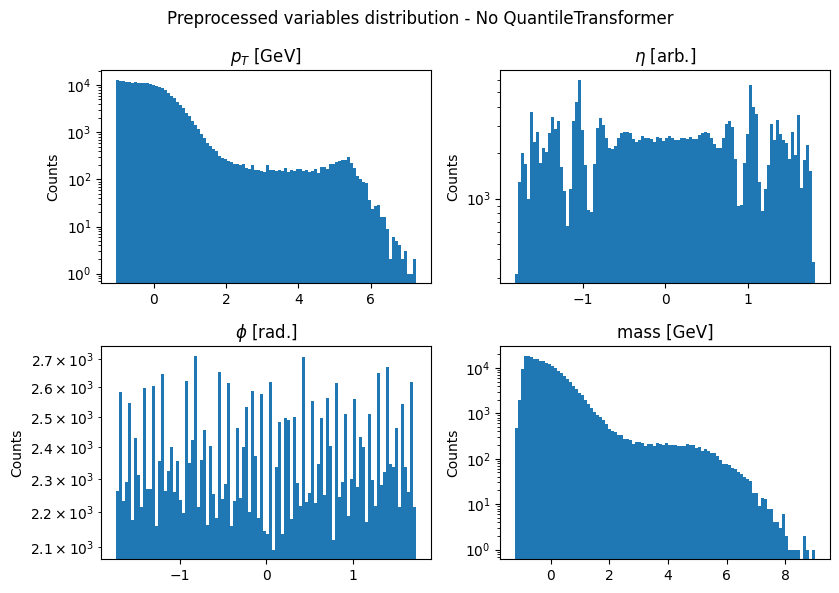

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution - No QuantileTransformer")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed_for_no_features.pdf',dpi=190)

In [6]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


In [7]:
epochs = 1000
batch_size = 10000
val_batch_size = 10000
delta = 3

counter = 0
loss_values = []
best_val_loss = 10000
loss_validation = []
start = time.time()
for i in range(epochs):
  epoch_loss = 0
  for j in tqdm(range(0,len(xt),batch_size)):
    x_batch = xt[j:j+batch_size]
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_batch).mean()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().detach()

  for param_group in optimizer.param_groups:
    lr = param_group['lr']
  epoch_loss /= (len(xt)//batch_size)
  scheduler.step(metrics=epoch_loss)
  loss_values.append(epoch_loss)

  with torch.no_grad():
    val_loss = 0
    for k in range(0, len(xval),val_batch_size):
      x_batch = xval[j:j+val_batch_size]
      loss_val = -flow.log_prob(inputs=xval).mean().cpu()
      val_loss += loss_val
    val_loss /= (len(xval)//val_batch_size)
    loss_validation.append(val_loss)
    if abs(val_loss-epoch_loss) > delta:
      counter += 1
      print('counter=',counter)
      if counter > 10:
        print('Early stopped')
        break
    print('Epoch: {}, Training loss = {}, Validation loss = {}, Learning rate = {}'.format(i,epoch_loss,val_loss,lr))
  if (i+1) % 100 == 0:
    nome='epoch='+str(i)+'modello-NoQuantile-N_iter'+str(num_iterations)+'-N_features'+str(hidden_features)+'-N_BS'+str(batch_size)+'-epochs'+str(epochs)+'-lr'+str(initial_lr)+'.pth'
    torch.save(flow.state_dict(), 'modelli/'+nome)
    print('Model saved')


end = time.time()
print('Time = {:0.05} s'.format(end-start))

100%|██████████| 24/24 [00:01<00:00, 12.28it/s]


counter= 1
Epoch: 0, Training loss = 8.939513206481934, Validation loss = 5.322077751159668, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 44.57it/s]


Epoch: 1, Training loss = 4.433349132537842, Validation loss = 3.5456511974334717, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 63.03it/s]


Epoch: 2, Training loss = 3.490084409713745, Validation loss = 3.1625850200653076, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.49it/s]


Epoch: 3, Training loss = 3.257840633392334, Validation loss = 3.010998487472534, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.28it/s]


Epoch: 4, Training loss = 3.122549057006836, Validation loss = 2.9098007678985596, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.95it/s]


Epoch: 5, Training loss = 3.0304675102233887, Validation loss = 2.845486879348755, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 41.30it/s]


Epoch: 6, Training loss = 2.9613356590270996, Validation loss = 2.8176021575927734, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 40.23it/s]


Epoch: 7, Training loss = 2.916928768157959, Validation loss = 2.789437770843506, Learning rate = 0.001


100%|██████████| 24/24 [00:01<00:00, 22.15it/s]


Epoch: 8, Training loss = 2.8838653564453125, Validation loss = 2.7753493785858154, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 36.21it/s]


Epoch: 9, Training loss = 2.861236810684204, Validation loss = 2.762202739715576, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.65it/s]


Epoch: 10, Training loss = 2.84226655960083, Validation loss = 2.752019166946411, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.35it/s]


Epoch: 11, Training loss = 2.829665422439575, Validation loss = 2.735132932662964, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.74it/s]


Epoch: 12, Training loss = 2.816880941390991, Validation loss = 2.736224412918091, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.82it/s]


Epoch: 13, Training loss = 2.8076255321502686, Validation loss = 2.7229743003845215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 45.99it/s]


Epoch: 14, Training loss = 2.7964508533477783, Validation loss = 2.7358853816986084, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.37it/s]


Epoch: 15, Training loss = 2.7851030826568604, Validation loss = 2.7264316082000732, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.99it/s]


Epoch: 16, Training loss = 2.7782492637634277, Validation loss = 2.720931053161621, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 69.89it/s]


Epoch: 17, Training loss = 2.7717549800872803, Validation loss = 2.719733238220215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.72it/s]


Epoch: 18, Training loss = 2.7653496265411377, Validation loss = 2.7179458141326904, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.03it/s]


Epoch: 19, Training loss = 2.759197473526001, Validation loss = 2.714956283569336, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.33it/s]


Epoch: 20, Training loss = 2.7536466121673584, Validation loss = 2.713949680328369, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.70it/s]


Epoch: 21, Training loss = 2.7483479976654053, Validation loss = 2.7137978076934814, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.60it/s]


Epoch: 22, Training loss = 2.7434113025665283, Validation loss = 2.712341547012329, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.41it/s]


Epoch: 23, Training loss = 2.738380193710327, Validation loss = 2.7072696685791016, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 24, Training loss = 2.7337119579315186, Validation loss = 2.7005221843719482, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.95it/s]


Epoch: 25, Training loss = 2.7296957969665527, Validation loss = 2.6963915824890137, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 64.45it/s]


Epoch: 26, Training loss = 2.725433111190796, Validation loss = 2.6940696239471436, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.04it/s]


Epoch: 27, Training loss = 2.7220122814178467, Validation loss = 2.6919760704040527, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.81it/s]


Epoch: 28, Training loss = 2.718583345413208, Validation loss = 2.6929240226745605, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.60it/s]


Epoch: 29, Training loss = 2.714496612548828, Validation loss = 2.693943500518799, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.02it/s]


Epoch: 30, Training loss = 2.7102432250976562, Validation loss = 2.692976951599121, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.81it/s]


Epoch: 31, Training loss = 2.706813097000122, Validation loss = 2.6914470195770264, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 68.52it/s]


Epoch: 32, Training loss = 2.7032675743103027, Validation loss = 2.690901279449463, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.35it/s]


Epoch: 33, Training loss = 2.700725793838501, Validation loss = 2.6922106742858887, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.62it/s]


Epoch: 34, Training loss = 2.6967155933380127, Validation loss = 2.690948724746704, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.10it/s]


Epoch: 35, Training loss = 2.693913221359253, Validation loss = 2.6930603981018066, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.23it/s]


Epoch: 36, Training loss = 2.6902642250061035, Validation loss = 2.6913836002349854, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.73it/s]


Epoch: 37, Training loss = 2.6870479583740234, Validation loss = 2.691866397857666, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 38, Training loss = 2.683872699737549, Validation loss = 2.6883344650268555, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.95it/s]


Epoch: 39, Training loss = 2.680999517440796, Validation loss = 2.6892662048339844, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.05it/s]


Epoch: 40, Training loss = 2.6786065101623535, Validation loss = 2.6879525184631348, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.06it/s]


Epoch: 41, Training loss = 2.675797939300537, Validation loss = 2.6896286010742188, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.78it/s]


Epoch: 42, Training loss = 2.6732611656188965, Validation loss = 2.6912195682525635, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.45it/s]


Epoch: 43, Training loss = 2.6705901622772217, Validation loss = 2.692011594772339, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 44, Training loss = 2.6680655479431152, Validation loss = 2.6906235218048096, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.76it/s]


Epoch: 45, Training loss = 2.6652708053588867, Validation loss = 2.690178632736206, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.29it/s]


Epoch: 46, Training loss = 2.6627042293548584, Validation loss = 2.689126491546631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 44.64it/s]


Epoch: 47, Training loss = 2.6601080894470215, Validation loss = 2.683781862258911, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.82it/s]


Epoch: 48, Training loss = 2.6577975749969482, Validation loss = 2.679513454437256, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.78it/s]


Epoch: 49, Training loss = 2.6554219722747803, Validation loss = 2.674793004989624, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.84it/s]


Epoch: 50, Training loss = 2.653141736984253, Validation loss = 2.673513889312744, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.30it/s]


Epoch: 51, Training loss = 2.6510987281799316, Validation loss = 2.6746344566345215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.38it/s]


Epoch: 52, Training loss = 2.6490862369537354, Validation loss = 2.6754932403564453, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.12it/s]


Epoch: 53, Training loss = 2.646984815597534, Validation loss = 2.6761858463287354, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.53it/s]


Epoch: 54, Training loss = 2.6451103687286377, Validation loss = 2.6783623695373535, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.98it/s]


Epoch: 55, Training loss = 2.643181562423706, Validation loss = 2.683135747909546, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.68it/s]


Epoch: 56, Training loss = 2.6410961151123047, Validation loss = 2.6893744468688965, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.38it/s]


Epoch: 57, Training loss = 2.639159917831421, Validation loss = 2.6949353218078613, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.96it/s]


Epoch: 58, Training loss = 2.6373472213745117, Validation loss = 2.7053046226501465, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.42it/s]


Epoch: 59, Training loss = 2.6355278491973877, Validation loss = 2.711529493331909, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.34it/s]


Epoch: 60, Training loss = 2.6339802742004395, Validation loss = 2.728391170501709, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.72it/s]


Epoch: 61, Training loss = 2.6322219371795654, Validation loss = 2.745422840118408, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.23it/s]


Epoch: 62, Training loss = 2.6306798458099365, Validation loss = 2.7479324340820312, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.25it/s]


Epoch: 63, Training loss = 2.6287097930908203, Validation loss = 2.7621729373931885, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.34it/s]


Epoch: 64, Training loss = 2.627869129180908, Validation loss = 2.769207239151001, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.09it/s]


Epoch: 65, Training loss = 2.625789165496826, Validation loss = 2.782280683517456, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 43.96it/s]


Epoch: 66, Training loss = 2.625089168548584, Validation loss = 2.788007974624634, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.75it/s]


Epoch: 67, Training loss = 2.622602701187134, Validation loss = 2.7971222400665283, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.02it/s]


Epoch: 68, Training loss = 2.6218440532684326, Validation loss = 2.8071014881134033, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 69, Training loss = 2.6204781532287598, Validation loss = 2.821416139602661, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 70, Training loss = 2.6191048622131348, Validation loss = 2.826765298843384, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.66it/s]


Epoch: 71, Training loss = 2.6177992820739746, Validation loss = 2.833606004714966, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.21it/s]


Epoch: 72, Training loss = 2.616485357284546, Validation loss = 2.8448867797851562, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.47it/s]


Epoch: 73, Training loss = 2.614891767501831, Validation loss = 2.8546252250671387, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.86it/s]


Epoch: 74, Training loss = 2.6140573024749756, Validation loss = 2.8666040897369385, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.73it/s]


Epoch: 75, Training loss = 2.6130292415618896, Validation loss = 2.8733749389648438, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.33it/s]


Epoch: 76, Training loss = 2.612082004547119, Validation loss = 2.884511947631836, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.57it/s]


Epoch: 77, Training loss = 2.6115052700042725, Validation loss = 2.8816378116607666, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.00it/s]


Epoch: 78, Training loss = 2.61189866065979, Validation loss = 2.8831517696380615, Learning rate = 0.001


100%|██████████| 24/24 [00:01<00:00, 21.73it/s]


Epoch: 79, Training loss = 2.6107230186462402, Validation loss = 2.8834264278411865, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 36.65it/s]


Epoch: 80, Training loss = 2.6081185340881348, Validation loss = 2.884838342666626, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.27it/s]


Epoch: 81, Training loss = 2.6068685054779053, Validation loss = 2.8936426639556885, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.63it/s]


Epoch: 82, Training loss = 2.605895519256592, Validation loss = 2.9065051078796387, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.31it/s]


Epoch: 83, Training loss = 2.6052744388580322, Validation loss = 2.8976125717163086, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 55.45it/s]


Epoch: 84, Training loss = 2.6036970615386963, Validation loss = 2.895601987838745, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.62it/s]


Epoch: 85, Training loss = 2.602687358856201, Validation loss = 2.8924224376678467, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.77it/s]


Epoch: 86, Training loss = 2.6026904582977295, Validation loss = 2.883532762527466, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.23it/s]


Epoch: 87, Training loss = 2.603489875793457, Validation loss = 2.883955240249634, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.51it/s]


Epoch: 88, Training loss = 2.6062958240509033, Validation loss = 2.879150152206421, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.74it/s]


Epoch: 89, Training loss = 2.603095293045044, Validation loss = 2.8868160247802734, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.56it/s]


Epoch: 90, Training loss = 2.6003365516662598, Validation loss = 2.8894524574279785, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.40it/s]


Epoch: 91, Training loss = 2.5985946655273438, Validation loss = 2.893580198287964, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.30it/s]


Epoch: 92, Training loss = 2.596649169921875, Validation loss = 2.8949244022369385, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.75it/s]


Epoch: 93, Training loss = 2.595210075378418, Validation loss = 2.887439012527466, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.92it/s]


Epoch: 94, Training loss = 2.5940659046173096, Validation loss = 2.888958215713501, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.00it/s]


Epoch: 95, Training loss = 2.5928878784179688, Validation loss = 2.884791135787964, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch: 96, Training loss = 2.5917277336120605, Validation loss = 2.8841826915740967, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.96it/s]


Epoch: 97, Training loss = 2.5908870697021484, Validation loss = 2.8821442127227783, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 32.56it/s]


Epoch: 98, Training loss = 2.59010648727417, Validation loss = 2.876723289489746, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 27.37it/s]


Epoch: 99, Training loss = 2.5895423889160156, Validation loss = 2.8737995624542236, Learning rate = 0.001
Model saved


100%|██████████| 24/24 [00:00<00:00, 29.88it/s]


Epoch: 100, Training loss = 2.589226007461548, Validation loss = 2.8676156997680664, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.32it/s]


Epoch: 101, Training loss = 2.5891711711883545, Validation loss = 2.860640525817871, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.85it/s]


Epoch: 102, Training loss = 2.5889170169830322, Validation loss = 2.864295244216919, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 39.68it/s]


Epoch: 103, Training loss = 2.588491678237915, Validation loss = 2.861027956008911, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.66it/s]


Epoch: 104, Training loss = 2.587618589401245, Validation loss = 2.862081527709961, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.60it/s]


Epoch: 105, Training loss = 2.586751937866211, Validation loss = 2.8672444820404053, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.50it/s]


Epoch: 106, Training loss = 2.5855202674865723, Validation loss = 2.8587257862091064, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.01it/s]


Epoch: 107, Training loss = 2.5843706130981445, Validation loss = 2.855353593826294, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 108, Training loss = 2.583933115005493, Validation loss = 2.848567485809326, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 109, Training loss = 2.583378553390503, Validation loss = 2.844552516937256, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.45it/s]


Epoch: 110, Training loss = 2.5831046104431152, Validation loss = 2.8375141620635986, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.60it/s]


Epoch: 111, Training loss = 2.582625389099121, Validation loss = 2.8367247581481934, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.48it/s]


Epoch: 112, Training loss = 2.5818910598754883, Validation loss = 2.8323001861572266, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.45it/s]


Epoch: 113, Training loss = 2.5811402797698975, Validation loss = 2.8264756202697754, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.72it/s]


Epoch: 114, Training loss = 2.580786943435669, Validation loss = 2.819598436355591, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.78it/s]


Epoch: 115, Training loss = 2.5801169872283936, Validation loss = 2.815922975540161, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.12it/s]


Epoch: 116, Training loss = 2.5794837474823, Validation loss = 2.811901807785034, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.71it/s]


Epoch: 117, Training loss = 2.5789499282836914, Validation loss = 2.808854818344116, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.55it/s]


Epoch: 118, Training loss = 2.5786945819854736, Validation loss = 2.806983232498169, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.77it/s]


Epoch: 119, Training loss = 2.578430414199829, Validation loss = 2.800724506378174, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 120, Training loss = 2.577759027481079, Validation loss = 2.7988815307617188, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.11it/s]


Epoch: 121, Training loss = 2.5774168968200684, Validation loss = 2.797457218170166, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.06it/s]


Epoch: 122, Training loss = 2.577101945877075, Validation loss = 2.795841693878174, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.89it/s]


Epoch: 123, Training loss = 2.576500177383423, Validation loss = 2.7940776348114014, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 68.18it/s]


Epoch: 124, Training loss = 2.575899600982666, Validation loss = 2.7944769859313965, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.89it/s]


Epoch: 125, Training loss = 2.5756232738494873, Validation loss = 2.7874627113342285, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.42it/s]


Epoch: 126, Training loss = 2.5749809741973877, Validation loss = 2.783395290374756, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.07it/s]


Epoch: 127, Training loss = 2.5742897987365723, Validation loss = 2.7788524627685547, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.59it/s]


Epoch: 128, Training loss = 2.573493719100952, Validation loss = 2.7773797512054443, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.08it/s]


Epoch: 129, Training loss = 2.572916030883789, Validation loss = 2.7747840881347656, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.94it/s]


Epoch: 130, Training loss = 2.5726215839385986, Validation loss = 2.7710981369018555, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.26it/s]


Epoch: 131, Training loss = 2.572599172592163, Validation loss = 2.767977714538574, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.41it/s]


Epoch: 132, Training loss = 2.5723068714141846, Validation loss = 2.7665886878967285, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.84it/s]


Epoch: 133, Training loss = 2.5723886489868164, Validation loss = 2.762650728225708, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.72it/s]


Epoch: 134, Training loss = 2.5722992420196533, Validation loss = 2.762913942337036, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.17it/s]


Epoch: 135, Training loss = 2.5716323852539062, Validation loss = 2.761679172515869, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.01it/s]


Epoch: 136, Training loss = 2.5710673332214355, Validation loss = 2.760470390319824, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.57it/s]


Epoch: 137, Training loss = 2.570716381072998, Validation loss = 2.7615647315979004, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 33.62it/s]


Epoch: 138, Training loss = 2.5700926780700684, Validation loss = 2.758049964904785, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 35.95it/s]


Epoch: 139, Training loss = 2.5691213607788086, Validation loss = 2.7576510906219482, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.01it/s]


Epoch: 140, Training loss = 2.5685372352600098, Validation loss = 2.753586769104004, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.75it/s]


Epoch: 141, Training loss = 2.568305730819702, Validation loss = 2.7502477169036865, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.87it/s]


Epoch: 142, Training loss = 2.5681657791137695, Validation loss = 2.746100664138794, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.23it/s]


Epoch: 143, Training loss = 2.5681896209716797, Validation loss = 2.7484757900238037, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.56it/s]


Epoch: 144, Training loss = 2.568025588989258, Validation loss = 2.745861291885376, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.06it/s]


Epoch: 145, Training loss = 2.5677380561828613, Validation loss = 2.7454874515533447, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.36it/s]


Epoch: 146, Training loss = 2.5671987533569336, Validation loss = 2.7429747581481934, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.47it/s]


Epoch: 147, Training loss = 2.5669138431549072, Validation loss = 2.7430756092071533, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 34.80it/s]


Epoch: 148, Training loss = 2.56640887260437, Validation loss = 2.7406673431396484, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 36.45it/s]


Epoch: 149, Training loss = 2.5657711029052734, Validation loss = 2.737964391708374, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 37.51it/s]


Epoch: 150, Training loss = 2.565398931503296, Validation loss = 2.738863468170166, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 151, Training loss = 2.5647106170654297, Validation loss = 2.7377734184265137, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.10it/s]


Epoch: 152, Training loss = 2.5641419887542725, Validation loss = 2.734713077545166, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.43it/s]


Epoch: 153, Training loss = 2.564088821411133, Validation loss = 2.732574701309204, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 65.77it/s]


Epoch: 154, Training loss = 2.5645461082458496, Validation loss = 2.730686664581299, Learning rate = 0.001


100%|██████████| 24/24 [00:01<00:00, 23.89it/s]


Epoch: 155, Training loss = 2.5649805068969727, Validation loss = 2.732257127761841, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 156, Training loss = 2.56488299369812, Validation loss = 2.732870101928711, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.09it/s]


Epoch: 157, Training loss = 2.5644278526306152, Validation loss = 2.729342460632324, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.03it/s]


Epoch: 158, Training loss = 2.563553810119629, Validation loss = 2.7239456176757812, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.51it/s]


Epoch: 159, Training loss = 2.562737226486206, Validation loss = 2.7229931354522705, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.03it/s]


Epoch: 160, Training loss = 2.5621118545532227, Validation loss = 2.7198290824890137, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.83it/s]


Epoch: 161, Training loss = 2.5617151260375977, Validation loss = 2.7172048091888428, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.67it/s]


Epoch: 162, Training loss = 2.5611820220947266, Validation loss = 2.7159805297851562, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.41it/s]


Epoch: 163, Training loss = 2.5608768463134766, Validation loss = 2.7124762535095215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.95it/s]


Epoch: 164, Training loss = 2.5613179206848145, Validation loss = 2.710211992263794, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.16it/s]


Epoch: 165, Training loss = 2.5615978240966797, Validation loss = 2.7079954147338867, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.98it/s]


Epoch: 166, Training loss = 2.5615458488464355, Validation loss = 2.704404354095459, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.04it/s]


Epoch: 167, Training loss = 2.561310291290283, Validation loss = 2.704961061477661, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.08it/s]


Epoch: 168, Training loss = 2.560962677001953, Validation loss = 2.706075668334961, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.26it/s]


Epoch: 169, Training loss = 2.560594081878662, Validation loss = 2.7042253017425537, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.87it/s]


Epoch: 170, Training loss = 2.5599095821380615, Validation loss = 2.7028400897979736, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.53it/s]


Epoch: 171, Training loss = 2.559462070465088, Validation loss = 2.6999588012695312, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.75it/s]


Epoch: 172, Training loss = 2.5590462684631348, Validation loss = 2.6979007720947266, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.46it/s]


Epoch: 173, Training loss = 2.5588219165802, Validation loss = 2.6973111629486084, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.29it/s]


Epoch: 174, Training loss = 2.5587689876556396, Validation loss = 2.6964704990386963, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.91it/s]


Epoch: 175, Training loss = 2.5584964752197266, Validation loss = 2.6935455799102783, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.87it/s]


Epoch: 176, Training loss = 2.5584142208099365, Validation loss = 2.692582845687866, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.48it/s]


Epoch: 177, Training loss = 2.55843448638916, Validation loss = 2.691869020462036, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.86it/s]


Epoch: 178, Training loss = 2.558546543121338, Validation loss = 2.6901488304138184, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.53it/s]


Epoch: 179, Training loss = 2.558436155319214, Validation loss = 2.690887212753296, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 58.81it/s]


Epoch: 180, Training loss = 2.558086633682251, Validation loss = 2.688291072845459, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.98it/s]


Epoch: 181, Training loss = 2.5574967861175537, Validation loss = 2.686300754547119, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.20it/s]


Epoch: 182, Training loss = 2.5569705963134766, Validation loss = 2.68691349029541, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.77it/s]


Epoch: 183, Training loss = 2.556750535964966, Validation loss = 2.6864209175109863, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 184, Training loss = 2.556450128555298, Validation loss = 2.6854329109191895, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.53it/s]


Epoch: 185, Training loss = 2.5562522411346436, Validation loss = 2.6849348545074463, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.41it/s]


Epoch: 186, Training loss = 2.555722713470459, Validation loss = 2.681405544281006, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 40.56it/s]


Epoch: 187, Training loss = 2.555309772491455, Validation loss = 2.679835081100464, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 64.87it/s]


Epoch: 188, Training loss = 2.5547969341278076, Validation loss = 2.678255081176758, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.72it/s]


Epoch: 189, Training loss = 2.554666042327881, Validation loss = 2.677992343902588, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.04it/s]


Epoch: 190, Training loss = 2.554616928100586, Validation loss = 2.6805808544158936, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.25it/s]


Epoch: 191, Training loss = 2.5548789501190186, Validation loss = 2.679541826248169, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.52it/s]


Epoch: 192, Training loss = 2.555015802383423, Validation loss = 2.681751012802124, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.22it/s]


Epoch: 193, Training loss = 2.5550785064697266, Validation loss = 2.6814682483673096, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.83it/s]


Epoch: 194, Training loss = 2.55493426322937, Validation loss = 2.6799068450927734, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.26it/s]


Epoch: 195, Training loss = 2.5541906356811523, Validation loss = 2.677213668823242, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.26it/s]


Epoch: 196, Training loss = 2.5535495281219482, Validation loss = 2.6761372089385986, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.76it/s]


Epoch: 197, Training loss = 2.5532522201538086, Validation loss = 2.6735787391662598, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.15it/s]


Epoch: 198, Training loss = 2.5528080463409424, Validation loss = 2.6712779998779297, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 199, Training loss = 2.55257511138916, Validation loss = 2.670231342315674, Learning rate = 0.001
Model saved


100%|██████████| 24/24 [00:00<00:00, 50.38it/s]


Epoch: 200, Training loss = 2.5527167320251465, Validation loss = 2.6696975231170654, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.80it/s]


Epoch: 201, Training loss = 2.552389144897461, Validation loss = 2.6696059703826904, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.85it/s]


Epoch: 202, Training loss = 2.5521740913391113, Validation loss = 2.6687140464782715, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.91it/s]


Epoch: 203, Training loss = 2.552138090133667, Validation loss = 2.670444965362549, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.36it/s]


Epoch: 204, Training loss = 2.5520594120025635, Validation loss = 2.6689693927764893, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.95it/s]


Epoch: 205, Training loss = 2.5516481399536133, Validation loss = 2.667046308517456, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.84it/s]


Epoch: 206, Training loss = 2.552044153213501, Validation loss = 2.6685383319854736, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.71it/s]


Epoch: 207, Training loss = 2.552140712738037, Validation loss = 2.668405055999756, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.15it/s]


Epoch: 208, Training loss = 2.5521419048309326, Validation loss = 2.6684229373931885, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.97it/s]


Epoch: 209, Training loss = 2.551638126373291, Validation loss = 2.667720317840576, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.68it/s]


Epoch: 210, Training loss = 2.5512845516204834, Validation loss = 2.6678855419158936, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.57it/s]


Epoch: 211, Training loss = 2.55134654045105, Validation loss = 2.6675331592559814, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.71it/s]


Epoch: 212, Training loss = 2.5513863563537598, Validation loss = 2.663909673690796, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.84it/s]


Epoch: 213, Training loss = 2.550720691680908, Validation loss = 2.6630470752716064, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.17it/s]


Epoch: 214, Training loss = 2.550048351287842, Validation loss = 2.659515380859375, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.68it/s]


Epoch: 215, Training loss = 2.5495636463165283, Validation loss = 2.658630609512329, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.55it/s]


Epoch: 216, Training loss = 2.5491793155670166, Validation loss = 2.6583244800567627, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.44it/s]


Epoch: 217, Training loss = 2.549049139022827, Validation loss = 2.659682273864746, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch: 218, Training loss = 2.5490610599517822, Validation loss = 2.6610360145568848, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.62it/s]


Epoch: 219, Training loss = 2.549032688140869, Validation loss = 2.662860155105591, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.41it/s]


Epoch: 220, Training loss = 2.549474000930786, Validation loss = 2.664062023162842, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.13it/s]


Epoch: 221, Training loss = 2.549516201019287, Validation loss = 2.662461280822754, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.88it/s]


Epoch: 222, Training loss = 2.5498244762420654, Validation loss = 2.659271478652954, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.08it/s]


Epoch: 223, Training loss = 2.550020933151245, Validation loss = 2.656686305999756, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.73it/s]


Epoch: 224, Training loss = 2.5497915744781494, Validation loss = 2.6571950912475586, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.52it/s]


Epoch: 225, Training loss = 2.5492448806762695, Validation loss = 2.653684139251709, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.87it/s]


Epoch: 226, Training loss = 2.5485951900482178, Validation loss = 2.653324604034424, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.11it/s]


Epoch: 227, Training loss = 2.5482077598571777, Validation loss = 2.6559646129608154, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.29it/s]


Epoch: 228, Training loss = 2.547919750213623, Validation loss = 2.6569926738739014, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.27it/s]


Epoch: 229, Training loss = 2.54728364944458, Validation loss = 2.6568408012390137, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.54it/s]


Epoch: 230, Training loss = 2.54723858833313, Validation loss = 2.6559131145477295, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.58it/s]


Epoch: 231, Training loss = 2.5472946166992188, Validation loss = 2.6547257900238037, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.06it/s]


Epoch: 232, Training loss = 2.546856641769409, Validation loss = 2.6545157432556152, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.07it/s]


Epoch: 233, Training loss = 2.5466549396514893, Validation loss = 2.6556546688079834, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.11it/s]


Epoch: 234, Training loss = 2.5468673706054688, Validation loss = 2.6553359031677246, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.70it/s]


Epoch: 235, Training loss = 2.546597480773926, Validation loss = 2.6541366577148438, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.66it/s]


Epoch: 236, Training loss = 2.5466365814208984, Validation loss = 2.655545711517334, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.49it/s]


Epoch: 237, Training loss = 2.546574115753174, Validation loss = 2.6530590057373047, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 55.94it/s]


Epoch: 238, Training loss = 2.546649694442749, Validation loss = 2.6512069702148438, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.77it/s]


Epoch: 239, Training loss = 2.5465996265411377, Validation loss = 2.649592161178589, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.17it/s]


Epoch: 240, Training loss = 2.5463473796844482, Validation loss = 2.649933099746704, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.42it/s]


Epoch: 241, Training loss = 2.545926094055176, Validation loss = 2.650054693222046, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.71it/s]


Epoch: 242, Training loss = 2.545260190963745, Validation loss = 2.6494956016540527, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.36it/s]


Epoch: 243, Training loss = 2.5451481342315674, Validation loss = 2.6525464057922363, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.98it/s]


Epoch: 244, Training loss = 2.544984817504883, Validation loss = 2.652672529220581, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.94it/s]


Epoch: 245, Training loss = 2.544705867767334, Validation loss = 2.6514432430267334, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.88it/s]


Epoch: 246, Training loss = 2.544445753097534, Validation loss = 2.6510398387908936, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.60it/s]


Epoch: 247, Training loss = 2.5443334579467773, Validation loss = 2.6491589546203613, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.17it/s]


Epoch: 248, Training loss = 2.544343948364258, Validation loss = 2.653249740600586, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.64it/s]


Epoch: 249, Training loss = 2.544052839279175, Validation loss = 2.6520960330963135, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.37it/s]


Epoch: 250, Training loss = 2.5437400341033936, Validation loss = 2.652785301208496, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.19it/s]


Epoch: 251, Training loss = 2.5441625118255615, Validation loss = 2.6494362354278564, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.12it/s]


Epoch: 252, Training loss = 2.544515609741211, Validation loss = 2.6499550342559814, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.03it/s]


Epoch: 253, Training loss = 2.544950246810913, Validation loss = 2.6487390995025635, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.55it/s]


Epoch: 254, Training loss = 2.5452799797058105, Validation loss = 2.646892786026001, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.86it/s]


Epoch: 255, Training loss = 2.5448837280273438, Validation loss = 2.6456351280212402, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.61it/s]


Epoch: 256, Training loss = 2.5443058013916016, Validation loss = 2.6447277069091797, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.04it/s]


Epoch: 257, Training loss = 2.543937921524048, Validation loss = 2.643345355987549, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.75it/s]


Epoch: 258, Training loss = 2.54379940032959, Validation loss = 2.6403141021728516, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.78it/s]


Epoch: 259, Training loss = 2.5436360836029053, Validation loss = 2.641674280166626, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.82it/s]


Epoch: 260, Training loss = 2.543389320373535, Validation loss = 2.639549732208252, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.76it/s]


Epoch: 261, Training loss = 2.5435492992401123, Validation loss = 2.6397597789764404, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.41it/s]


Epoch: 262, Training loss = 2.543818712234497, Validation loss = 2.6389198303222656, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.08it/s]


Epoch: 263, Training loss = 2.544511556625366, Validation loss = 2.6374521255493164, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.08it/s]


Epoch: 264, Training loss = 2.5462682247161865, Validation loss = 2.6348369121551514, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 45.87it/s]


Epoch: 265, Training loss = 2.5509378910064697, Validation loss = 2.646157741546631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.31it/s]


Epoch: 266, Training loss = 2.552213668823242, Validation loss = 2.6429004669189453, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.12it/s]


Epoch: 267, Training loss = 2.5512611865997314, Validation loss = 2.637188196182251, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.55it/s]


Epoch: 268, Training loss = 2.5500566959381104, Validation loss = 2.6329450607299805, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.97it/s]


Epoch: 269, Training loss = 2.5526468753814697, Validation loss = 2.623767137527466, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.80it/s]


Epoch: 270, Training loss = 2.5557665824890137, Validation loss = 2.6098549365997314, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.24it/s]


Epoch: 271, Training loss = 2.5609357357025146, Validation loss = 2.609492063522339, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.67it/s]


Epoch: 272, Training loss = 2.5416994094848633, Validation loss = 2.6235344409942627, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.78it/s]


Epoch: 273, Training loss = 2.5349557399749756, Validation loss = 2.6147611141204834, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.49it/s]


Epoch: 274, Training loss = 2.5339510440826416, Validation loss = 2.6207120418548584, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.53it/s]


Epoch: 275, Training loss = 2.5340497493743896, Validation loss = 2.623181104660034, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 76.88it/s]


Epoch: 276, Training loss = 2.5339975357055664, Validation loss = 2.626603126525879, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 55.59it/s]


Epoch: 277, Training loss = 2.53406023979187, Validation loss = 2.6282989978790283, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 46.28it/s]


Epoch: 278, Training loss = 2.5341339111328125, Validation loss = 2.630959987640381, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.99it/s]


Epoch: 279, Training loss = 2.534113645553589, Validation loss = 2.6321725845336914, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.74it/s]


Epoch: 280, Training loss = 2.534060478210449, Validation loss = 2.632622480392456, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.97it/s]


Epoch: 281, Training loss = 2.5340404510498047, Validation loss = 2.6328258514404297, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.54it/s]


Epoch: 282, Training loss = 2.5339863300323486, Validation loss = 2.633190870285034, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 56.22it/s]


Epoch: 283, Training loss = 2.5339720249176025, Validation loss = 2.6320526599884033, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 48.76it/s]


Epoch: 284, Training loss = 2.5337886810302734, Validation loss = 2.6307876110076904, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 76.48it/s]


Epoch: 285, Training loss = 2.5336556434631348, Validation loss = 2.629406690597534, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 75.95it/s]


Epoch: 286, Training loss = 2.5335488319396973, Validation loss = 2.6279375553131104, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 76.91it/s]


Epoch: 287, Training loss = 2.5334694385528564, Validation loss = 2.626007318496704, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.29it/s]


Epoch: 288, Training loss = 2.5333683490753174, Validation loss = 2.6242635250091553, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.11it/s]


Epoch: 289, Training loss = 2.5331599712371826, Validation loss = 2.623670816421509, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 52.33it/s]


Epoch: 290, Training loss = 2.5329957008361816, Validation loss = 2.622790575027466, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 49.64it/s]


Epoch: 291, Training loss = 2.5329041481018066, Validation loss = 2.621458053588867, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.40it/s]


Epoch: 292, Training loss = 2.532783031463623, Validation loss = 2.620553731918335, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 76.72it/s]


Epoch: 293, Training loss = 2.532623529434204, Validation loss = 2.6200809478759766, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 74.71it/s]


Epoch: 294, Training loss = 2.532501459121704, Validation loss = 2.619826078414917, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 75.24it/s]


Epoch: 295, Training loss = 2.532437801361084, Validation loss = 2.619295597076416, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 58.00it/s]


Epoch: 296, Training loss = 2.5322988033294678, Validation loss = 2.6191084384918213, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 50.85it/s]


Epoch: 297, Training loss = 2.5322506427764893, Validation loss = 2.6188220977783203, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.10it/s]


Epoch: 298, Training loss = 2.5321872234344482, Validation loss = 2.6185948848724365, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.02it/s]


Epoch: 299, Training loss = 2.5321173667907715, Validation loss = 2.6182174682617188, Learning rate = 0.0005
Model saved


100%|██████████| 24/24 [00:00<00:00, 79.79it/s]


Epoch: 300, Training loss = 2.532053232192993, Validation loss = 2.6175880432128906, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.16it/s]


Epoch: 301, Training loss = 2.5320487022399902, Validation loss = 2.617440700531006, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.15it/s]


Epoch: 302, Training loss = 2.5320558547973633, Validation loss = 2.6176674365997314, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 49.67it/s]


Epoch: 303, Training loss = 2.5320446491241455, Validation loss = 2.617565393447876, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 59.29it/s]


Epoch: 304, Training loss = 2.53196382522583, Validation loss = 2.617213010787964, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.34it/s]


Epoch: 305, Training loss = 2.5319998264312744, Validation loss = 2.6171374320983887, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 77.96it/s]


Epoch: 306, Training loss = 2.5320374965667725, Validation loss = 2.6178033351898193, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.96it/s]


Epoch: 307, Training loss = 2.531970500946045, Validation loss = 2.6170945167541504, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.77it/s]


Epoch: 308, Training loss = 2.531913995742798, Validation loss = 2.6172454357147217, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 58.27it/s]


Epoch: 309, Training loss = 2.53190016746521, Validation loss = 2.617595911026001, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 48.91it/s]


Epoch: 310, Training loss = 2.5320467948913574, Validation loss = 2.618441104888916, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 74.51it/s]


Epoch: 311, Training loss = 2.5320186614990234, Validation loss = 2.6184399127960205, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 75.55it/s]


Epoch: 312, Training loss = 2.532024621963501, Validation loss = 2.618173599243164, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 75.87it/s]


Epoch: 313, Training loss = 2.53196382522583, Validation loss = 2.61738920211792, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 75.71it/s]


Epoch: 314, Training loss = 2.531855821609497, Validation loss = 2.618072748184204, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.90it/s]


Epoch: 315, Training loss = 2.528635263442993, Validation loss = 2.6256957054138184, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 49.83it/s]


Epoch: 316, Training loss = 2.528611898422241, Validation loss = 2.6291122436523438, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.43it/s]


Epoch: 317, Training loss = 2.5283873081207275, Validation loss = 2.6288368701934814, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.81it/s]


Epoch: 318, Training loss = 2.528179883956909, Validation loss = 2.6287407875061035, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.90it/s]


Epoch: 319, Training loss = 2.5280864238739014, Validation loss = 2.629073143005371, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.12it/s]


Epoch: 320, Training loss = 2.5280230045318604, Validation loss = 2.629335880279541, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.81it/s]


Epoch: 321, Training loss = 2.5279390811920166, Validation loss = 2.6290411949157715, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 57.67it/s]


Epoch: 322, Training loss = 2.5278704166412354, Validation loss = 2.629697322845459, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 49.87it/s]


Epoch: 323, Training loss = 2.5278029441833496, Validation loss = 2.6296980381011963, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.07it/s]


Epoch: 324, Training loss = 2.527728319168091, Validation loss = 2.6297597885131836, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.69it/s]


Epoch: 325, Training loss = 2.5276918411254883, Validation loss = 2.629852533340454, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.40it/s]


Epoch: 326, Training loss = 2.527639150619507, Validation loss = 2.6301631927490234, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.85it/s]


Epoch: 327, Training loss = 2.527585983276367, Validation loss = 2.6305816173553467, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.89it/s]


Epoch: 328, Training loss = 2.5275402069091797, Validation loss = 2.630561113357544, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 48.05it/s]


Epoch: 329, Training loss = 2.5274932384490967, Validation loss = 2.6307239532470703, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.89it/s]


Epoch: 330, Training loss = 2.527461290359497, Validation loss = 2.6306204795837402, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.21it/s]


Epoch: 331, Training loss = 2.527393341064453, Validation loss = 2.6309473514556885, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.91it/s]


Epoch: 332, Training loss = 2.5274040699005127, Validation loss = 2.6307718753814697, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 333, Training loss = 2.5273616313934326, Validation loss = 2.6313533782958984, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.22it/s]


Epoch: 334, Training loss = 2.5273633003234863, Validation loss = 2.6313765048980713, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 58.08it/s]


Epoch: 335, Training loss = 2.527329683303833, Validation loss = 2.6313538551330566, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 48.00it/s]


Epoch: 336, Training loss = 2.527268886566162, Validation loss = 2.6320784091949463, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.28it/s]


Epoch: 337, Training loss = 2.5272748470306396, Validation loss = 2.6318695545196533, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.67it/s]


Epoch: 338, Training loss = 2.5272183418273926, Validation loss = 2.632148027420044, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch: 339, Training loss = 2.5272037982940674, Validation loss = 2.6324267387390137, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch: 340, Training loss = 2.5271387100219727, Validation loss = 2.632833480834961, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 63.11it/s]


Epoch: 341, Training loss = 2.5271387100219727, Validation loss = 2.6334030628204346, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 48.49it/s]


Epoch: 342, Training loss = 2.5271155834198, Validation loss = 2.6336734294891357, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 74.22it/s]


Epoch: 343, Training loss = 2.5271148681640625, Validation loss = 2.633411169052124, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.96it/s]


Epoch: 344, Training loss = 2.5271167755126953, Validation loss = 2.633737087249756, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.42it/s]


Epoch: 345, Training loss = 2.527086019515991, Validation loss = 2.6338138580322266, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.13it/s]


Epoch: 346, Training loss = 2.5270447731018066, Validation loss = 2.634035587310791, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 76.40it/s]


Epoch: 347, Training loss = 2.5270462036132812, Validation loss = 2.634281635284424, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 56.76it/s]


Epoch: 348, Training loss = 2.527060031890869, Validation loss = 2.6349265575408936, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 47.44it/s]


Epoch: 349, Training loss = 2.5270578861236572, Validation loss = 2.6343624591827393, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 76.25it/s]


Epoch: 350, Training loss = 2.527026414871216, Validation loss = 2.6346170902252197, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.14it/s]


Epoch: 351, Training loss = 2.5270464420318604, Validation loss = 2.6355514526367188, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 73.53it/s]


Epoch: 352, Training loss = 2.527080774307251, Validation loss = 2.6356310844421387, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 71.45it/s]


Epoch: 353, Training loss = 2.5270469188690186, Validation loss = 2.6355209350585938, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 51.77it/s]


Epoch: 354, Training loss = 2.5270187854766846, Validation loss = 2.635946273803711, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 47.51it/s]


Epoch: 355, Training loss = 2.5270066261291504, Validation loss = 2.6355254650115967, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch: 356, Training loss = 2.526973009109497, Validation loss = 2.636945962905884, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.43it/s]


Epoch: 357, Training loss = 2.5269124507904053, Validation loss = 2.6374144554138184, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 75.23it/s]


Epoch: 358, Training loss = 2.5247981548309326, Validation loss = 2.620244264602661, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.64it/s]


Epoch: 359, Training loss = 2.5247244834899902, Validation loss = 2.6205811500549316, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 360, Training loss = 2.524683713912964, Validation loss = 2.619603395462036, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 53.03it/s]


Epoch: 361, Training loss = 2.524533748626709, Validation loss = 2.619802474975586, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 49.17it/s]


Epoch: 362, Training loss = 2.524484395980835, Validation loss = 2.619586706161499, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.00it/s]


Epoch: 363, Training loss = 2.5244545936584473, Validation loss = 2.6196651458740234, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.06it/s]


Epoch: 364, Training loss = 2.524426221847534, Validation loss = 2.619649887084961, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.39it/s]


Epoch: 365, Training loss = 2.5243947505950928, Validation loss = 2.6198062896728516, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.54it/s]


Epoch: 366, Training loss = 2.5243704319000244, Validation loss = 2.6198010444641113, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 55.43it/s]


Epoch: 367, Training loss = 2.524329662322998, Validation loss = 2.619741678237915, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.39it/s]


Epoch: 368, Training loss = 2.524308919906616, Validation loss = 2.6197266578674316, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 70.62it/s]


Epoch: 369, Training loss = 2.524293899536133, Validation loss = 2.6199960708618164, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.39it/s]


Epoch: 370, Training loss = 2.5242671966552734, Validation loss = 2.619856119155884, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 82.26it/s]


Epoch: 371, Training loss = 2.524260997772217, Validation loss = 2.619940757751465, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 82.75it/s]


Epoch: 372, Training loss = 2.524242401123047, Validation loss = 2.6198649406433105, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.76it/s]


Epoch: 373, Training loss = 2.5242252349853516, Validation loss = 2.6202352046966553, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.10it/s]


Epoch: 374, Training loss = 2.524190902709961, Validation loss = 2.6201674938201904, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 66.74it/s]


Epoch: 375, Training loss = 2.524168014526367, Validation loss = 2.6202309131622314, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.08it/s]


Epoch: 376, Training loss = 2.524151563644409, Validation loss = 2.6204302310943604, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 77.11it/s]


Epoch: 377, Training loss = 2.52412748336792, Validation loss = 2.6206371784210205, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.37it/s]


Epoch: 378, Training loss = 2.5241246223449707, Validation loss = 2.620875120162964, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 79.60it/s]


Epoch: 379, Training loss = 2.524115800857544, Validation loss = 2.621182441711426, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 60.16it/s]


Epoch: 380, Training loss = 2.524113416671753, Validation loss = 2.6210436820983887, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 48.17it/s]


Epoch: 381, Training loss = 2.524090051651001, Validation loss = 2.6211869716644287, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 81.57it/s]


Epoch: 382, Training loss = 2.523355007171631, Validation loss = 2.633474349975586, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 74.35it/s]


Epoch: 383, Training loss = 2.5233075618743896, Validation loss = 2.6306564807891846, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 77.66it/s]


Epoch: 384, Training loss = 2.5233006477355957, Validation loss = 2.6306633949279785, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 81.70it/s]


Epoch: 385, Training loss = 2.523292303085327, Validation loss = 2.6305959224700928, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.90it/s]


Epoch: 386, Training loss = 2.523254871368408, Validation loss = 2.6307754516601562, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 48.11it/s]


Epoch: 387, Training loss = 2.523228168487549, Validation loss = 2.6310274600982666, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.49it/s]


Epoch: 388, Training loss = 2.5232090950012207, Validation loss = 2.6310184001922607, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 79.94it/s]


Epoch: 389, Training loss = 2.5231871604919434, Validation loss = 2.6311967372894287, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 76.53it/s]


Epoch: 390, Training loss = 2.5231668949127197, Validation loss = 2.631208658218384, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.04it/s]


Epoch: 391, Training loss = 2.523146867752075, Validation loss = 2.6311707496643066, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 82.31it/s]


Epoch: 392, Training loss = 2.523124933242798, Validation loss = 2.6314117908477783, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 58.46it/s]


Epoch: 393, Training loss = 2.5230956077575684, Validation loss = 2.631363868713379, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 49.08it/s]


Epoch: 394, Training loss = 2.5230698585510254, Validation loss = 2.6316232681274414, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 395, Training loss = 2.5230507850646973, Validation loss = 2.63165545463562, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 74.86it/s]


Epoch: 396, Training loss = 2.5230281352996826, Validation loss = 2.6317739486694336, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 73.76it/s]


Epoch: 397, Training loss = 2.5230138301849365, Validation loss = 2.6318259239196777, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 73.22it/s]


Epoch: 398, Training loss = 2.5229954719543457, Validation loss = 2.6317951679229736, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 52.15it/s]


Epoch: 399, Training loss = 2.5229713916778564, Validation loss = 2.6319987773895264, Learning rate = 6.25e-05
Model saved


100%|██████████| 24/24 [00:00<00:00, 48.49it/s]


Epoch: 400, Training loss = 2.5229508876800537, Validation loss = 2.6320858001708984, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.37it/s]


Epoch: 401, Training loss = 2.5229287147521973, Validation loss = 2.6320698261260986, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 78.64it/s]


Epoch: 402, Training loss = 2.522905111312866, Validation loss = 2.6321799755096436, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 79.81it/s]


Epoch: 403, Training loss = 2.522886276245117, Validation loss = 2.632399797439575, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 79.27it/s]


Epoch: 404, Training loss = 2.5228731632232666, Validation loss = 2.6325302124023438, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 75.68it/s]


Epoch: 405, Training loss = 2.5226492881774902, Validation loss = 2.640531063079834, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 51.50it/s]


Epoch: 406, Training loss = 2.52268385887146, Validation loss = 2.6436729431152344, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 50.15it/s]


Epoch: 407, Training loss = 2.522702932357788, Validation loss = 2.6430599689483643, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.30it/s]


Epoch: 408, Training loss = 2.522678852081299, Validation loss = 2.6428725719451904, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.57it/s]


Epoch: 409, Training loss = 2.5226430892944336, Validation loss = 2.6426775455474854, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.12it/s]


Epoch: 410, Training loss = 2.5226104259490967, Validation loss = 2.6427650451660156, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.55it/s]


Epoch: 411, Training loss = 2.5226078033447266, Validation loss = 2.6427721977233887, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 58.25it/s]


Epoch: 412, Training loss = 2.5225868225097656, Validation loss = 2.642836809158325, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 49.01it/s]


Epoch: 413, Training loss = 2.5225889682769775, Validation loss = 2.6428775787353516, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 75.24it/s]


Epoch: 414, Training loss = 2.522568464279175, Validation loss = 2.642983913421631, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.04it/s]


Epoch: 415, Training loss = 2.522570848464966, Validation loss = 2.6429924964904785, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 75.97it/s]


Epoch: 416, Training loss = 2.522545337677002, Validation loss = 2.6430070400238037, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 77.52it/s]


Epoch: 417, Training loss = 2.521972417831421, Validation loss = 2.630906105041504, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 76.56it/s]


Epoch: 418, Training loss = 2.521721124649048, Validation loss = 2.6314685344696045, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 48.07it/s]


Epoch: 419, Training loss = 2.521688938140869, Validation loss = 2.6322126388549805, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 62.30it/s]


Epoch: 420, Training loss = 2.5216898918151855, Validation loss = 2.6321089267730713, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.34it/s]


Epoch: 421, Training loss = 2.5216846466064453, Validation loss = 2.6322357654571533, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 72.33it/s]


Epoch: 422, Training loss = 2.5216825008392334, Validation loss = 2.632265567779541, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 75.17it/s]


Epoch: 423, Training loss = 2.521679639816284, Validation loss = 2.6323916912078857, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 75.99it/s]


Epoch: 424, Training loss = 2.521674633026123, Validation loss = 2.6324803829193115, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 56.85it/s]


Epoch: 425, Training loss = 2.521672248840332, Validation loss = 2.632507562637329, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 44.91it/s]


Epoch: 426, Training loss = 2.521669864654541, Validation loss = 2.6325759887695312, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 75.28it/s]


Epoch: 427, Training loss = 2.5216660499572754, Validation loss = 2.6326184272766113, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.78it/s]


Epoch: 428, Training loss = 2.5216622352600098, Validation loss = 2.632638454437256, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 80.21it/s]


Epoch: 429, Training loss = 2.5216567516326904, Validation loss = 2.632735013961792, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.69it/s]


Epoch: 430, Training loss = 2.5216541290283203, Validation loss = 2.632749080657959, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.77it/s]


Epoch: 431, Training loss = 2.5214972496032715, Validation loss = 2.629246950149536, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 44.63it/s]


Epoch: 432, Training loss = 2.5215036869049072, Validation loss = 2.6288771629333496, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.23it/s]


Epoch: 433, Training loss = 2.521505117416382, Validation loss = 2.6286020278930664, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 72.92it/s]


Epoch: 434, Training loss = 2.5215060710906982, Validation loss = 2.628619432449341, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.67it/s]


Epoch: 435, Training loss = 2.5215063095092773, Validation loss = 2.6286540031433105, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 77.80it/s]


Epoch: 436, Training loss = 2.5215048789978027, Validation loss = 2.6286630630493164, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 80.70it/s]


Epoch: 437, Training loss = 2.5215024948120117, Validation loss = 2.6286940574645996, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 57.52it/s]


Epoch: 438, Training loss = 2.5214998722076416, Validation loss = 2.6287097930908203, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 49.61it/s]


Epoch: 439, Training loss = 2.5214974880218506, Validation loss = 2.6287620067596436, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 71.00it/s]


Epoch: 440, Training loss = 2.5214927196502686, Validation loss = 2.6288130283355713, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 76.26it/s]


Epoch: 441, Training loss = 2.521493434906006, Validation loss = 2.628765344619751, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 75.21it/s]


Epoch: 442, Training loss = 2.5213863849639893, Validation loss = 2.631500482559204, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 76.76it/s]


Epoch: 443, Training loss = 2.5213329792022705, Validation loss = 2.6316325664520264, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 52.37it/s]


Epoch: 444, Training loss = 2.5213255882263184, Validation loss = 2.6314163208007812, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 47.44it/s]


Epoch: 445, Training loss = 2.5213265419006348, Validation loss = 2.6314125061035156, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 78.09it/s]


Epoch: 446, Training loss = 2.5213265419006348, Validation loss = 2.6314334869384766, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 78.29it/s]


Epoch: 447, Training loss = 2.521324872970581, Validation loss = 2.6314244270324707, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 80.51it/s]


Epoch: 448, Training loss = 2.5213241577148438, Validation loss = 2.6314163208007812, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 74.87it/s]


Epoch: 449, Training loss = 2.5213239192962646, Validation loss = 2.6314175128936768, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 76.24it/s]


Epoch: 450, Training loss = 2.5213229656219482, Validation loss = 2.6314122676849365, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 47.05it/s]


Epoch: 451, Training loss = 2.521322011947632, Validation loss = 2.631413698196411, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.32it/s]


Epoch: 452, Training loss = 2.5213208198547363, Validation loss = 2.631408452987671, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 78.05it/s]


Epoch: 453, Training loss = 2.5213205814361572, Validation loss = 2.631413459777832, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 69.42it/s]


Epoch: 454, Training loss = 2.5212666988372803, Validation loss = 2.632239818572998, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 78.17it/s]


Epoch: 455, Training loss = 2.5212578773498535, Validation loss = 2.6320128440856934, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 78.71it/s]


Epoch: 456, Training loss = 2.5212583541870117, Validation loss = 2.632061719894409, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 58.75it/s]


Epoch: 457, Training loss = 2.521257162094116, Validation loss = 2.632049560546875, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 49.74it/s]


Epoch: 458, Training loss = 2.521256685256958, Validation loss = 2.6320505142211914, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 70.88it/s]


Epoch: 459, Training loss = 2.5212562084198, Validation loss = 2.632049798965454, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 74.49it/s]


Epoch: 460, Training loss = 2.5212557315826416, Validation loss = 2.632053852081299, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 77.38it/s]


Epoch: 461, Training loss = 2.5212554931640625, Validation loss = 2.632049798965454, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 77.44it/s]


Epoch: 462, Training loss = 2.521254777908325, Validation loss = 2.632053852081299, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 54.70it/s]


Epoch: 463, Training loss = 2.521254539489746, Validation loss = 2.6320576667785645, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 49.68it/s]


Epoch: 464, Training loss = 2.521254301071167, Validation loss = 2.632058620452881, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch: 465, Training loss = 2.5212295055389404, Validation loss = 2.6322126388549805, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.92it/s]


Epoch: 466, Training loss = 2.521228551864624, Validation loss = 2.632232904434204, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.74it/s]


Epoch: 467, Training loss = 2.521228075027466, Validation loss = 2.6322128772735596, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.31it/s]


Epoch: 468, Training loss = 2.521228075027466, Validation loss = 2.6322128772735596, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.43it/s]


Epoch: 469, Training loss = 2.5212273597717285, Validation loss = 2.6322124004364014, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.02it/s]


Epoch: 470, Training loss = 2.5212268829345703, Validation loss = 2.6322124004364014, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.18it/s]


Epoch: 471, Training loss = 2.521226644515991, Validation loss = 2.632213830947876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.32it/s]


Epoch: 472, Training loss = 2.521226406097412, Validation loss = 2.6322197914123535, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.40it/s]


Epoch: 473, Training loss = 2.521226167678833, Validation loss = 2.632220983505249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.43it/s]


Epoch: 474, Training loss = 2.521225690841675, Validation loss = 2.6322243213653564, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch: 475, Training loss = 2.521225690841675, Validation loss = 2.632225751876831, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.36it/s]


Epoch: 476, Training loss = 2.5212252140045166, Validation loss = 2.6322286128997803, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.99it/s]


Epoch: 477, Training loss = 2.5212249755859375, Validation loss = 2.632232427597046, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.76it/s]


Epoch: 478, Training loss = 2.5212247371673584, Validation loss = 2.6322290897369385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.22it/s]


Epoch: 479, Training loss = 2.5212244987487793, Validation loss = 2.632232427597046, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.76it/s]


Epoch: 480, Training loss = 2.5212242603302, Validation loss = 2.632232666015625, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.63it/s]


Epoch: 481, Training loss = 2.521224021911621, Validation loss = 2.6322357654571533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.56it/s]


Epoch: 482, Training loss = 2.521223783493042, Validation loss = 2.6322367191314697, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.43it/s]


Epoch: 483, Training loss = 2.521223306655884, Validation loss = 2.6322362422943115, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch: 484, Training loss = 2.5212230682373047, Validation loss = 2.6322405338287354, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.56it/s]


Epoch: 485, Training loss = 2.5212225914001465, Validation loss = 2.632239818572998, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.62it/s]


Epoch: 486, Training loss = 2.5212225914001465, Validation loss = 2.6322436332702637, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.57it/s]


Epoch: 487, Training loss = 2.5212221145629883, Validation loss = 2.632241725921631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 488, Training loss = 2.521221876144409, Validation loss = 2.6322476863861084, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.21it/s]


Epoch: 489, Training loss = 2.521221399307251, Validation loss = 2.632244825363159, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.40it/s]


Epoch: 490, Training loss = 2.521221399307251, Validation loss = 2.6322484016418457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.85it/s]


Epoch: 491, Training loss = 2.5212209224700928, Validation loss = 2.632251501083374, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.43it/s]


Epoch: 492, Training loss = 2.5212204456329346, Validation loss = 2.6322481632232666, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 493, Training loss = 2.5212204456329346, Validation loss = 2.6322524547576904, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.51it/s]


Epoch: 494, Training loss = 2.5212197303771973, Validation loss = 2.6322524547576904, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.24it/s]


Epoch: 495, Training loss = 2.521219491958618, Validation loss = 2.6322567462921143, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.91it/s]


Epoch: 496, Training loss = 2.52121901512146, Validation loss = 2.632253646850586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 497, Training loss = 2.521218776702881, Validation loss = 2.6322569847106934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.64it/s]


Epoch: 498, Training loss = 2.5212185382843018, Validation loss = 2.632256507873535, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.69it/s]


Epoch: 499, Training loss = 2.5212180614471436, Validation loss = 2.632260322570801, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 500, Training loss = 2.5212178230285645, Validation loss = 2.6322596073150635, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.26it/s]


Epoch: 501, Training loss = 2.5212175846099854, Validation loss = 2.6322615146636963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.05it/s]


Epoch: 502, Training loss = 2.521217107772827, Validation loss = 2.632260799407959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.11it/s]


Epoch: 503, Training loss = 2.521216630935669, Validation loss = 2.6322648525238037, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.43it/s]


Epoch: 504, Training loss = 2.52121639251709, Validation loss = 2.6322686672210693, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.93it/s]


Epoch: 505, Training loss = 2.5212161540985107, Validation loss = 2.632268190383911, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.92it/s]


Epoch: 506, Training loss = 2.5212159156799316, Validation loss = 2.6322734355926514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.26it/s]


Epoch: 507, Training loss = 2.5212152004241943, Validation loss = 2.632275342941284, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.27it/s]


Epoch: 508, Training loss = 2.5212152004241943, Validation loss = 2.632275342941284, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.47it/s]


Epoch: 509, Training loss = 2.521214485168457, Validation loss = 2.6322803497314453, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.13it/s]


Epoch: 510, Training loss = 2.521214485168457, Validation loss = 2.6322813034057617, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.66it/s]


Epoch: 511, Training loss = 2.521214246749878, Validation loss = 2.6322853565216064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.81it/s]


Epoch: 512, Training loss = 2.521214008331299, Validation loss = 2.6322882175445557, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.38it/s]


Epoch: 513, Training loss = 2.5212130546569824, Validation loss = 2.6322884559631348, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.87it/s]


Epoch: 514, Training loss = 2.5212128162384033, Validation loss = 2.6322927474975586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.61it/s]


Epoch: 515, Training loss = 2.521212339401245, Validation loss = 2.632296085357666, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.04it/s]


Epoch: 516, Training loss = 2.521212577819824, Validation loss = 2.6322968006134033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.20it/s]


Epoch: 517, Training loss = 2.521211624145508, Validation loss = 2.6322994232177734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.39it/s]


Epoch: 518, Training loss = 2.521211624145508, Validation loss = 2.6323041915893555, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch: 519, Training loss = 2.5212111473083496, Validation loss = 2.6323044300079346, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.80it/s]


Epoch: 520, Training loss = 2.5212109088897705, Validation loss = 2.6323091983795166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.69it/s]


Epoch: 521, Training loss = 2.5212106704711914, Validation loss = 2.632312536239624, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.90it/s]


Epoch: 522, Training loss = 2.5212104320526123, Validation loss = 2.632315158843994, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.81it/s]


Epoch: 523, Training loss = 2.521209955215454, Validation loss = 2.632317304611206, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.16it/s]


Epoch: 524, Training loss = 2.521209478378296, Validation loss = 2.6323201656341553, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.26it/s]


Epoch: 525, Training loss = 2.5212090015411377, Validation loss = 2.6323232650756836, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.81it/s]


Epoch: 526, Training loss = 2.5212087631225586, Validation loss = 2.63232421875, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.30it/s]


Epoch: 527, Training loss = 2.5212082862854004, Validation loss = 2.632331132888794, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.07it/s]


Epoch: 528, Training loss = 2.521207809448242, Validation loss = 2.632328510284424, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.76it/s]


Epoch: 529, Training loss = 2.521207809448242, Validation loss = 2.6323351860046387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.15it/s]


Epoch: 530, Training loss = 2.521207332611084, Validation loss = 2.632335901260376, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 531, Training loss = 2.5212066173553467, Validation loss = 2.6323392391204834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 532, Training loss = 2.5212066173553467, Validation loss = 2.6323401927948, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.55it/s]


Epoch: 533, Training loss = 2.5212063789367676, Validation loss = 2.6323437690734863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.98it/s]


Epoch: 534, Training loss = 2.5212061405181885, Validation loss = 2.632345199584961, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.34it/s]


Epoch: 535, Training loss = 2.5212056636810303, Validation loss = 2.6323482990264893, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.49it/s]


Epoch: 536, Training loss = 2.521204948425293, Validation loss = 2.6323511600494385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.83it/s]


Epoch: 537, Training loss = 2.5212044715881348, Validation loss = 2.632352352142334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.20it/s]


Epoch: 538, Training loss = 2.5212044715881348, Validation loss = 2.632354974746704, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch: 539, Training loss = 2.5212039947509766, Validation loss = 2.632357120513916, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.18it/s]


Epoch: 540, Training loss = 2.5212035179138184, Validation loss = 2.632359027862549, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.51it/s]


Epoch: 541, Training loss = 2.52120304107666, Validation loss = 2.6323630809783936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.01it/s]


Epoch: 542, Training loss = 2.52120304107666, Validation loss = 2.632363796234131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.20it/s]


Epoch: 543, Training loss = 2.521202325820923, Validation loss = 2.632364273071289, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.40it/s]


Epoch: 544, Training loss = 2.521202325820923, Validation loss = 2.632368326187134, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.52it/s]


Epoch: 545, Training loss = 2.5212013721466064, Validation loss = 2.632370948791504, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.89it/s]


Epoch: 546, Training loss = 2.5212013721466064, Validation loss = 2.6323723793029785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.03it/s]


Epoch: 547, Training loss = 2.521200656890869, Validation loss = 2.632376194000244, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.17it/s]


Epoch: 548, Training loss = 2.521200656890869, Validation loss = 2.6323769092559814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.61it/s]


Epoch: 549, Training loss = 2.521199941635132, Validation loss = 2.632380723953247, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.51it/s]


Epoch: 550, Training loss = 2.5211997032165527, Validation loss = 2.632380962371826, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.35it/s]


Epoch: 551, Training loss = 2.5211994647979736, Validation loss = 2.6323840618133545, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.51it/s]


Epoch: 552, Training loss = 2.5211989879608154, Validation loss = 2.632387638092041, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.18it/s]


Epoch: 553, Training loss = 2.5211987495422363, Validation loss = 2.632388114929199, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.44it/s]


Epoch: 554, Training loss = 2.521198034286499, Validation loss = 2.6323916912078857, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.65it/s]


Epoch: 555, Training loss = 2.521197557449341, Validation loss = 2.632394790649414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.89it/s]


Epoch: 556, Training loss = 2.5211973190307617, Validation loss = 2.6323955059051514, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 557, Training loss = 2.5211970806121826, Validation loss = 2.632398843765259, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.80it/s]


Epoch: 558, Training loss = 2.5211968421936035, Validation loss = 2.6324000358581543, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.01it/s]


Epoch: 559, Training loss = 2.5211966037750244, Validation loss = 2.632403612136841, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.29it/s]


Epoch: 560, Training loss = 2.521195888519287, Validation loss = 2.632404088973999, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.22it/s]


Epoch: 561, Training loss = 2.52119517326355, Validation loss = 2.6324076652526855, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.81it/s]


Epoch: 562, Training loss = 2.5211946964263916, Validation loss = 2.632411003112793, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.74it/s]


Epoch: 563, Training loss = 2.5211944580078125, Validation loss = 2.6324121952056885, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 564, Training loss = 2.5211942195892334, Validation loss = 2.632415771484375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.56it/s]


Epoch: 565, Training loss = 2.521193742752075, Validation loss = 2.632416009902954, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.38it/s]


Epoch: 566, Training loss = 2.521193504333496, Validation loss = 2.6324188709259033, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.44it/s]


Epoch: 567, Training loss = 2.521193265914917, Validation loss = 2.6324198246002197, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 568, Training loss = 2.521193027496338, Validation loss = 2.6324236392974854, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.29it/s]


Epoch: 569, Training loss = 2.5211923122406006, Validation loss = 2.6324236392974854, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.07it/s]


Epoch: 570, Training loss = 2.5211920738220215, Validation loss = 2.632427453994751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.84it/s]


Epoch: 571, Training loss = 2.521191358566284, Validation loss = 2.6324286460876465, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.68it/s]


Epoch: 572, Training loss = 2.521190881729126, Validation loss = 2.6324315071105957, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.76it/s]


Epoch: 573, Training loss = 2.5211904048919678, Validation loss = 2.632432699203491, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.86it/s]


Epoch: 574, Training loss = 2.5211904048919678, Validation loss = 2.632434606552124, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 575, Training loss = 2.5211901664733887, Validation loss = 2.632436752319336, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.64it/s]


Epoch: 576, Training loss = 2.5211894512176514, Validation loss = 2.632439613342285, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.14it/s]


Epoch: 577, Training loss = 2.5211892127990723, Validation loss = 2.632439374923706, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.58it/s]


Epoch: 578, Training loss = 2.521188974380493, Validation loss = 2.632439613342285, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 579, Training loss = 2.521188497543335, Validation loss = 2.632443904876709, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch: 580, Training loss = 2.5211877822875977, Validation loss = 2.6324446201324463, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.91it/s]


Epoch: 581, Training loss = 2.5211873054504395, Validation loss = 2.632446527481079, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.69it/s]


Epoch: 582, Training loss = 2.5211868286132812, Validation loss = 2.6324515342712402, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.66it/s]


Epoch: 583, Training loss = 2.521186590194702, Validation loss = 2.6324479579925537, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.75it/s]


Epoch: 584, Training loss = 2.521186113357544, Validation loss = 2.6324520111083984, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.04it/s]


Epoch: 585, Training loss = 2.521185874938965, Validation loss = 2.632451295852661, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.81it/s]


Epoch: 586, Training loss = 2.5211853981018066, Validation loss = 2.632458448410034, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.52it/s]


Epoch: 587, Training loss = 2.5211851596832275, Validation loss = 2.6324586868286133, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.09it/s]


Epoch: 588, Training loss = 2.5211849212646484, Validation loss = 2.6324594020843506, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.48it/s]


Epoch: 589, Training loss = 2.5211844444274902, Validation loss = 2.6324636936187744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.17it/s]


Epoch: 590, Training loss = 2.521183967590332, Validation loss = 2.632463216781616, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.36it/s]


Epoch: 591, Training loss = 2.521183729171753, Validation loss = 2.6324665546417236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.19it/s]


Epoch: 592, Training loss = 2.521183490753174, Validation loss = 2.632472515106201, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 593, Training loss = 2.5211827754974365, Validation loss = 2.6324715614318848, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.25it/s]


Epoch: 594, Training loss = 2.521182060241699, Validation loss = 2.6324713230133057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.88it/s]


Epoch: 595, Training loss = 2.521181583404541, Validation loss = 2.6324758529663086, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.56it/s]


Epoch: 596, Training loss = 2.521181106567383, Validation loss = 2.6324756145477295, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.17it/s]


Epoch: 597, Training loss = 2.521181106567383, Validation loss = 2.6324803829193115, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.53it/s]


Epoch: 598, Training loss = 2.5211806297302246, Validation loss = 2.6324825286865234, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.12it/s]


Epoch: 599, Training loss = 2.5211806297302246, Validation loss = 2.632479667663574, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 74.86it/s]


Epoch: 600, Training loss = 2.5211799144744873, Validation loss = 2.6324844360351562, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.33it/s]


Epoch: 601, Training loss = 2.521179676055908, Validation loss = 2.6324872970581055, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.48it/s]


Epoch: 602, Training loss = 2.52117919921875, Validation loss = 2.6324877738952637, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.93it/s]


Epoch: 603, Training loss = 2.521178722381592, Validation loss = 2.63249135017395, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.95it/s]


Epoch: 604, Training loss = 2.5211782455444336, Validation loss = 2.632495641708374, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.55it/s]


Epoch: 605, Training loss = 2.5211777687072754, Validation loss = 2.632495641708374, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.17it/s]


Epoch: 606, Training loss = 2.521177291870117, Validation loss = 2.6324944496154785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.98it/s]


Epoch: 607, Training loss = 2.521177291870117, Validation loss = 2.632498264312744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.24it/s]


Epoch: 608, Training loss = 2.521176815032959, Validation loss = 2.6324992179870605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.57it/s]


Epoch: 609, Training loss = 2.5211760997772217, Validation loss = 2.632500410079956, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.04it/s]


Epoch: 610, Training loss = 2.5211756229400635, Validation loss = 2.6325035095214844, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.47it/s]


Epoch: 611, Training loss = 2.5211751461029053, Validation loss = 2.632507085800171, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.22it/s]


Epoch: 612, Training loss = 2.5211751461029053, Validation loss = 2.632507085800171, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.32it/s]


Epoch: 613, Training loss = 2.521174669265747, Validation loss = 2.6325113773345947, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.79it/s]


Epoch: 614, Training loss = 2.521174192428589, Validation loss = 2.632511615753174, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.82it/s]


Epoch: 615, Training loss = 2.5211737155914307, Validation loss = 2.6325154304504395, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.22it/s]


Epoch: 616, Training loss = 2.5211734771728516, Validation loss = 2.6325151920318604, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.54it/s]


Epoch: 617, Training loss = 2.5211732387542725, Validation loss = 2.632519483566284, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.75it/s]


Epoch: 618, Training loss = 2.521172523498535, Validation loss = 2.6325228214263916, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.07it/s]


Epoch: 619, Training loss = 2.521172046661377, Validation loss = 2.632524013519287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.11it/s]


Epoch: 620, Training loss = 2.521171808242798, Validation loss = 2.632526397705078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.35it/s]


Epoch: 621, Training loss = 2.5211713314056396, Validation loss = 2.6325271129608154, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.29it/s]


Epoch: 622, Training loss = 2.5211708545684814, Validation loss = 2.6325302124023438, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.50it/s]


Epoch: 623, Training loss = 2.5211703777313232, Validation loss = 2.6325342655181885, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.29it/s]


Epoch: 624, Training loss = 2.521169900894165, Validation loss = 2.632534980773926, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.76it/s]


Epoch: 625, Training loss = 2.521169662475586, Validation loss = 2.632534980773926, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.32it/s]


Epoch: 626, Training loss = 2.5211691856384277, Validation loss = 2.632538080215454, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.86it/s]


Epoch: 627, Training loss = 2.5211687088012695, Validation loss = 2.6325390338897705, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.57it/s]


Epoch: 628, Training loss = 2.5211687088012695, Validation loss = 2.6325440406799316, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.12it/s]


Epoch: 629, Training loss = 2.5211679935455322, Validation loss = 2.632546901702881, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.31it/s]


Epoch: 630, Training loss = 2.521167755126953, Validation loss = 2.63254714012146, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.43it/s]


Epoch: 631, Training loss = 2.521167278289795, Validation loss = 2.6325502395629883, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.69it/s]


Epoch: 632, Training loss = 2.5211665630340576, Validation loss = 2.6325552463531494, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.27it/s]


Epoch: 633, Training loss = 2.5211663246154785, Validation loss = 2.632558822631836, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.74it/s]


Epoch: 634, Training loss = 2.5211658477783203, Validation loss = 2.6325600147247314, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.15it/s]


Epoch: 635, Training loss = 2.521165609359741, Validation loss = 2.6325631141662598, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.09it/s]


Epoch: 636, Training loss = 2.521165132522583, Validation loss = 2.6325671672821045, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.91it/s]


Epoch: 637, Training loss = 2.521164655685425, Validation loss = 2.6325747966766357, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.72it/s]


Epoch: 638, Training loss = 2.5211644172668457, Validation loss = 2.6325790882110596, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.21it/s]


Epoch: 639, Training loss = 2.5211641788482666, Validation loss = 2.632575273513794, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.04it/s]


Epoch: 640, Training loss = 2.5211637020111084, Validation loss = 2.632582664489746, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.41it/s]


Epoch: 641, Training loss = 2.5211634635925293, Validation loss = 2.6325831413269043, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 43.03it/s]


Epoch: 642, Training loss = 2.521162509918213, Validation loss = 2.632587194442749, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.99it/s]


Epoch: 643, Training loss = 2.5211620330810547, Validation loss = 2.632589817047119, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.37it/s]


Epoch: 644, Training loss = 2.5211615562438965, Validation loss = 2.6325905323028564, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.80it/s]


Epoch: 645, Training loss = 2.5211613178253174, Validation loss = 2.6325957775115967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.53it/s]


Epoch: 646, Training loss = 2.5211610794067383, Validation loss = 2.6325979232788086, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.14it/s]


Epoch: 647, Training loss = 2.521160840988159, Validation loss = 2.6326019763946533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.36it/s]


Epoch: 648, Training loss = 2.521160364151001, Validation loss = 2.6326065063476562, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.45it/s]


Epoch: 649, Training loss = 2.521160364151001, Validation loss = 2.632607936859131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.50it/s]


Epoch: 650, Training loss = 2.5211594104766846, Validation loss = 2.632617712020874, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.95it/s]


Epoch: 651, Training loss = 2.5211586952209473, Validation loss = 2.6326146125793457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch: 652, Training loss = 2.5211586952209473, Validation loss = 2.6326117515563965, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.00it/s]


Epoch: 653, Training loss = 2.52115797996521, Validation loss = 2.6326236724853516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.82it/s]


Epoch: 654, Training loss = 2.5211575031280518, Validation loss = 2.6326229572296143, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.52it/s]


Epoch: 655, Training loss = 2.5211572647094727, Validation loss = 2.6326277256011963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.57it/s]


Epoch: 656, Training loss = 2.5211570262908936, Validation loss = 2.6326277256011963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.10it/s]


Epoch: 657, Training loss = 2.5211565494537354, Validation loss = 2.6326303482055664, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.31it/s]


Epoch: 658, Training loss = 2.5211565494537354, Validation loss = 2.632638454437256, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.85it/s]


Epoch: 659, Training loss = 2.521155834197998, Validation loss = 2.6326377391815186, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.39it/s]


Epoch: 660, Training loss = 2.5211551189422607, Validation loss = 2.632638454437256, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.82it/s]


Epoch: 661, Training loss = 2.5211546421051025, Validation loss = 2.632645606994629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.31it/s]


Epoch: 662, Training loss = 2.5211544036865234, Validation loss = 2.632650375366211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 663, Training loss = 2.5211539268493652, Validation loss = 2.6326515674591064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 664, Training loss = 2.521153688430786, Validation loss = 2.632642984390259, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.70it/s]


Epoch: 665, Training loss = 2.521153688430786, Validation loss = 2.6326589584350586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.62it/s]


Epoch: 666, Training loss = 2.521153211593628, Validation loss = 2.632655382156372, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.21it/s]


Epoch: 667, Training loss = 2.5211527347564697, Validation loss = 2.6326589584350586, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 668, Training loss = 2.5211522579193115, Validation loss = 2.6326656341552734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.46it/s]


Epoch: 669, Training loss = 2.521151304244995, Validation loss = 2.6326634883880615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.68it/s]


Epoch: 670, Training loss = 2.521151065826416, Validation loss = 2.6326704025268555, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.12it/s]


Epoch: 671, Training loss = 2.521150588989258, Validation loss = 2.6326675415039062, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.31it/s]


Epoch: 672, Training loss = 2.5211501121520996, Validation loss = 2.6326754093170166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.99it/s]


Epoch: 673, Training loss = 2.5211501121520996, Validation loss = 2.6326794624328613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.05it/s]


Epoch: 674, Training loss = 2.521149158477783, Validation loss = 2.6326828002929688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.56it/s]


Epoch: 675, Training loss = 2.5211493968963623, Validation loss = 2.632673501968384, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.76it/s]


Epoch: 676, Training loss = 2.521148681640625, Validation loss = 2.6326940059661865, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.84it/s]


Epoch: 677, Training loss = 2.521148443222046, Validation loss = 2.632686138153076, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.59it/s]


Epoch: 678, Training loss = 2.5211477279663086, Validation loss = 2.6326935291290283, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.06it/s]


Epoch: 679, Training loss = 2.5211472511291504, Validation loss = 2.6326935291290283, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.11it/s]


Epoch: 680, Training loss = 2.5211470127105713, Validation loss = 2.6326944828033447, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.47it/s]


Epoch: 681, Training loss = 2.521146774291992, Validation loss = 2.6326982975006104, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.25it/s]


Epoch: 682, Training loss = 2.521146297454834, Validation loss = 2.632702112197876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.61it/s]


Epoch: 683, Training loss = 2.521145820617676, Validation loss = 2.632706642150879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.16it/s]


Epoch: 684, Training loss = 2.5211451053619385, Validation loss = 2.6327133178710938, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.21it/s]


Epoch: 685, Training loss = 2.5211455821990967, Validation loss = 2.6327059268951416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.97it/s]


Epoch: 686, Training loss = 2.5211446285247803, Validation loss = 2.632714033126831, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.09it/s]


Epoch: 687, Training loss = 2.521144151687622, Validation loss = 2.6327147483825684, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.96it/s]


Epoch: 688, Training loss = 2.521143674850464, Validation loss = 2.632718563079834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.35it/s]


Epoch: 689, Training loss = 2.5211431980133057, Validation loss = 2.632718563079834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.52it/s]


Epoch: 690, Training loss = 2.5211429595947266, Validation loss = 2.6327219009399414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.78it/s]


Epoch: 691, Training loss = 2.5211424827575684, Validation loss = 2.632725238800049, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.07it/s]


Epoch: 692, Training loss = 2.5211422443389893, Validation loss = 2.63273024559021, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.12it/s]


Epoch: 693, Training loss = 2.52114200592041, Validation loss = 2.6327309608459473, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.86it/s]


Epoch: 694, Training loss = 2.521141290664673, Validation loss = 2.6327342987060547, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.08it/s]


Epoch: 695, Training loss = 2.5211408138275146, Validation loss = 2.632739305496216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.60it/s]


Epoch: 696, Training loss = 2.5211403369903564, Validation loss = 2.632742166519165, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.14it/s]


Epoch: 697, Training loss = 2.5211400985717773, Validation loss = 2.632739305496216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.04it/s]


Epoch: 698, Training loss = 2.5211400985717773, Validation loss = 2.632753849029541, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.23it/s]


Epoch: 699, Training loss = 2.521139144897461, Validation loss = 2.632747173309326, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch: 700, Training loss = 2.521139144897461, Validation loss = 2.632749319076538, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.17it/s]


Epoch: 701, Training loss = 2.5211384296417236, Validation loss = 2.63275408744812, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.38it/s]


Epoch: 702, Training loss = 2.5211379528045654, Validation loss = 2.6327545642852783, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.13it/s]


Epoch: 703, Training loss = 2.5211374759674072, Validation loss = 2.6327621936798096, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.51it/s]


Epoch: 704, Training loss = 2.521136999130249, Validation loss = 2.632766008377075, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.00it/s]


Epoch: 705, Training loss = 2.521137237548828, Validation loss = 2.632765293121338, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.96it/s]


Epoch: 706, Training loss = 2.52113676071167, Validation loss = 2.632770299911499, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.15it/s]


Epoch: 707, Training loss = 2.5211362838745117, Validation loss = 2.6327741146087646, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.87it/s]


Epoch: 708, Training loss = 2.5211358070373535, Validation loss = 2.6327779293060303, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.65it/s]


Epoch: 709, Training loss = 2.5211353302001953, Validation loss = 2.632776975631714, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.87it/s]


Epoch: 710, Training loss = 2.521134853363037, Validation loss = 2.632781744003296, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.59it/s]


Epoch: 711, Training loss = 2.521134376525879, Validation loss = 2.6327784061431885, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.27it/s]


Epoch: 712, Training loss = 2.5211341381073, Validation loss = 2.6327898502349854, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.32it/s]


Epoch: 713, Training loss = 2.5211336612701416, Validation loss = 2.6327977180480957, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.94it/s]


Epoch: 714, Training loss = 2.5211331844329834, Validation loss = 2.632794141769409, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.10it/s]


Epoch: 715, Training loss = 2.5211329460144043, Validation loss = 2.632798910140991, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.77it/s]


Epoch: 716, Training loss = 2.521132707595825, Validation loss = 2.632805824279785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.08it/s]


Epoch: 717, Training loss = 2.521131992340088, Validation loss = 2.6328048706054688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.10it/s]


Epoch: 718, Training loss = 2.521131753921509, Validation loss = 2.632805824279785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.94it/s]


Epoch: 719, Training loss = 2.5211310386657715, Validation loss = 2.6328067779541016, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.04it/s]


Epoch: 720, Training loss = 2.5211305618286133, Validation loss = 2.6328134536743164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.38it/s]


Epoch: 721, Training loss = 2.5211305618286133, Validation loss = 2.632816791534424, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.01it/s]


Epoch: 722, Training loss = 2.521130084991455, Validation loss = 2.6328227519989014, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.82it/s]


Epoch: 723, Training loss = 2.5211293697357178, Validation loss = 2.6328258514404297, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.46it/s]


Epoch: 724, Training loss = 2.5211293697357178, Validation loss = 2.6328256130218506, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.45it/s]


Epoch: 725, Training loss = 2.5211286544799805, Validation loss = 2.632828950881958, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 726, Training loss = 2.521127939224243, Validation loss = 2.6328296661376953, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.59it/s]


Epoch: 727, Training loss = 2.521127939224243, Validation loss = 2.6328375339508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.46it/s]


Epoch: 728, Training loss = 2.521127462387085, Validation loss = 2.632833480834961, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 729, Training loss = 2.521127223968506, Validation loss = 2.632838010787964, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.07it/s]


Epoch: 730, Training loss = 2.5211269855499268, Validation loss = 2.6328415870666504, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.41it/s]


Epoch: 731, Training loss = 2.5211262702941895, Validation loss = 2.632844924926758, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.54it/s]


Epoch: 732, Training loss = 2.5211260318756104, Validation loss = 2.6328506469726562, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.49it/s]


Epoch: 733, Training loss = 2.521125555038452, Validation loss = 2.6328535079956055, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.34it/s]


Epoch: 734, Training loss = 2.521125078201294, Validation loss = 2.6328532695770264, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.41it/s]


Epoch: 735, Training loss = 2.5211246013641357, Validation loss = 2.6328577995300293, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.43it/s]


Epoch: 736, Training loss = 2.5211243629455566, Validation loss = 2.63285756111145, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.52it/s]


Epoch: 737, Training loss = 2.5211238861083984, Validation loss = 2.632861852645874, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.47it/s]


Epoch: 738, Training loss = 2.5211234092712402, Validation loss = 2.632861614227295, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.32it/s]


Epoch: 739, Training loss = 2.521123170852661, Validation loss = 2.6328656673431396, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.01it/s]


Epoch: 740, Training loss = 2.521122694015503, Validation loss = 2.632873296737671, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.77it/s]


Epoch: 741, Training loss = 2.521122455596924, Validation loss = 2.6328766345977783, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.81it/s]


Epoch: 742, Training loss = 2.5211219787597656, Validation loss = 2.632868528366089, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.03it/s]


Epoch: 743, Training loss = 2.5211212635040283, Validation loss = 2.6328744888305664, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.95it/s]


Epoch: 744, Training loss = 2.5211212635040283, Validation loss = 2.6328811645507812, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.56it/s]


Epoch: 745, Training loss = 2.521120548248291, Validation loss = 2.632885217666626, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.70it/s]


Epoch: 746, Training loss = 2.521120071411133, Validation loss = 2.6328845024108887, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.74it/s]


Epoch: 747, Training loss = 2.521120071411133, Validation loss = 2.632885694503784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.45it/s]


Epoch: 748, Training loss = 2.5211195945739746, Validation loss = 2.6328935623168945, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.49it/s]


Epoch: 749, Training loss = 2.5211188793182373, Validation loss = 2.632889747619629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.07it/s]


Epoch: 750, Training loss = 2.521118402481079, Validation loss = 2.632894515991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.21it/s]


Epoch: 751, Training loss = 2.521118402481079, Validation loss = 2.632904291152954, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.31it/s]


Epoch: 752, Training loss = 2.521117687225342, Validation loss = 2.632904291152954, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.01it/s]


Epoch: 753, Training loss = 2.521117687225342, Validation loss = 2.6328976154327393, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.53it/s]


Epoch: 754, Training loss = 2.5211167335510254, Validation loss = 2.6329092979431152, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.19it/s]


Epoch: 755, Training loss = 2.5211164951324463, Validation loss = 2.632908344268799, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.54it/s]


Epoch: 756, Training loss = 2.521116018295288, Validation loss = 2.6329092979431152, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.68it/s]


Epoch: 757, Training loss = 2.521115779876709, Validation loss = 2.6329169273376465, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.89it/s]


Epoch: 758, Training loss = 2.52111554145813, Validation loss = 2.632918119430542, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.47it/s]


Epoch: 759, Training loss = 2.5211150646209717, Validation loss = 2.6329143047332764, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.60it/s]


Epoch: 760, Training loss = 2.5211145877838135, Validation loss = 2.6329221725463867, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.25it/s]


Epoch: 761, Training loss = 2.5211141109466553, Validation loss = 2.6329283714294434, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.84it/s]


Epoch: 762, Training loss = 2.521113634109497, Validation loss = 2.6329262256622314, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.10it/s]


Epoch: 763, Training loss = 2.521113634109497, Validation loss = 2.6329331398010254, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.85it/s]


Epoch: 764, Training loss = 2.5211126804351807, Validation loss = 2.6329331398010254, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.96it/s]


Epoch: 765, Training loss = 2.5211124420166016, Validation loss = 2.632929563522339, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.80it/s]


Epoch: 766, Training loss = 2.5211119651794434, Validation loss = 2.632941246032715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.99it/s]


Epoch: 767, Training loss = 2.5211117267608643, Validation loss = 2.632941484451294, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.06it/s]


Epoch: 768, Training loss = 2.521111249923706, Validation loss = 2.632941484451294, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.19it/s]


Epoch: 769, Training loss = 2.521110773086548, Validation loss = 2.632946252822876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.14it/s]


Epoch: 770, Training loss = 2.521110773086548, Validation loss = 2.632948160171509, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.21it/s]


Epoch: 771, Training loss = 2.5211100578308105, Validation loss = 2.632953405380249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.04it/s]


Epoch: 772, Training loss = 2.5211098194122314, Validation loss = 2.6329572200775146, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.50it/s]


Epoch: 773, Training loss = 2.521109104156494, Validation loss = 2.6329619884490967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.11it/s]


Epoch: 774, Training loss = 2.521109104156494, Validation loss = 2.632952928543091, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.92it/s]


Epoch: 775, Training loss = 2.521108627319336, Validation loss = 2.6329681873321533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.89it/s]


Epoch: 776, Training loss = 2.5211079120635986, Validation loss = 2.6329660415649414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.38it/s]


Epoch: 777, Training loss = 2.5211071968078613, Validation loss = 2.6329681873321533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.62it/s]


Epoch: 778, Training loss = 2.5211071968078613, Validation loss = 2.632970094680786, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.50it/s]


Epoch: 779, Training loss = 2.5211069583892822, Validation loss = 2.632982015609741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.42it/s]


Epoch: 780, Training loss = 2.521106719970703, Validation loss = 2.632976770401001, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.51it/s]


Epoch: 781, Training loss = 2.521106243133545, Validation loss = 2.632983922958374, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.72it/s]


Epoch: 782, Training loss = 2.5211057662963867, Validation loss = 2.6329846382141113, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.66it/s]


Epoch: 783, Training loss = 2.5211052894592285, Validation loss = 2.632985830307007, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch: 784, Training loss = 2.5211048126220703, Validation loss = 2.6329925060272217, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.69it/s]


Epoch: 785, Training loss = 2.521104574203491, Validation loss = 2.6329970359802246, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.33it/s]


Epoch: 786, Training loss = 2.521104097366333, Validation loss = 2.633000612258911, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.86it/s]


Epoch: 787, Training loss = 2.521103620529175, Validation loss = 2.632993221282959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.03it/s]


Epoch: 788, Training loss = 2.5211031436920166, Validation loss = 2.633005142211914, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.26it/s]


Epoch: 789, Training loss = 2.5211029052734375, Validation loss = 2.633004665374756, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.13it/s]


Epoch: 790, Training loss = 2.5211026668548584, Validation loss = 2.6330039501190186, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.23it/s]


Epoch: 791, Training loss = 2.5211021900177, Validation loss = 2.6330087184906006, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.87it/s]


Epoch: 792, Training loss = 2.521101951599121, Validation loss = 2.6330089569091797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.76it/s]


Epoch: 793, Training loss = 2.521101474761963, Validation loss = 2.6330137252807617, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.92it/s]


Epoch: 794, Training loss = 2.5211007595062256, Validation loss = 2.6330132484436035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.26it/s]


Epoch: 795, Training loss = 2.5211000442504883, Validation loss = 2.633016586303711, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 796, Training loss = 2.5211000442504883, Validation loss = 2.6330296993255615, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.09it/s]


Epoch: 797, Training loss = 2.5211000442504883, Validation loss = 2.633016586303711, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.44it/s]


Epoch: 798, Training loss = 2.521099328994751, Validation loss = 2.633023738861084, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.61it/s]


Epoch: 799, Training loss = 2.521099090576172, Validation loss = 2.633028984069824, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 59.28it/s]


Epoch: 800, Training loss = 2.5210983753204346, Validation loss = 2.6330325603485107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.59it/s]


Epoch: 801, Training loss = 2.5210978984832764, Validation loss = 2.633028745651245, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.54it/s]


Epoch: 802, Training loss = 2.5210976600646973, Validation loss = 2.633035659790039, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.02it/s]


Epoch: 803, Training loss = 2.521097183227539, Validation loss = 2.633035659790039, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.00it/s]


Epoch: 804, Training loss = 2.521096706390381, Validation loss = 2.6330411434173584, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.34it/s]


Epoch: 805, Training loss = 2.5210962295532227, Validation loss = 2.633044958114624, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.22it/s]


Epoch: 806, Training loss = 2.5210959911346436, Validation loss = 2.6330490112304688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.37it/s]


Epoch: 807, Training loss = 2.5210957527160645, Validation loss = 2.6330416202545166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 808, Training loss = 2.5210952758789062, Validation loss = 2.6330535411834717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.33it/s]


Epoch: 809, Training loss = 2.521094799041748, Validation loss = 2.633056402206421, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 810, Training loss = 2.521094560623169, Validation loss = 2.6330535411834717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.05it/s]


Epoch: 811, Training loss = 2.5210940837860107, Validation loss = 2.6330602169036865, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch: 812, Training loss = 2.5210938453674316, Validation loss = 2.6330604553222656, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.55it/s]


Epoch: 813, Training loss = 2.5210931301116943, Validation loss = 2.6330695152282715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.88it/s]


Epoch: 814, Training loss = 2.521092414855957, Validation loss = 2.633075475692749, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.67it/s]


Epoch: 815, Training loss = 2.521092653274536, Validation loss = 2.633060932159424, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.52it/s]


Epoch: 816, Training loss = 2.5210916996002197, Validation loss = 2.6330761909484863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.48it/s]


Epoch: 817, Training loss = 2.5210916996002197, Validation loss = 2.6330764293670654, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.48it/s]


Epoch: 818, Training loss = 2.5210912227630615, Validation loss = 2.6330809593200684, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.19it/s]


Epoch: 819, Training loss = 2.5210907459259033, Validation loss = 2.6330766677856445, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.14it/s]


Epoch: 820, Training loss = 2.521090269088745, Validation loss = 2.6330854892730713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.39it/s]


Epoch: 821, Training loss = 2.521090269088745, Validation loss = 2.6330883502960205, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.08it/s]


Epoch: 822, Training loss = 2.521090030670166, Validation loss = 2.6330885887145996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.48it/s]


Epoch: 823, Training loss = 2.5210890769958496, Validation loss = 2.6330924034118652, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.88it/s]


Epoch: 824, Training loss = 2.5210883617401123, Validation loss = 2.6331002712249756, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 67.64it/s]


Epoch: 825, Training loss = 2.5210883617401123, Validation loss = 2.633085250854492, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.26it/s]


Epoch: 826, Training loss = 2.521087884902954, Validation loss = 2.6331043243408203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 827, Training loss = 2.521087408065796, Validation loss = 2.633101224899292, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.61it/s]


Epoch: 828, Training loss = 2.521087169647217, Validation loss = 2.633105516433716, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.59it/s]


Epoch: 829, Training loss = 2.5210869312286377, Validation loss = 2.633105516433716, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.28it/s]


Epoch: 830, Training loss = 2.5210862159729004, Validation loss = 2.6331114768981934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 831, Training loss = 2.5210862159729004, Validation loss = 2.6331162452697754, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.26it/s]


Epoch: 832, Training loss = 2.521085500717163, Validation loss = 2.63312029838562, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.36it/s]


Epoch: 833, Training loss = 2.521085262298584, Validation loss = 2.6331114768981934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.65it/s]


Epoch: 834, Training loss = 2.5210845470428467, Validation loss = 2.6331233978271484, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.54it/s]


Epoch: 835, Training loss = 2.5210843086242676, Validation loss = 2.6331233978271484, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.96it/s]


Epoch: 836, Training loss = 2.5210840702056885, Validation loss = 2.633127212524414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 837, Training loss = 2.5210835933685303, Validation loss = 2.6331233978271484, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.96it/s]


Epoch: 838, Training loss = 2.521083354949951, Validation loss = 2.6331326961517334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.33it/s]


Epoch: 839, Training loss = 2.521082639694214, Validation loss = 2.633132219314575, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.39it/s]


Epoch: 840, Training loss = 2.5210824012756348, Validation loss = 2.6331353187561035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.77it/s]


Epoch: 841, Training loss = 2.5210819244384766, Validation loss = 2.633141279220581, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.29it/s]


Epoch: 842, Training loss = 2.5210814476013184, Validation loss = 2.6331403255462646, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.59it/s]


Epoch: 843, Training loss = 2.5210814476013184, Validation loss = 2.633148431777954, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 844, Training loss = 2.521080493927002, Validation loss = 2.6331398487091064, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.32it/s]


Epoch: 845, Training loss = 2.5210800170898438, Validation loss = 2.633152961730957, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.43it/s]


Epoch: 846, Training loss = 2.5210797786712646, Validation loss = 2.6331522464752197, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.42it/s]


Epoch: 847, Training loss = 2.5210797786712646, Validation loss = 2.633157253265381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.01it/s]


Epoch: 848, Training loss = 2.5210793018341064, Validation loss = 2.633160352706909, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.88it/s]


Epoch: 849, Training loss = 2.5210793018341064, Validation loss = 2.633159875869751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.11it/s]


Epoch: 850, Training loss = 2.52107834815979, Validation loss = 2.633159875869751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.45it/s]


Epoch: 851, Training loss = 2.521077871322632, Validation loss = 2.6331710815429688, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.54it/s]


Epoch: 852, Training loss = 2.5210776329040527, Validation loss = 2.6331729888916016, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.91it/s]


Epoch: 853, Training loss = 2.5210769176483154, Validation loss = 2.633160352706909, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.29it/s]


Epoch: 854, Training loss = 2.5210766792297363, Validation loss = 2.6331725120544434, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.91it/s]


Epoch: 855, Training loss = 2.521076202392578, Validation loss = 2.6331803798675537, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.15it/s]


Epoch: 856, Training loss = 2.521075963973999, Validation loss = 2.6331756114959717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.82it/s]


Epoch: 857, Training loss = 2.521075963973999, Validation loss = 2.6331770420074463, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.65it/s]


Epoch: 858, Training loss = 2.521075487136841, Validation loss = 2.633183240890503, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.29it/s]


Epoch: 859, Training loss = 2.5210752487182617, Validation loss = 2.6331849098205566, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.99it/s]


Epoch: 860, Training loss = 2.5210747718811035, Validation loss = 2.633188247680664, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.60it/s]


Epoch: 861, Training loss = 2.521073579788208, Validation loss = 2.6331918239593506, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.84it/s]


Epoch: 862, Training loss = 2.521073341369629, Validation loss = 2.6331989765167236, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.42it/s]


Epoch: 863, Training loss = 2.5210728645324707, Validation loss = 2.6331839561462402, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.90it/s]


Epoch: 864, Training loss = 2.5210726261138916, Validation loss = 2.633199691772461, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.77it/s]


Epoch: 865, Training loss = 2.5210723876953125, Validation loss = 2.6332039833068848, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch: 866, Training loss = 2.5210719108581543, Validation loss = 2.6332037448883057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.90it/s]


Epoch: 867, Training loss = 2.521071672439575, Validation loss = 2.6332035064697266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.52it/s]


Epoch: 868, Training loss = 2.521071195602417, Validation loss = 2.6332080364227295, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.88it/s]


Epoch: 869, Training loss = 2.5210704803466797, Validation loss = 2.6332077980041504, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.01it/s]


Epoch: 870, Training loss = 2.5210704803466797, Validation loss = 2.6332128047943115, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.98it/s]


Epoch: 871, Training loss = 2.5210700035095215, Validation loss = 2.6332194805145264, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.06it/s]


Epoch: 872, Training loss = 2.521069288253784, Validation loss = 2.6332194805145264, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.25it/s]


Epoch: 873, Training loss = 2.521069288253784, Validation loss = 2.633211612701416, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.49it/s]


Epoch: 874, Training loss = 2.521068572998047, Validation loss = 2.6332201957702637, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.53it/s]


Epoch: 875, Training loss = 2.5210683345794678, Validation loss = 2.63322377204895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.13it/s]


Epoch: 876, Training loss = 2.5210678577423096, Validation loss = 2.6332242488861084, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.94it/s]


Epoch: 877, Training loss = 2.5210678577423096, Validation loss = 2.633227586746216, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.87it/s]


Epoch: 878, Training loss = 2.5210671424865723, Validation loss = 2.6332287788391113, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.01it/s]


Epoch: 879, Training loss = 2.521066665649414, Validation loss = 2.633228063583374, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.53it/s]


Epoch: 880, Training loss = 2.521066427230835, Validation loss = 2.633232831954956, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.22it/s]


Epoch: 881, Training loss = 2.521066188812256, Validation loss = 2.633239984512329, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.75it/s]


Epoch: 882, Training loss = 2.5210652351379395, Validation loss = 2.6332361698150635, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.43it/s]


Epoch: 883, Training loss = 2.5210649967193604, Validation loss = 2.633232593536377, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 63.86it/s]


Epoch: 884, Training loss = 2.521064519882202, Validation loss = 2.6332476139068604, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.28it/s]


Epoch: 885, Training loss = 2.521064281463623, Validation loss = 2.633239507675171, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch: 886, Training loss = 2.521064043045044, Validation loss = 2.6332480907440186, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 887, Training loss = 2.5210633277893066, Validation loss = 2.6332485675811768, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 888, Training loss = 2.5210630893707275, Validation loss = 2.633251428604126, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.05it/s]


Epoch: 889, Training loss = 2.5210628509521484, Validation loss = 2.633251428604126, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.54it/s]


Epoch: 890, Training loss = 2.5210623741149902, Validation loss = 2.6332597732543945, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.03it/s]


Epoch: 891, Training loss = 2.521061658859253, Validation loss = 2.6332552433013916, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.67it/s]


Epoch: 892, Training loss = 2.5210611820220947, Validation loss = 2.6332640647888184, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.53it/s]


Epoch: 893, Training loss = 2.5210607051849365, Validation loss = 2.633260726928711, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.19it/s]


Epoch: 894, Training loss = 2.5210607051849365, Validation loss = 2.633262872695923, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.71it/s]


Epoch: 895, Training loss = 2.5210604667663574, Validation loss = 2.6332645416259766, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.68it/s]


Epoch: 896, Training loss = 2.5210602283477783, Validation loss = 2.633268356323242, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.94it/s]


Epoch: 897, Training loss = 2.52105975151062, Validation loss = 2.633274793624878, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.85it/s]


Epoch: 898, Training loss = 2.521059036254883, Validation loss = 2.633267879486084, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.38it/s]


Epoch: 899, Training loss = 2.5210585594177246, Validation loss = 2.6332764625549316, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 72.90it/s]


Epoch: 900, Training loss = 2.5210580825805664, Validation loss = 2.633272647857666, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.10it/s]


Epoch: 901, Training loss = 2.5210578441619873, Validation loss = 2.6332757472991943, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.04it/s]


Epoch: 902, Training loss = 2.521057367324829, Validation loss = 2.6332759857177734, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.63it/s]


Epoch: 903, Training loss = 2.52105712890625, Validation loss = 2.633282423019409, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.90it/s]


Epoch: 904, Training loss = 2.521056890487671, Validation loss = 2.6332831382751465, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.30it/s]


Epoch: 905, Training loss = 2.521056890487671, Validation loss = 2.633282423019409, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.02it/s]


Epoch: 906, Training loss = 2.5210564136505127, Validation loss = 2.633291721343994, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.03it/s]


Epoch: 907, Training loss = 2.5210556983947754, Validation loss = 2.6332907676696777, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.66it/s]


Epoch: 908, Training loss = 2.521055221557617, Validation loss = 2.633279323577881, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.28it/s]


Epoch: 909, Training loss = 2.521054983139038, Validation loss = 2.6332998275756836, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.80it/s]


Epoch: 910, Training loss = 2.5210540294647217, Validation loss = 2.6332955360412598, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.81it/s]


Epoch: 911, Training loss = 2.5210535526275635, Validation loss = 2.6332991123199463, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.82it/s]


Epoch: 912, Training loss = 2.5210535526275635, Validation loss = 2.633296489715576, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.62it/s]


Epoch: 913, Training loss = 2.5210533142089844, Validation loss = 2.6333024501800537, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.52it/s]


Epoch: 914, Training loss = 2.521052837371826, Validation loss = 2.6333072185516357, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.90it/s]


Epoch: 915, Training loss = 2.521052598953247, Validation loss = 2.6332995891571045, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.35it/s]


Epoch: 916, Training loss = 2.521052122116089, Validation loss = 2.6332952976226807, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.44it/s]


Epoch: 917, Training loss = 2.5210518836975098, Validation loss = 2.6333110332489014, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.86it/s]


Epoch: 918, Training loss = 2.5210514068603516, Validation loss = 2.633310317993164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.78it/s]


Epoch: 919, Training loss = 2.5210509300231934, Validation loss = 2.6333155632019043, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.14it/s]


Epoch: 920, Training loss = 2.521050214767456, Validation loss = 2.633315086364746, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.51it/s]


Epoch: 921, Training loss = 2.521049976348877, Validation loss = 2.633319616317749, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.97it/s]


Epoch: 922, Training loss = 2.521049737930298, Validation loss = 2.6333158016204834, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.81it/s]


Epoch: 923, Training loss = 2.5210492610931396, Validation loss = 2.6333200931549072, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.76it/s]


Epoch: 924, Training loss = 2.5210487842559814, Validation loss = 2.6333274841308594, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.65it/s]


Epoch: 925, Training loss = 2.5210483074188232, Validation loss = 2.6333277225494385, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.30it/s]


Epoch: 926, Training loss = 2.521048069000244, Validation loss = 2.633310556411743, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.05it/s]


Epoch: 927, Training loss = 2.521048069000244, Validation loss = 2.6333322525024414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.05it/s]


Epoch: 928, Training loss = 2.5210471153259277, Validation loss = 2.6333274841308594, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.27it/s]


Epoch: 929, Training loss = 2.5210468769073486, Validation loss = 2.6333351135253906, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.36it/s]


Epoch: 930, Training loss = 2.5210464000701904, Validation loss = 2.6333343982696533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.63it/s]


Epoch: 931, Training loss = 2.5210459232330322, Validation loss = 2.633336305618286, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.44it/s]


Epoch: 932, Training loss = 2.521045446395874, Validation loss = 2.6333391666412354, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.98it/s]


Epoch: 933, Training loss = 2.521045446395874, Validation loss = 2.633347272872925, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.95it/s]


Epoch: 934, Training loss = 2.521044969558716, Validation loss = 2.633347272872925, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.77it/s]


Epoch: 935, Training loss = 2.521044969558716, Validation loss = 2.6333396434783936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.05it/s]


Epoch: 936, Training loss = 2.5210442543029785, Validation loss = 2.6333470344543457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.03it/s]


Epoch: 937, Training loss = 2.5210437774658203, Validation loss = 2.6333553791046143, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.87it/s]


Epoch: 938, Training loss = 2.521043300628662, Validation loss = 2.633355140686035, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.91it/s]


Epoch: 939, Training loss = 2.521042585372925, Validation loss = 2.6333510875701904, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.63it/s]


Epoch: 940, Training loss = 2.521042585372925, Validation loss = 2.633358955383301, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.26it/s]


Epoch: 941, Training loss = 2.5210421085357666, Validation loss = 2.633366107940674, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.15it/s]


Epoch: 942, Training loss = 2.5210416316986084, Validation loss = 2.633364200592041, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.08it/s]


Epoch: 943, Training loss = 2.5210416316986084, Validation loss = 2.6333601474761963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.55it/s]


Epoch: 944, Training loss = 2.52104115486145, Validation loss = 2.6333746910095215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.70it/s]


Epoch: 945, Training loss = 2.521040439605713, Validation loss = 2.633373975753784, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.47it/s]


Epoch: 946, Training loss = 2.521040439605713, Validation loss = 2.633364200592041, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.56it/s]


Epoch: 947, Training loss = 2.5210399627685547, Validation loss = 2.633378744125366, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.45it/s]


Epoch: 948, Training loss = 2.5210394859313965, Validation loss = 2.6333746910095215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 949, Training loss = 2.521038770675659, Validation loss = 2.6333789825439453, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.22it/s]


Epoch: 950, Training loss = 2.521038293838501, Validation loss = 2.633383274078369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.08it/s]


Epoch: 951, Training loss = 2.521038293838501, Validation loss = 2.6333870887756348, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.46it/s]


Epoch: 952, Training loss = 2.5210378170013428, Validation loss = 2.6333985328674316, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.20it/s]


Epoch: 953, Training loss = 2.5210375785827637, Validation loss = 2.6333906650543213, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.77it/s]


Epoch: 954, Training loss = 2.5210373401641846, Validation loss = 2.63338303565979, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.53it/s]


Epoch: 955, Training loss = 2.5210366249084473, Validation loss = 2.633399248123169, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.57it/s]


Epoch: 956, Training loss = 2.521036386489868, Validation loss = 2.633392095565796, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.03it/s]


Epoch: 957, Training loss = 2.521036148071289, Validation loss = 2.633399248123169, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.11it/s]


Epoch: 958, Training loss = 2.521035671234131, Validation loss = 2.633399248123169, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.29it/s]


Epoch: 959, Training loss = 2.5210349559783936, Validation loss = 2.633404016494751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.47it/s]


Epoch: 960, Training loss = 2.5210344791412354, Validation loss = 2.6334078311920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.41it/s]


Epoch: 961, Training loss = 2.521034002304077, Validation loss = 2.633411169052124, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.47it/s]


Epoch: 962, Training loss = 2.5210342407226562, Validation loss = 2.633411169052124, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.89it/s]


Epoch: 963, Training loss = 2.521033763885498, Validation loss = 2.6334078311920166, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.20it/s]


Epoch: 964, Training loss = 2.52103328704834, Validation loss = 2.633417844772339, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 61.36it/s]


Epoch: 965, Training loss = 2.5210328102111816, Validation loss = 2.6334197521209717, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.35it/s]


Epoch: 966, Training loss = 2.5210323333740234, Validation loss = 2.6334259510040283, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.78it/s]


Epoch: 967, Training loss = 2.5210320949554443, Validation loss = 2.633422613143921, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.64it/s]


Epoch: 968, Training loss = 2.521031618118286, Validation loss = 2.6334238052368164, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.24it/s]


Epoch: 969, Training loss = 2.521031141281128, Validation loss = 2.6334311962127686, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.96it/s]


Epoch: 970, Training loss = 2.521030902862549, Validation loss = 2.633434534072876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 971, Training loss = 2.5210306644439697, Validation loss = 2.6334307193756104, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.96it/s]


Epoch: 972, Training loss = 2.5210299491882324, Validation loss = 2.633434534072876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.01it/s]


Epoch: 973, Training loss = 2.521029472351074, Validation loss = 2.6334388256073, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.85it/s]


Epoch: 974, Training loss = 2.521029233932495, Validation loss = 2.633441686630249, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.35it/s]


Epoch: 975, Training loss = 2.521028757095337, Validation loss = 2.6334388256073, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 976, Training loss = 2.521028518676758, Validation loss = 2.6334476470947266, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.52it/s]


Epoch: 977, Training loss = 2.5210282802581787, Validation loss = 2.633443832397461, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.64it/s]


Epoch: 978, Training loss = 2.5210275650024414, Validation loss = 2.6334502696990967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.45it/s]


Epoch: 979, Training loss = 2.5210275650024414, Validation loss = 2.6334545612335205, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.51it/s]


Epoch: 980, Training loss = 2.521026611328125, Validation loss = 2.6334543228149414, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.24it/s]


Epoch: 981, Training loss = 2.521026372909546, Validation loss = 2.6334547996520996, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.20it/s]


Epoch: 982, Training loss = 2.521026134490967, Validation loss = 2.6334517002105713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.23it/s]


Epoch: 983, Training loss = 2.5210256576538086, Validation loss = 2.633457899093628, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.43it/s]


Epoch: 984, Training loss = 2.5210254192352295, Validation loss = 2.6334617137908936, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.74it/s]


Epoch: 985, Training loss = 2.521024703979492, Validation loss = 2.6334714889526367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.85it/s]


Epoch: 986, Training loss = 2.521024703979492, Validation loss = 2.633462905883789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 987, Training loss = 2.521023988723755, Validation loss = 2.6334633827209473, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.42it/s]


Epoch: 988, Training loss = 2.521023750305176, Validation loss = 2.633470296859741, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.44it/s]


Epoch: 989, Training loss = 2.5210235118865967, Validation loss = 2.6334776878356934, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.95it/s]


Epoch: 990, Training loss = 2.5210230350494385, Validation loss = 2.6334781646728516, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.91it/s]


Epoch: 991, Training loss = 2.5210225582122803, Validation loss = 2.6334786415100098, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.80it/s]


Epoch: 992, Training loss = 2.521022081375122, Validation loss = 2.633474826812744, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.36it/s]


Epoch: 993, Training loss = 2.521021604537964, Validation loss = 2.6334755420684814, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 994, Training loss = 2.521021604537964, Validation loss = 2.6334855556488037, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.15it/s]


Epoch: 995, Training loss = 2.5210213661193848, Validation loss = 2.633491277694702, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.93it/s]


Epoch: 996, Training loss = 2.5210204124450684, Validation loss = 2.63348650932312, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.26it/s]


Epoch: 997, Training loss = 2.5210201740264893, Validation loss = 2.6334903240203857, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.99it/s]


Epoch: 998, Training loss = 2.521019697189331, Validation loss = 2.6334943771362305, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 999, Training loss = 2.521019697189331, Validation loss = 2.6334946155548096, Learning rate = 1e-06
Model saved
Time = 2185.2 s


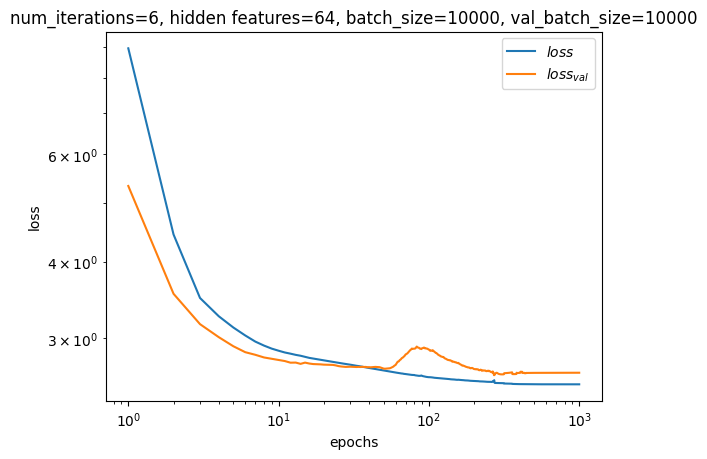

In [8]:
figloss=plt.figure()
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.title('num_iterations={}, hidden features={}, batch_size={}, val_batch_size={}'.format(6,64,batch_size,val_batch_size))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison_noQuantile.png',dpi=190)

In [ ]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)
flow.load_state_dict(torch.load('modelli/epoch=999modello-NoQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth'))
flow.eval()

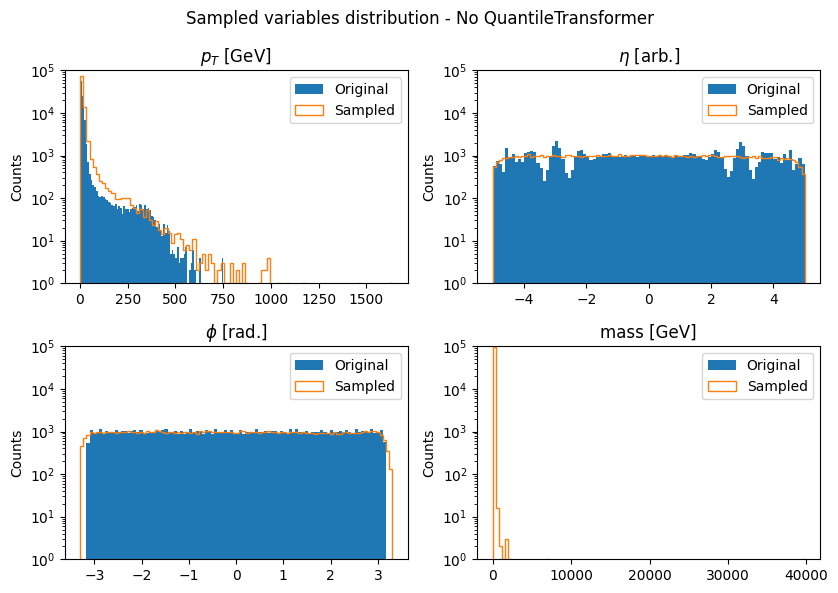

In [ ]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution - No QuantileTransformer")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample_noquantile.pdf',dpi=190)

In [ ]:
x_compressor = Compressor(flow=flow, N=13, limit=3)
x_compressed, gaus, unif = x_compressor.compress(xt)
x_decompressed, gaus_post = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio with no QuantileTransformer =',size_input/size_compressed)

Size of input file = 5.159041404724121 MB
Size of output file = 3.63362979888916 MB
Size of compressed file = 1.7537651062011719 MB
Compression ratio with no QuantileTransformer = 2.941694635434453


Qui ora facciamo quantile transformer per tutte e quattro

In [10]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest_all = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}\n'.format(L))

x = x[:int(L/2),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest_all = xtest_all[:,0:num_features]

print('Events = {}\n'.format(len(x)))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([0,3]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Number of events in all the training dataset = 472827

Events = 236413

attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



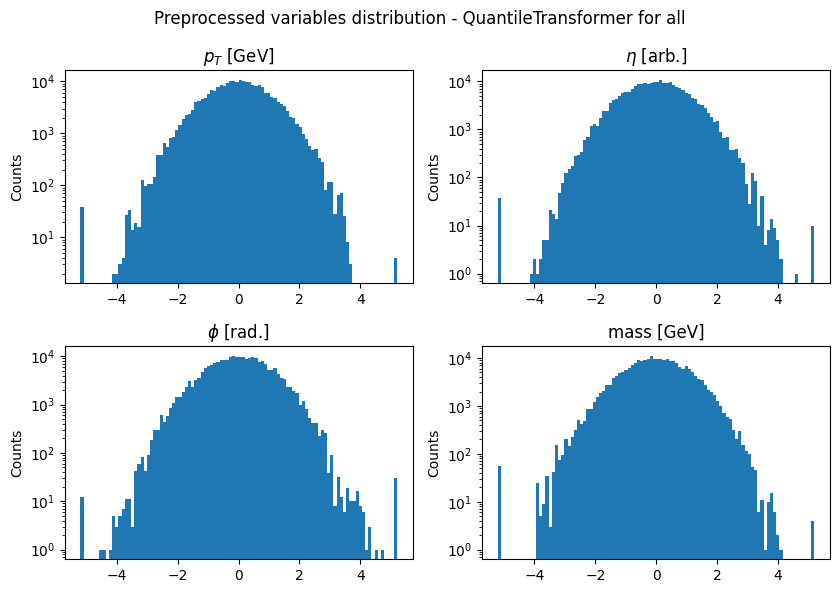

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution - QuantileTransformer for all")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed_for_all_features.pdf',dpi=190)

In [12]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


In [13]:
epochs = 1000
batch_size = 10000
val_batch_size = 10000
delta = 3

counter = 0
loss_values = []
best_val_loss = 10000
loss_validation = []
start = time.time()
for i in range(epochs):
  epoch_loss = 0
  for j in tqdm(range(0,len(xt),batch_size)):
    x_batch = xt[j:j+batch_size]
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_batch).mean()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().detach()

  for param_group in optimizer.param_groups:
    lr = param_group['lr']
  epoch_loss /= (len(xt)//batch_size)
  scheduler.step(metrics=epoch_loss)
  loss_values.append(epoch_loss)

  with torch.no_grad():
    val_loss = 0
    for k in range(0, len(xval),val_batch_size):
      x_batch = xval[j:j+val_batch_size]
      loss_val = -flow.log_prob(inputs=xval).mean().cpu()
      val_loss += loss_val
    val_loss /= (len(xval)//val_batch_size)
    loss_validation.append(val_loss)
    if abs(val_loss-epoch_loss) > delta:
      counter += 1
      print('counter=',counter)
      if counter > 10:
        print('Early stopped')
        break
    print('Epoch: {}, Training loss = {}, Validation loss = {}, Learning rate = {}'.format(i,epoch_loss,val_loss,lr))
  if (i+1) % 100 == 0:
    nome='epoch='+str(i)+'modello-AllQuantile-N_iter'+str(num_iterations)+'-N_features'+str(hidden_features)+'-N_BS'+str(batch_size)+'-epochs'+str(epochs)+'-lr'+str(initial_lr)+'.pth'
    torch.save(flow.state_dict(), 'modelli/'+nome)
    print('Model saved')


end = time.time()
print('Time = {:0.05} s'.format(end-start))

100%|██████████| 24/24 [00:00<00:00, 79.16it/s]


counter= 1
Epoch: 0, Training loss = 9.553055763244629, Validation loss = 5.8629913330078125, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.57it/s]


Epoch: 1, Training loss = 4.901596546173096, Validation loss = 4.662677764892578, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.25it/s]


Epoch: 2, Training loss = 4.328847885131836, Validation loss = 4.4803547859191895, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.87it/s]


Epoch: 3, Training loss = 4.225780487060547, Validation loss = 4.441087245941162, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.04it/s]


Epoch: 4, Training loss = 4.158373832702637, Validation loss = 4.419529914855957, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.89it/s]


Epoch: 5, Training loss = 4.102619647979736, Validation loss = 4.371159553527832, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.74it/s]


Epoch: 6, Training loss = 4.055229663848877, Validation loss = 4.350846290588379, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.16it/s]


Epoch: 7, Training loss = 4.021167278289795, Validation loss = 4.329792022705078, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.91it/s]


Epoch: 8, Training loss = 3.9931142330169678, Validation loss = 4.310787677764893, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.22it/s]


Epoch: 9, Training loss = 3.976412534713745, Validation loss = 4.286992073059082, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 28.16it/s]


Epoch: 10, Training loss = 3.963944435119629, Validation loss = 4.286284923553467, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.94it/s]


Epoch: 11, Training loss = 3.952693462371826, Validation loss = 4.291384696960449, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.80it/s]


Epoch: 12, Training loss = 3.9436964988708496, Validation loss = 4.296631336212158, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 68.27it/s]


Epoch: 13, Training loss = 3.933911085128784, Validation loss = 4.28637170791626, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 38.24it/s]


Epoch: 14, Training loss = 3.924888849258423, Validation loss = 4.279331684112549, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.68it/s]


Epoch: 15, Training loss = 3.918513536453247, Validation loss = 4.279914855957031, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 83.76it/s]


Epoch: 16, Training loss = 3.9122586250305176, Validation loss = 4.274787902832031, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.90it/s]


Epoch: 17, Training loss = 3.9047772884368896, Validation loss = 4.264571666717529, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.01it/s]


Epoch: 18, Training loss = 3.8987843990325928, Validation loss = 4.255712985992432, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.28it/s]


Epoch: 19, Training loss = 3.893383264541626, Validation loss = 4.247823238372803, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.52it/s]


Epoch: 20, Training loss = 3.8881418704986572, Validation loss = 4.238795280456543, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.21it/s]


Epoch: 21, Training loss = 3.8831026554107666, Validation loss = 4.229001045227051, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.03it/s]


Epoch: 22, Training loss = 3.8784332275390625, Validation loss = 4.220780372619629, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.54it/s]


Epoch: 23, Training loss = 3.874346971511841, Validation loss = 4.213607311248779, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.43it/s]


Epoch: 24, Training loss = 3.8705577850341797, Validation loss = 4.2099714279174805, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.59it/s]


Epoch: 25, Training loss = 3.8668830394744873, Validation loss = 4.207978248596191, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.69it/s]


Epoch: 26, Training loss = 3.863419532775879, Validation loss = 4.206076622009277, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 69.40it/s]


Epoch: 27, Training loss = 3.8604769706726074, Validation loss = 4.203108787536621, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.61it/s]


Epoch: 28, Training loss = 3.8575522899627686, Validation loss = 4.2019782066345215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.24it/s]


Epoch: 29, Training loss = 3.8546946048736572, Validation loss = 4.199903964996338, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.70it/s]


Epoch: 30, Training loss = 3.8521840572357178, Validation loss = 4.198720455169678, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.44it/s]


Epoch: 31, Training loss = 3.849308729171753, Validation loss = 4.1974992752075195, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.47it/s]


Epoch: 32, Training loss = 3.846520185470581, Validation loss = 4.19601583480835, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.83it/s]


Epoch: 33, Training loss = 3.844369649887085, Validation loss = 4.194587230682373, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 55.69it/s]


Epoch: 34, Training loss = 3.8422446250915527, Validation loss = 4.195591449737549, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.20it/s]


Epoch: 35, Training loss = 3.839935064315796, Validation loss = 4.196254730224609, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 36, Training loss = 3.8378047943115234, Validation loss = 4.19845724105835, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.19it/s]


Epoch: 37, Training loss = 3.8363351821899414, Validation loss = 4.20431661605835, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.50it/s]


Epoch: 38, Training loss = 3.83549427986145, Validation loss = 4.2165608406066895, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.22it/s]


Epoch: 39, Training loss = 3.834641456604004, Validation loss = 4.226177215576172, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 59.72it/s]


Epoch: 40, Training loss = 3.8311431407928467, Validation loss = 4.217374801635742, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.20it/s]


Epoch: 41, Training loss = 3.82832670211792, Validation loss = 4.215610980987549, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.37it/s]


Epoch: 42, Training loss = 3.828089475631714, Validation loss = 4.219241142272949, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.23it/s]


Epoch: 43, Training loss = 3.827453374862671, Validation loss = 4.220949172973633, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.50it/s]


Epoch: 44, Training loss = 3.825143575668335, Validation loss = 4.21755313873291, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.17it/s]


Epoch: 45, Training loss = 3.823429822921753, Validation loss = 4.2154541015625, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.62it/s]


Epoch: 46, Training loss = 3.8228163719177246, Validation loss = 4.21577262878418, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.86it/s]


Epoch: 47, Training loss = 3.822049617767334, Validation loss = 4.217013835906982, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.81it/s]


Epoch: 48, Training loss = 3.82110857963562, Validation loss = 4.2167205810546875, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.30it/s]


Epoch: 49, Training loss = 3.8201725482940674, Validation loss = 4.215754508972168, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch: 50, Training loss = 3.8191535472869873, Validation loss = 4.214053153991699, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 72.60it/s]


Epoch: 51, Training loss = 3.818227767944336, Validation loss = 4.213542938232422, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.19it/s]


Epoch: 52, Training loss = 3.81734561920166, Validation loss = 4.2131452560424805, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 58.22it/s]


Epoch: 53, Training loss = 3.816704750061035, Validation loss = 4.2130022048950195, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.18it/s]


Epoch: 54, Training loss = 3.815951108932495, Validation loss = 4.212819576263428, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.97it/s]


Epoch: 55, Training loss = 3.815114974975586, Validation loss = 4.211649417877197, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.18it/s]


Epoch: 56, Training loss = 3.8144633769989014, Validation loss = 4.212079048156738, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.90it/s]


Epoch: 57, Training loss = 3.813877582550049, Validation loss = 4.2125244140625, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.56it/s]


Epoch: 58, Training loss = 3.8130943775177, Validation loss = 4.210685729980469, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.51it/s]


Epoch: 59, Training loss = 3.8124828338623047, Validation loss = 4.209809303283691, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.86it/s]


Epoch: 60, Training loss = 3.811872959136963, Validation loss = 4.20815896987915, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 64.19it/s]


Epoch: 61, Training loss = 3.8112285137176514, Validation loss = 4.208259105682373, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.69it/s]


Epoch: 62, Training loss = 3.8108718395233154, Validation loss = 4.20840311050415, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.86it/s]


Epoch: 63, Training loss = 3.810375928878784, Validation loss = 4.207525730133057, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.29it/s]


Epoch: 64, Training loss = 3.8099329471588135, Validation loss = 4.207014560699463, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.97it/s]


Epoch: 65, Training loss = 3.809502363204956, Validation loss = 4.207566738128662, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 61.20it/s]


Epoch: 66, Training loss = 3.8090710639953613, Validation loss = 4.206020355224609, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 46.39it/s]


Epoch: 67, Training loss = 3.8087055683135986, Validation loss = 4.205343723297119, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.14it/s]


Epoch: 68, Training loss = 3.8082621097564697, Validation loss = 4.205194473266602, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 69, Training loss = 3.80779767036438, Validation loss = 4.2046427726745605, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.06it/s]


Epoch: 70, Training loss = 3.8074331283569336, Validation loss = 4.205272197723389, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.74it/s]


Epoch: 71, Training loss = 3.8071322441101074, Validation loss = 4.202701091766357, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.99it/s]


Epoch: 72, Training loss = 3.8064661026000977, Validation loss = 4.201832294464111, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 45.94it/s]


Epoch: 73, Training loss = 3.8060302734375, Validation loss = 4.201418399810791, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.43it/s]


Epoch: 74, Training loss = 3.8057682514190674, Validation loss = 4.20159387588501, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.32it/s]


Epoch: 75, Training loss = 3.805591106414795, Validation loss = 4.201237678527832, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.54it/s]


Epoch: 76, Training loss = 3.8051536083221436, Validation loss = 4.201705455780029, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.51it/s]


Epoch: 77, Training loss = 3.804947853088379, Validation loss = 4.201857089996338, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.72it/s]


Epoch: 78, Training loss = 3.8047139644622803, Validation loss = 4.202304840087891, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.80it/s]


Epoch: 79, Training loss = 3.804374933242798, Validation loss = 4.202264308929443, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.17it/s]


Epoch: 80, Training loss = 3.8039729595184326, Validation loss = 4.202110767364502, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.04it/s]


Epoch: 81, Training loss = 3.8036136627197266, Validation loss = 4.201306343078613, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.86it/s]


Epoch: 82, Training loss = 3.803370237350464, Validation loss = 4.201196193695068, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.70it/s]


Epoch: 83, Training loss = 3.803206443786621, Validation loss = 4.201333522796631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 52.26it/s]


Epoch: 84, Training loss = 3.802996873855591, Validation loss = 4.20171594619751, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 62.29it/s]


Epoch: 85, Training loss = 3.8027379512786865, Validation loss = 4.201580047607422, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.65it/s]


Epoch: 86, Training loss = 3.8025379180908203, Validation loss = 4.202101230621338, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.98it/s]


Epoch: 87, Training loss = 3.8022842407226562, Validation loss = 4.202200889587402, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.55it/s]


Epoch: 88, Training loss = 3.8019731044769287, Validation loss = 4.202357292175293, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.15it/s]


Epoch: 89, Training loss = 3.8017096519470215, Validation loss = 4.2021355628967285, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.60it/s]


Epoch: 90, Training loss = 3.8014557361602783, Validation loss = 4.202492713928223, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.62it/s]


Epoch: 91, Training loss = 3.8013994693756104, Validation loss = 4.2023606300354, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.64it/s]


Epoch: 92, Training loss = 3.801112651824951, Validation loss = 4.202761650085449, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.81it/s]


Epoch: 93, Training loss = 3.800955057144165, Validation loss = 4.202270984649658, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.95it/s]


Epoch: 94, Training loss = 3.8006703853607178, Validation loss = 4.202095031738281, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.14it/s]


Epoch: 95, Training loss = 3.8005030155181885, Validation loss = 4.20129919052124, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.57it/s]


Epoch: 96, Training loss = 3.800287961959839, Validation loss = 4.201976776123047, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.65it/s]


Epoch: 97, Training loss = 3.800229549407959, Validation loss = 4.202118396759033, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.71it/s]


Epoch: 98, Training loss = 3.7999370098114014, Validation loss = 4.201212406158447, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.65it/s]


Epoch: 99, Training loss = 3.7996959686279297, Validation loss = 4.200821399688721, Learning rate = 0.001
Model saved


100%|██████████| 24/24 [00:00<00:00, 83.19it/s]


Epoch: 100, Training loss = 3.7994978427886963, Validation loss = 4.200486660003662, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.01it/s]


Epoch: 101, Training loss = 3.799517869949341, Validation loss = 4.2013630867004395, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.85it/s]


Epoch: 102, Training loss = 3.7998578548431396, Validation loss = 4.204768180847168, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch: 103, Training loss = 3.7999064922332764, Validation loss = 4.206890106201172, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.12it/s]


Epoch: 104, Training loss = 3.7996225357055664, Validation loss = 4.208384037017822, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 45.16it/s]


Epoch: 105, Training loss = 3.7993688583374023, Validation loss = 4.208271026611328, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 63.96it/s]


Epoch: 106, Training loss = 3.7993178367614746, Validation loss = 4.208960056304932, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.75it/s]


Epoch: 107, Training loss = 3.799323320388794, Validation loss = 4.2088303565979, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.94it/s]


Epoch: 108, Training loss = 3.798943519592285, Validation loss = 4.206831932067871, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.20it/s]


Epoch: 109, Training loss = 3.7983736991882324, Validation loss = 4.205432891845703, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.64it/s]


Epoch: 110, Training loss = 3.798083543777466, Validation loss = 4.204775810241699, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 62.00it/s]


Epoch: 111, Training loss = 3.7979414463043213, Validation loss = 4.205341339111328, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.65it/s]


Epoch: 112, Training loss = 3.7978107929229736, Validation loss = 4.205221652984619, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.84it/s]


Epoch: 113, Training loss = 3.797710657119751, Validation loss = 4.205080986022949, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.97it/s]


Epoch: 114, Training loss = 3.7975242137908936, Validation loss = 4.204239368438721, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.94it/s]


Epoch: 115, Training loss = 3.7972073554992676, Validation loss = 4.204111576080322, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.42it/s]


Epoch: 116, Training loss = 3.7970926761627197, Validation loss = 4.203796863555908, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.90it/s]


Epoch: 117, Training loss = 3.796945095062256, Validation loss = 4.203215599060059, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.79it/s]


Epoch: 118, Training loss = 3.79673433303833, Validation loss = 4.202907085418701, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.02it/s]


Epoch: 119, Training loss = 3.79663348197937, Validation loss = 4.202604293823242, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.85it/s]


Epoch: 120, Training loss = 3.7963478565216064, Validation loss = 4.202127456665039, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.70it/s]


Epoch: 121, Training loss = 3.7959907054901123, Validation loss = 4.201091766357422, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.20it/s]


Epoch: 122, Training loss = 3.7957236766815186, Validation loss = 4.200495719909668, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.73it/s]


Epoch: 123, Training loss = 3.7956480979919434, Validation loss = 4.200649261474609, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 61.48it/s]


Epoch: 124, Training loss = 3.795621156692505, Validation loss = 4.20058536529541, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.18it/s]


Epoch: 125, Training loss = 3.7957231998443604, Validation loss = 4.202182292938232, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.52it/s]


Epoch: 126, Training loss = 3.7958364486694336, Validation loss = 4.20290994644165, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.24it/s]


Epoch: 127, Training loss = 3.7957756519317627, Validation loss = 4.203259468078613, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 128, Training loss = 3.7954392433166504, Validation loss = 4.20211935043335, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.31it/s]


Epoch: 129, Training loss = 3.7952120304107666, Validation loss = 4.201293468475342, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.88it/s]


Epoch: 130, Training loss = 3.7951736450195312, Validation loss = 4.2020392417907715, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.25it/s]


Epoch: 131, Training loss = 3.7951550483703613, Validation loss = 4.203391075134277, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.93it/s]


Epoch: 132, Training loss = 3.7950692176818848, Validation loss = 4.202652454376221, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.25it/s]


Epoch: 133, Training loss = 3.794619083404541, Validation loss = 4.200733661651611, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.86it/s]


Epoch: 134, Training loss = 3.7943694591522217, Validation loss = 4.199906826019287, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.47it/s]


Epoch: 135, Training loss = 3.79434871673584, Validation loss = 4.200845718383789, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.36it/s]


Epoch: 136, Training loss = 3.7944014072418213, Validation loss = 4.202612400054932, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 58.02it/s]


Epoch: 137, Training loss = 3.7941460609436035, Validation loss = 4.202129364013672, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.18it/s]


Epoch: 138, Training loss = 3.7938687801361084, Validation loss = 4.199770927429199, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.23it/s]


Epoch: 139, Training loss = 3.7935984134674072, Validation loss = 4.199428558349609, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.77it/s]


Epoch: 140, Training loss = 3.7935028076171875, Validation loss = 4.199314594268799, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.40it/s]


Epoch: 141, Training loss = 3.7934556007385254, Validation loss = 4.200312614440918, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.12it/s]


Epoch: 142, Training loss = 3.7933907508850098, Validation loss = 4.2008795738220215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 65.61it/s]


Epoch: 143, Training loss = 3.7934153079986572, Validation loss = 4.201641082763672, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.10it/s]


Epoch: 144, Training loss = 3.7933290004730225, Validation loss = 4.202422142028809, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.88it/s]


Epoch: 145, Training loss = 3.793199300765991, Validation loss = 4.202960968017578, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.53it/s]


Epoch: 146, Training loss = 3.79307222366333, Validation loss = 4.202554225921631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.69it/s]


Epoch: 147, Training loss = 3.792821168899536, Validation loss = 4.200742721557617, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.30it/s]


Epoch: 148, Training loss = 3.792659282684326, Validation loss = 4.200986385345459, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.50it/s]


Epoch: 149, Training loss = 3.7927145957946777, Validation loss = 4.201394081115723, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.37it/s]


Epoch: 150, Training loss = 3.7928197383880615, Validation loss = 4.202453136444092, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.02it/s]


Epoch: 151, Training loss = 3.792710304260254, Validation loss = 4.201603889465332, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.24it/s]


Epoch: 152, Training loss = 3.7923176288604736, Validation loss = 4.1997971534729, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 153, Training loss = 3.79205060005188, Validation loss = 4.198742866516113, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.55it/s]


Epoch: 154, Training loss = 3.79197096824646, Validation loss = 4.199707508087158, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.25it/s]


Epoch: 155, Training loss = 3.792022705078125, Validation loss = 4.199537754058838, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.88it/s]


Epoch: 156, Training loss = 3.7917752265930176, Validation loss = 4.199054718017578, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.74it/s]


Epoch: 157, Training loss = 3.79146409034729, Validation loss = 4.197701454162598, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.55it/s]


Epoch: 158, Training loss = 3.791304588317871, Validation loss = 4.197754383087158, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.10it/s]


Epoch: 159, Training loss = 3.7913224697113037, Validation loss = 4.198093414306641, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.60it/s]


Epoch: 160, Training loss = 3.7913405895233154, Validation loss = 4.198486804962158, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.25it/s]


Epoch: 161, Training loss = 3.791308641433716, Validation loss = 4.1991729736328125, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.66it/s]


Epoch: 162, Training loss = 3.7911086082458496, Validation loss = 4.198220729827881, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.47it/s]


Epoch: 163, Training loss = 3.7909178733825684, Validation loss = 4.1972784996032715, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.99it/s]


Epoch: 164, Training loss = 3.7907471656799316, Validation loss = 4.196747303009033, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 165, Training loss = 3.7907137870788574, Validation loss = 4.197916507720947, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.72it/s]


Epoch: 166, Training loss = 3.790759325027466, Validation loss = 4.198077201843262, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.65it/s]


Epoch: 167, Training loss = 3.790623903274536, Validation loss = 4.197957515716553, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.87it/s]


Epoch: 168, Training loss = 3.790410280227661, Validation loss = 4.197122097015381, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.05it/s]


Epoch: 169, Training loss = 3.7903459072113037, Validation loss = 4.197838306427002, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.57it/s]


Epoch: 170, Training loss = 3.790262222290039, Validation loss = 4.19813346862793, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.38it/s]


Epoch: 171, Training loss = 3.79011607170105, Validation loss = 4.198141098022461, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.51it/s]


Epoch: 172, Training loss = 3.7899506092071533, Validation loss = 4.197085380554199, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.28it/s]


Epoch: 173, Training loss = 3.7898356914520264, Validation loss = 4.196943759918213, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.56it/s]


Epoch: 174, Training loss = 3.789949417114258, Validation loss = 4.197373867034912, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.14it/s]


Epoch: 175, Training loss = 3.7898285388946533, Validation loss = 4.197023868560791, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.74it/s]


Epoch: 176, Training loss = 3.7896804809570312, Validation loss = 4.197183132171631, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 68.93it/s]


Epoch: 177, Training loss = 3.7894210815429688, Validation loss = 4.196387767791748, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 178, Training loss = 3.7892167568206787, Validation loss = 4.196099758148193, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.00it/s]


Epoch: 179, Training loss = 3.7892017364501953, Validation loss = 4.197388172149658, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.03it/s]


Epoch: 180, Training loss = 3.7892403602600098, Validation loss = 4.1973748207092285, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.50it/s]


Epoch: 181, Training loss = 3.7890403270721436, Validation loss = 4.1969499588012695, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 60.72it/s]


Epoch: 182, Training loss = 3.7887766361236572, Validation loss = 4.19638729095459, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 47.23it/s]


Epoch: 183, Training loss = 3.788696527481079, Validation loss = 4.1968488693237305, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.29it/s]


Epoch: 184, Training loss = 3.788708209991455, Validation loss = 4.1973185539245605, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.66it/s]


Epoch: 185, Training loss = 3.788644313812256, Validation loss = 4.197193622589111, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.31it/s]


Epoch: 186, Training loss = 3.788524866104126, Validation loss = 4.198210716247559, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.82it/s]


Epoch: 187, Training loss = 3.7884013652801514, Validation loss = 4.198337078094482, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.96it/s]


Epoch: 188, Training loss = 3.788360834121704, Validation loss = 4.198611259460449, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.44it/s]


Epoch: 189, Training loss = 3.788325548171997, Validation loss = 4.1996917724609375, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.64it/s]


Epoch: 190, Training loss = 3.7884156703948975, Validation loss = 4.200453281402588, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.66it/s]


Epoch: 191, Training loss = 3.7884409427642822, Validation loss = 4.201147556304932, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.35it/s]


Epoch: 192, Training loss = 3.7883784770965576, Validation loss = 4.2014665603637695, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.46it/s]


Epoch: 193, Training loss = 3.788081645965576, Validation loss = 4.199484348297119, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.51it/s]


Epoch: 194, Training loss = 3.78781795501709, Validation loss = 4.199929237365723, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 57.68it/s]


Epoch: 195, Training loss = 3.787825107574463, Validation loss = 4.200660228729248, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 51.83it/s]


Epoch: 196, Training loss = 3.787729263305664, Validation loss = 4.20143985748291, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.30it/s]


Epoch: 197, Training loss = 3.787592649459839, Validation loss = 4.200763702392578, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.84it/s]


Epoch: 198, Training loss = 3.7874670028686523, Validation loss = 4.2006964683532715, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.78it/s]


Epoch: 199, Training loss = 3.7874443531036377, Validation loss = 4.20089864730835, Learning rate = 0.001
Model saved


100%|██████████| 24/24 [00:00<00:00, 80.79it/s]


Epoch: 200, Training loss = 3.7873830795288086, Validation loss = 4.202535629272461, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.08it/s]


Epoch: 201, Training loss = 3.7873189449310303, Validation loss = 4.202979564666748, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.28it/s]


Epoch: 202, Training loss = 3.787039279937744, Validation loss = 4.2027082443237305, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.23it/s]


Epoch: 203, Training loss = 3.786921977996826, Validation loss = 4.203090667724609, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.37it/s]


Epoch: 204, Training loss = 3.7867515087127686, Validation loss = 4.202507019042969, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.18it/s]


Epoch: 205, Training loss = 3.786612033843994, Validation loss = 4.202882766723633, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.84it/s]


Epoch: 206, Training loss = 3.786616563796997, Validation loss = 4.203726768493652, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.12it/s]


Epoch: 207, Training loss = 3.786806106567383, Validation loss = 4.205508232116699, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 55.55it/s]


Epoch: 208, Training loss = 3.786851644515991, Validation loss = 4.2064900398254395, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.05it/s]


Epoch: 209, Training loss = 3.7867119312286377, Validation loss = 4.205965042114258, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.75it/s]


Epoch: 210, Training loss = 3.7864716053009033, Validation loss = 4.2050089836120605, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.75it/s]


Epoch: 211, Training loss = 3.7865474224090576, Validation loss = 4.205755710601807, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.83it/s]


Epoch: 212, Training loss = 3.786560297012329, Validation loss = 4.205852508544922, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.45it/s]


Epoch: 213, Training loss = 3.786456823348999, Validation loss = 4.206009387969971, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 54.31it/s]


Epoch: 214, Training loss = 3.7863149642944336, Validation loss = 4.203976631164551, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 50.95it/s]


Epoch: 215, Training loss = 3.786102294921875, Validation loss = 4.20408821105957, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.51it/s]


Epoch: 216, Training loss = 3.7860617637634277, Validation loss = 4.204372406005859, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.42it/s]


Epoch: 217, Training loss = 3.786118268966675, Validation loss = 4.2057414054870605, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.36it/s]


Epoch: 218, Training loss = 3.7861549854278564, Validation loss = 4.204046249389648, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.85it/s]


Epoch: 219, Training loss = 3.785940408706665, Validation loss = 4.204761981964111, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.86it/s]


Epoch: 220, Training loss = 3.7859914302825928, Validation loss = 4.20521354675293, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 53.70it/s]


Epoch: 221, Training loss = 3.786085367202759, Validation loss = 4.205741882324219, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.86it/s]


Epoch: 222, Training loss = 3.785935401916504, Validation loss = 4.203527927398682, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.36it/s]


Epoch: 223, Training loss = 3.785705804824829, Validation loss = 4.20335054397583, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.39it/s]


Epoch: 224, Training loss = 3.785607099533081, Validation loss = 4.202437877655029, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 225, Training loss = 3.785576581954956, Validation loss = 4.202471733093262, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.81it/s]


Epoch: 226, Training loss = 3.785473585128784, Validation loss = 4.2005133628845215, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 58.03it/s]


Epoch: 227, Training loss = 3.785323143005371, Validation loss = 4.200150966644287, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.18it/s]


Epoch: 228, Training loss = 3.7851853370666504, Validation loss = 4.199341297149658, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.41it/s]


Epoch: 229, Training loss = 3.7851357460021973, Validation loss = 4.199515342712402, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.69it/s]


Epoch: 230, Training loss = 3.7850594520568848, Validation loss = 4.199422359466553, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 82.26it/s]


Epoch: 231, Training loss = 3.78491473197937, Validation loss = 4.197949409484863, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 81.74it/s]


Epoch: 232, Training loss = 3.78486967086792, Validation loss = 4.198090553283691, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 75.76it/s]


Epoch: 233, Training loss = 3.784804344177246, Validation loss = 4.1979241371154785, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 49.72it/s]


Epoch: 234, Training loss = 3.7847957611083984, Validation loss = 4.198104381561279, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 62.98it/s]


Epoch: 235, Training loss = 3.784834146499634, Validation loss = 4.198075294494629, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.16it/s]


Epoch: 236, Training loss = 3.784740924835205, Validation loss = 4.196870803833008, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 80.38it/s]


Epoch: 237, Training loss = 3.7846732139587402, Validation loss = 4.197772979736328, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.95it/s]


Epoch: 238, Training loss = 3.7846949100494385, Validation loss = 4.195940971374512, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 79.76it/s]


Epoch: 239, Training loss = 3.7846484184265137, Validation loss = 4.195441722869873, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 56.90it/s]


Epoch: 240, Training loss = 3.7847814559936523, Validation loss = 4.1944661140441895, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 48.43it/s]


Epoch: 241, Training loss = 3.784903049468994, Validation loss = 4.193133354187012, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 78.48it/s]


Epoch: 242, Training loss = 3.78503155708313, Validation loss = 4.190247058868408, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 77.17it/s]


Epoch: 243, Training loss = 3.779301881790161, Validation loss = 4.194835662841797, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 74.41it/s]


Epoch: 244, Training loss = 3.7787935733795166, Validation loss = 4.202685356140137, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 245, Training loss = 3.7783889770507812, Validation loss = 4.201145648956299, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.77it/s]


Epoch: 246, Training loss = 3.7781734466552734, Validation loss = 4.202046871185303, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 52.79it/s]


Epoch: 247, Training loss = 3.7781598567962646, Validation loss = 4.202033519744873, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.63it/s]


Epoch: 248, Training loss = 3.778198003768921, Validation loss = 4.2033610343933105, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.76it/s]


Epoch: 249, Training loss = 3.7782692909240723, Validation loss = 4.204164981842041, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 79.58it/s]


Epoch: 250, Training loss = 3.7783048152923584, Validation loss = 4.204218864440918, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.59it/s]


Epoch: 251, Training loss = 3.7783162593841553, Validation loss = 4.204469680786133, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 81.41it/s]


Epoch: 252, Training loss = 3.7783167362213135, Validation loss = 4.203965663909912, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 61.71it/s]


Epoch: 253, Training loss = 3.778256893157959, Validation loss = 4.2031707763671875, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 48.10it/s]


Epoch: 254, Training loss = 3.7781870365142822, Validation loss = 4.202533721923828, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 76.73it/s]


Epoch: 255, Training loss = 3.7781379222869873, Validation loss = 4.202215671539307, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 78.38it/s]


Epoch: 256, Training loss = 3.7781126499176025, Validation loss = 4.201840877532959, Learning rate = 0.0005


100%|██████████| 24/24 [00:00<00:00, 80.09it/s]


Epoch: 257, Training loss = 3.7755985260009766, Validation loss = 4.179080486297607, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.07it/s]


Epoch: 258, Training loss = 3.7748475074768066, Validation loss = 4.185092926025391, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.33it/s]


Epoch: 259, Training loss = 3.77470064163208, Validation loss = 4.18462610244751, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 51.90it/s]


Epoch: 260, Training loss = 3.7746732234954834, Validation loss = 4.184731960296631, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 81.10it/s]


Epoch: 261, Training loss = 3.77461838722229, Validation loss = 4.1851959228515625, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.31it/s]


Epoch: 262, Training loss = 3.77457857131958, Validation loss = 4.185336589813232, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.92it/s]


Epoch: 263, Training loss = 3.77453875541687, Validation loss = 4.185974597930908, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.07it/s]


Epoch: 264, Training loss = 3.7745115756988525, Validation loss = 4.186108589172363, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 265, Training loss = 3.7744648456573486, Validation loss = 4.186788558959961, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 58.06it/s]


Epoch: 266, Training loss = 3.7744476795196533, Validation loss = 4.186675071716309, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 49.40it/s]


Epoch: 267, Training loss = 3.7744216918945312, Validation loss = 4.1872878074646, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.75it/s]


Epoch: 268, Training loss = 3.774392604827881, Validation loss = 4.187391757965088, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 73.23it/s]


Epoch: 269, Training loss = 3.774371862411499, Validation loss = 4.187661170959473, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 78.10it/s]


Epoch: 270, Training loss = 3.7743520736694336, Validation loss = 4.188108444213867, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.03it/s]


Epoch: 271, Training loss = 3.7743422985076904, Validation loss = 4.188291549682617, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 57.95it/s]


Epoch: 272, Training loss = 3.774339199066162, Validation loss = 4.1890788078308105, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 50.75it/s]


Epoch: 273, Training loss = 3.7743377685546875, Validation loss = 4.189192295074463, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 77.36it/s]


Epoch: 274, Training loss = 3.774313449859619, Validation loss = 4.1894636154174805, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 74.04it/s]


Epoch: 275, Training loss = 3.7743020057678223, Validation loss = 4.189548492431641, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 79.76it/s]


Epoch: 276, Training loss = 3.7742955684661865, Validation loss = 4.190081596374512, Learning rate = 0.00025


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 277, Training loss = 3.773838758468628, Validation loss = 4.180506706237793, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.89it/s]


Epoch: 278, Training loss = 3.773961305618286, Validation loss = 4.179111480712891, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 54.35it/s]


Epoch: 279, Training loss = 3.7739531993865967, Validation loss = 4.17930269241333, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 47.62it/s]


Epoch: 280, Training loss = 3.773890256881714, Validation loss = 4.179556846618652, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 281, Training loss = 3.7738418579101562, Validation loss = 4.179881572723389, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.64it/s]


Epoch: 282, Training loss = 3.7738099098205566, Validation loss = 4.1801042556762695, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 78.43it/s]


Epoch: 283, Training loss = 3.773791551589966, Validation loss = 4.180298328399658, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 76.83it/s]


Epoch: 284, Training loss = 3.7737772464752197, Validation loss = 4.180616855621338, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 57.93it/s]


Epoch: 285, Training loss = 3.773761510848999, Validation loss = 4.180822849273682, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 46.48it/s]


Epoch: 286, Training loss = 3.7737538814544678, Validation loss = 4.181053638458252, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.22it/s]


Epoch: 287, Training loss = 3.773740291595459, Validation loss = 4.181083679199219, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.10it/s]


Epoch: 288, Training loss = 3.7737340927124023, Validation loss = 4.181212902069092, Learning rate = 0.000125


100%|██████████| 24/24 [00:00<00:00, 80.50it/s]


Epoch: 289, Training loss = 3.7731263637542725, Validation loss = 4.186389923095703, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 81.18it/s]


Epoch: 290, Training loss = 3.773008346557617, Validation loss = 4.187009334564209, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.35it/s]


Epoch: 291, Training loss = 3.7730026245117188, Validation loss = 4.186915397644043, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 50.36it/s]


Epoch: 292, Training loss = 3.773015260696411, Validation loss = 4.187096118927002, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 61.38it/s]


Epoch: 293, Training loss = 3.7730066776275635, Validation loss = 4.187160015106201, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.12it/s]


Epoch: 294, Training loss = 3.7730002403259277, Validation loss = 4.187129020690918, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.33it/s]


Epoch: 295, Training loss = 3.7729930877685547, Validation loss = 4.187048435211182, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 80.76it/s]


Epoch: 296, Training loss = 3.772979736328125, Validation loss = 4.1868577003479, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 81.47it/s]


Epoch: 297, Training loss = 3.7729594707489014, Validation loss = 4.186746120452881, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 60.36it/s]


Epoch: 298, Training loss = 3.7729384899139404, Validation loss = 4.186468601226807, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 49.00it/s]


Epoch: 299, Training loss = 3.7729265689849854, Validation loss = 4.186379432678223, Learning rate = 6.25e-05
Model saved


100%|██████████| 24/24 [00:00<00:00, 80.64it/s]


Epoch: 300, Training loss = 3.7729101181030273, Validation loss = 4.186267852783203, Learning rate = 6.25e-05


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 301, Training loss = 3.7725908756256104, Validation loss = 4.17797327041626, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 78.12it/s]


Epoch: 302, Training loss = 3.7722270488739014, Validation loss = 4.181075572967529, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 78.82it/s]


Epoch: 303, Training loss = 3.7722742557525635, Validation loss = 4.1802239418029785, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 81.47it/s]


Epoch: 304, Training loss = 3.7722530364990234, Validation loss = 4.180577278137207, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 52.67it/s]


Epoch: 305, Training loss = 3.7722532749176025, Validation loss = 4.18057107925415, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 75.36it/s]


Epoch: 306, Training loss = 3.772249221801758, Validation loss = 4.180634498596191, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 80.42it/s]


Epoch: 307, Training loss = 3.772247076034546, Validation loss = 4.180688381195068, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.78it/s]


Epoch: 308, Training loss = 3.7722442150115967, Validation loss = 4.180744171142578, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 80.31it/s]


Epoch: 309, Training loss = 3.7722396850585938, Validation loss = 4.180799961090088, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.12it/s]


Epoch: 310, Training loss = 3.7722373008728027, Validation loss = 4.180894374847412, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 57.99it/s]


Epoch: 311, Training loss = 3.7722361087799072, Validation loss = 4.180927276611328, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 46.33it/s]


Epoch: 312, Training loss = 3.7722320556640625, Validation loss = 4.181012153625488, Learning rate = 3.125e-05


100%|██████████| 24/24 [00:00<00:00, 79.15it/s]


Epoch: 313, Training loss = 3.7720754146575928, Validation loss = 4.179358005523682, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 314, Training loss = 3.772078514099121, Validation loss = 4.17854642868042, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.43it/s]


Epoch: 315, Training loss = 3.772081136703491, Validation loss = 4.178464889526367, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.87it/s]


Epoch: 316, Training loss = 3.7720792293548584, Validation loss = 4.178440570831299, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 61.90it/s]


Epoch: 317, Training loss = 3.7720754146575928, Validation loss = 4.1784820556640625, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 51.93it/s]


Epoch: 318, Training loss = 3.7720727920532227, Validation loss = 4.1784987449646, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.58it/s]


Epoch: 319, Training loss = 3.7720694541931152, Validation loss = 4.178562641143799, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 76.47it/s]


Epoch: 320, Training loss = 3.772066116333008, Validation loss = 4.178599834442139, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 79.21it/s]


Epoch: 321, Training loss = 3.7720634937286377, Validation loss = 4.178642749786377, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.51it/s]


Epoch: 322, Training loss = 3.7720608711242676, Validation loss = 4.1786603927612305, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 78.28it/s]


Epoch: 323, Training loss = 3.7720584869384766, Validation loss = 4.178679943084717, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 54.10it/s]


Epoch: 324, Training loss = 3.772055149078369, Validation loss = 4.17872953414917, Learning rate = 1.5625e-05


100%|██████████| 24/24 [00:00<00:00, 48.52it/s]


Epoch: 325, Training loss = 3.771982192993164, Validation loss = 4.179931163787842, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.33it/s]


Epoch: 326, Training loss = 3.7719812393188477, Validation loss = 4.180462837219238, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 78.14it/s]


Epoch: 327, Training loss = 3.771975040435791, Validation loss = 4.180522918701172, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 75.16it/s]


Epoch: 328, Training loss = 3.771972417831421, Validation loss = 4.180465221405029, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.59it/s]


Epoch: 329, Training loss = 3.7719709873199463, Validation loss = 4.180423259735107, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 53.82it/s]


Epoch: 330, Training loss = 3.771970748901367, Validation loss = 4.1804118156433105, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 46.01it/s]


Epoch: 331, Training loss = 3.77197003364563, Validation loss = 4.180399417877197, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.26it/s]


Epoch: 332, Training loss = 3.7719690799713135, Validation loss = 4.180369853973389, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.03it/s]


Epoch: 333, Training loss = 3.771968126296997, Validation loss = 4.180347919464111, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 79.14it/s]


Epoch: 334, Training loss = 3.771967649459839, Validation loss = 4.180327415466309, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 76.82it/s]


Epoch: 335, Training loss = 3.7719664573669434, Validation loss = 4.1803059577941895, Learning rate = 7.8125e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 336, Training loss = 3.771918535232544, Validation loss = 4.181547164916992, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 49.50it/s]


Epoch: 337, Training loss = 3.771911382675171, Validation loss = 4.1812849044799805, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 52.07it/s]


Epoch: 338, Training loss = 3.7719106674194336, Validation loss = 4.181354522705078, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.05it/s]


Epoch: 339, Training loss = 3.771909236907959, Validation loss = 4.181349277496338, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 80.85it/s]


Epoch: 340, Training loss = 3.771909236907959, Validation loss = 4.181347846984863, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 80.76it/s]


Epoch: 341, Training loss = 3.7719082832336426, Validation loss = 4.181358814239502, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 80.50it/s]


Epoch: 342, Training loss = 3.7719080448150635, Validation loss = 4.181356906890869, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 57.12it/s]


Epoch: 343, Training loss = 3.771907329559326, Validation loss = 4.181357383728027, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 50.13it/s]


Epoch: 344, Training loss = 3.771907091140747, Validation loss = 4.181358814239502, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.89it/s]


Epoch: 345, Training loss = 3.7719063758850098, Validation loss = 4.181356906890869, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.93it/s]


Epoch: 346, Training loss = 3.7719063758850098, Validation loss = 4.181354522705078, Learning rate = 3.90625e-06


100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch: 347, Training loss = 3.771883726119995, Validation loss = 4.1815056800842285, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 348, Training loss = 3.771883010864258, Validation loss = 4.181548595428467, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 349, Training loss = 3.7718825340270996, Validation loss = 4.181539058685303, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 50.16it/s]


Epoch: 350, Training loss = 3.7718820571899414, Validation loss = 4.181545257568359, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 63.38it/s]


Epoch: 351, Training loss = 3.7718820571899414, Validation loss = 4.181550025939941, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 78.52it/s]


Epoch: 352, Training loss = 3.7718818187713623, Validation loss = 4.181545257568359, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 76.71it/s]


Epoch: 353, Training loss = 3.771881341934204, Validation loss = 4.181549549102783, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 79.48it/s]


Epoch: 354, Training loss = 3.771881103515625, Validation loss = 4.181553363800049, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 80.58it/s]


Epoch: 355, Training loss = 3.771881103515625, Validation loss = 4.181553363800049, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 56.85it/s]


Epoch: 356, Training loss = 3.7718803882598877, Validation loss = 4.18154764175415, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 47.86it/s]


Epoch: 357, Training loss = 3.7718801498413086, Validation loss = 4.181555271148682, Learning rate = 1.953125e-06


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 358, Training loss = 3.7718698978424072, Validation loss = 4.181563377380371, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.10it/s]


Epoch: 359, Training loss = 3.77186918258667, Validation loss = 4.181596279144287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 360, Training loss = 3.771868944168091, Validation loss = 4.181605815887451, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.40it/s]


Epoch: 361, Training loss = 3.771868944168091, Validation loss = 4.181611061096191, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.65it/s]


Epoch: 362, Training loss = 3.771868944168091, Validation loss = 4.181612014770508, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.52it/s]


Epoch: 363, Training loss = 3.771868944168091, Validation loss = 4.18161678314209, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.78it/s]


Epoch: 364, Training loss = 3.771868944168091, Validation loss = 4.181619167327881, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.53it/s]


Epoch: 365, Training loss = 3.771868944168091, Validation loss = 4.181619167327881, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 35.13it/s]


Epoch: 366, Training loss = 3.7718682289123535, Validation loss = 4.181621551513672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 367, Training loss = 3.7718682289123535, Validation loss = 4.181619644165039, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.89it/s]


Epoch: 368, Training loss = 3.7718682289123535, Validation loss = 4.181621551513672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.91it/s]


Epoch: 369, Training loss = 3.7718682289123535, Validation loss = 4.181626796722412, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.56it/s]


Epoch: 370, Training loss = 3.7718677520751953, Validation loss = 4.18162202835083, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.69it/s]


Epoch: 371, Training loss = 3.771867513656616, Validation loss = 4.1816253662109375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.04it/s]


Epoch: 372, Training loss = 3.771867513656616, Validation loss = 4.181628227233887, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.90it/s]


Epoch: 373, Training loss = 3.771867513656616, Validation loss = 4.1816253662109375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.10it/s]


Epoch: 374, Training loss = 3.771866798400879, Validation loss = 4.181629180908203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.84it/s]


Epoch: 375, Training loss = 3.7718660831451416, Validation loss = 4.1816277503967285, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.71it/s]


Epoch: 376, Training loss = 3.7718658447265625, Validation loss = 4.1816253662109375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.11it/s]


Epoch: 377, Training loss = 3.7718660831451416, Validation loss = 4.181629657745361, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.92it/s]


Epoch: 378, Training loss = 3.7718658447265625, Validation loss = 4.181628227233887, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.35it/s]


Epoch: 379, Training loss = 3.7718658447265625, Validation loss = 4.1816325187683105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.32it/s]


Epoch: 380, Training loss = 3.7718656063079834, Validation loss = 4.181629657745361, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.02it/s]


Epoch: 381, Training loss = 3.771865129470825, Validation loss = 4.181633472442627, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.88it/s]


Epoch: 382, Training loss = 3.771865129470825, Validation loss = 4.181632995605469, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.17it/s]


Epoch: 383, Training loss = 3.771864891052246, Validation loss = 4.181632995605469, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.09it/s]


Epoch: 384, Training loss = 3.771864414215088, Validation loss = 4.181634426116943, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.51it/s]


Epoch: 385, Training loss = 3.771864414215088, Validation loss = 4.181634426116943, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.36it/s]


Epoch: 386, Training loss = 3.771864414215088, Validation loss = 4.18163537979126, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.54it/s]


Epoch: 387, Training loss = 3.771864414215088, Validation loss = 4.181635856628418, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.30it/s]


Epoch: 388, Training loss = 3.771864175796509, Validation loss = 4.181632995605469, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.57it/s]


Epoch: 389, Training loss = 3.7718639373779297, Validation loss = 4.181635856628418, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.96it/s]


Epoch: 390, Training loss = 3.7718639373779297, Validation loss = 4.181637287139893, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.61it/s]


Epoch: 391, Training loss = 3.7718632221221924, Validation loss = 4.181635856628418, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.52it/s]


Epoch: 392, Training loss = 3.7718632221221924, Validation loss = 4.181635856628418, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.52it/s]


Epoch: 393, Training loss = 3.771862745285034, Validation loss = 4.181637763977051, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.24it/s]


Epoch: 394, Training loss = 3.771862268447876, Validation loss = 4.181637763977051, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.33it/s]


Epoch: 395, Training loss = 3.771862268447876, Validation loss = 4.181641101837158, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.66it/s]


Epoch: 396, Training loss = 3.771862268447876, Validation loss = 4.181637287139893, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.64it/s]


Epoch: 397, Training loss = 3.771862268447876, Validation loss = 4.181642532348633, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.24it/s]


Epoch: 398, Training loss = 3.7718615531921387, Validation loss = 4.181643009185791, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.42it/s]


Epoch: 399, Training loss = 3.7718615531921387, Validation loss = 4.181642532348633, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 78.59it/s]


Epoch: 400, Training loss = 3.7718615531921387, Validation loss = 4.181643962860107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.71it/s]


Epoch: 401, Training loss = 3.7718613147735596, Validation loss = 4.181642532348633, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.32it/s]


Epoch: 402, Training loss = 3.7718608379364014, Validation loss = 4.181643962860107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.35it/s]


Epoch: 403, Training loss = 3.7718605995178223, Validation loss = 4.181642532348633, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch: 404, Training loss = 3.7718605995178223, Validation loss = 4.181643486022949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 405, Training loss = 3.7718605995178223, Validation loss = 4.1816487312316895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 82.51it/s]


Epoch: 406, Training loss = 3.771859884262085, Validation loss = 4.181643009185791, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch: 407, Training loss = 3.771860122680664, Validation loss = 4.181645393371582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.53it/s]


Epoch: 408, Training loss = 3.771859884262085, Validation loss = 4.181643962860107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.11it/s]


Epoch: 409, Training loss = 3.771859645843506, Validation loss = 4.181650638580322, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.46it/s]


Epoch: 410, Training loss = 3.771859645843506, Validation loss = 4.181645393371582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.54it/s]


Epoch: 411, Training loss = 3.771859884262085, Validation loss = 4.181652069091797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.95it/s]


Epoch: 412, Training loss = 3.771859645843506, Validation loss = 4.1816487312316895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.87it/s]


Epoch: 413, Training loss = 3.7718589305877686, Validation loss = 4.181652069091797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.33it/s]


Epoch: 414, Training loss = 3.7718589305877686, Validation loss = 4.181650638580322, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.00it/s]


Epoch: 415, Training loss = 3.7718584537506104, Validation loss = 4.181650638580322, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.32it/s]


Epoch: 416, Training loss = 3.7718582153320312, Validation loss = 4.1816511154174805, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.08it/s]


Epoch: 417, Training loss = 3.771857500076294, Validation loss = 4.1816487312316895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.17it/s]


Epoch: 418, Training loss = 3.771857261657715, Validation loss = 4.1816487312316895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.39it/s]


Epoch: 419, Training loss = 3.771857261657715, Validation loss = 4.18165397644043, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.33it/s]


Epoch: 420, Training loss = 3.7718567848205566, Validation loss = 4.181645393371582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.40it/s]


Epoch: 421, Training loss = 3.7718563079833984, Validation loss = 4.181656837463379, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.71it/s]


Epoch: 422, Training loss = 3.7718563079833984, Validation loss = 4.1816534996032715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.32it/s]


Epoch: 423, Training loss = 3.771855592727661, Validation loss = 4.1816534996032715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.38it/s]


Epoch: 424, Training loss = 3.771855592727661, Validation loss = 4.181652069091797, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.59it/s]


Epoch: 425, Training loss = 3.771855592727661, Validation loss = 4.18165922164917, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.19it/s]


Epoch: 426, Training loss = 3.771855592727661, Validation loss = 4.181658744812012, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.85it/s]


Epoch: 427, Training loss = 3.771854877471924, Validation loss = 4.181664943695068, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.83it/s]


Epoch: 428, Training loss = 3.771854877471924, Validation loss = 4.181657314300537, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.54it/s]


Epoch: 429, Training loss = 3.771854877471924, Validation loss = 4.181661605834961, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.95it/s]


Epoch: 430, Training loss = 3.7718546390533447, Validation loss = 4.181661128997803, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.12it/s]


Epoch: 431, Training loss = 3.7718546390533447, Validation loss = 4.18166446685791, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.94it/s]


Epoch: 432, Training loss = 3.7718541622161865, Validation loss = 4.181664943695068, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.30it/s]


Epoch: 433, Training loss = 3.7718539237976074, Validation loss = 4.181667804718018, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.81it/s]


Epoch: 434, Training loss = 3.7718536853790283, Validation loss = 4.181664943695068, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.99it/s]


Epoch: 435, Training loss = 3.771852970123291, Validation loss = 4.181667804718018, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.92it/s]


Epoch: 436, Training loss = 3.771852970123291, Validation loss = 4.18166971206665, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.79it/s]


Epoch: 437, Training loss = 3.771852970123291, Validation loss = 4.181666851043701, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.45it/s]


Epoch: 438, Training loss = 3.7718522548675537, Validation loss = 4.181675434112549, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.17it/s]


Epoch: 439, Training loss = 3.7718522548675537, Validation loss = 4.18166971206665, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.64it/s]


Epoch: 440, Training loss = 3.7718522548675537, Validation loss = 4.1816725730896, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.62it/s]


Epoch: 441, Training loss = 3.7718520164489746, Validation loss = 4.181677341461182, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.41it/s]


Epoch: 442, Training loss = 3.7718520164489746, Validation loss = 4.1816725730896, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.18it/s]


Epoch: 443, Training loss = 3.7718520164489746, Validation loss = 4.181681156158447, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.74it/s]


Epoch: 444, Training loss = 3.7718515396118164, Validation loss = 4.181677341461182, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.39it/s]


Epoch: 445, Training loss = 3.771850824356079, Validation loss = 4.181674480438232, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.21it/s]


Epoch: 446, Training loss = 3.771850824356079, Validation loss = 4.181680679321289, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.37it/s]


Epoch: 447, Training loss = 3.771850824356079, Validation loss = 4.181681156158447, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.62it/s]


Epoch: 448, Training loss = 3.7718505859375, Validation loss = 4.181675910949707, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.84it/s]


Epoch: 449, Training loss = 3.771850347518921, Validation loss = 4.181683540344238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.20it/s]


Epoch: 450, Training loss = 3.771850347518921, Validation loss = 4.181680202484131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.86it/s]


Epoch: 451, Training loss = 3.7718498706817627, Validation loss = 4.181683540344238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.91it/s]


Epoch: 452, Training loss = 3.7718496322631836, Validation loss = 4.181682586669922, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.39it/s]


Epoch: 453, Training loss = 3.7718489170074463, Validation loss = 4.181682586669922, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 454, Training loss = 3.7718489170074463, Validation loss = 4.181684970855713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.31it/s]


Epoch: 455, Training loss = 3.7718489170074463, Validation loss = 4.181685447692871, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.06it/s]


Epoch: 456, Training loss = 3.771848678588867, Validation loss = 4.1816887855529785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.53it/s]


Epoch: 457, Training loss = 3.77184796333313, Validation loss = 4.1816887855529785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.82it/s]


Epoch: 458, Training loss = 3.77184796333313, Validation loss = 4.181683540344238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.99it/s]


Epoch: 459, Training loss = 3.7718472480773926, Validation loss = 4.181691646575928, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.87it/s]


Epoch: 460, Training loss = 3.7718465328216553, Validation loss = 4.181683540344238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.36it/s]


Epoch: 461, Training loss = 3.7718465328216553, Validation loss = 4.18169641494751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.82it/s]


Epoch: 462, Training loss = 3.7718465328216553, Validation loss = 4.181690216064453, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.34it/s]


Epoch: 463, Training loss = 3.771846294403076, Validation loss = 4.181691646575928, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 464, Training loss = 3.771846055984497, Validation loss = 4.181691646575928, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.98it/s]


Epoch: 465, Training loss = 3.771845579147339, Validation loss = 4.18169641494751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.28it/s]


Epoch: 466, Training loss = 3.7718453407287598, Validation loss = 4.1816911697387695, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.01it/s]


Epoch: 467, Training loss = 3.7718453407287598, Validation loss = 4.181698799133301, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.42it/s]


Epoch: 468, Training loss = 3.7718453407287598, Validation loss = 4.18169641494751, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.64it/s]


Epoch: 469, Training loss = 3.7718446254730225, Validation loss = 4.181701183319092, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.22it/s]


Epoch: 470, Training loss = 3.7718443870544434, Validation loss = 4.181698322296143, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.78it/s]


Epoch: 471, Training loss = 3.7718443870544434, Validation loss = 4.181699752807617, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.70it/s]


Epoch: 472, Training loss = 3.771843910217285, Validation loss = 4.181698799133301, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.61it/s]


Epoch: 473, Training loss = 3.771843194961548, Validation loss = 4.18170690536499, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.12it/s]


Epoch: 474, Training loss = 3.7718429565429688, Validation loss = 4.181701183319092, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.91it/s]


Epoch: 475, Training loss = 3.7718427181243896, Validation loss = 4.181706428527832, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.96it/s]


Epoch: 476, Training loss = 3.7718427181243896, Validation loss = 4.181706428527832, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.46it/s]


Epoch: 477, Training loss = 3.7718422412872314, Validation loss = 4.181707382202148, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.72it/s]


Epoch: 478, Training loss = 3.7718422412872314, Validation loss = 4.18170690536499, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.57it/s]


Epoch: 479, Training loss = 3.7718420028686523, Validation loss = 4.181712627410889, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 480, Training loss = 3.771841526031494, Validation loss = 4.18170690536499, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.99it/s]


Epoch: 481, Training loss = 3.771841287612915, Validation loss = 4.181708812713623, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.66it/s]


Epoch: 482, Training loss = 3.771841287612915, Validation loss = 4.181707382202148, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.36it/s]


Epoch: 483, Training loss = 3.771841049194336, Validation loss = 4.181715488433838, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.66it/s]


Epoch: 484, Training loss = 3.771841049194336, Validation loss = 4.181712627410889, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.83it/s]


Epoch: 485, Training loss = 3.771841049194336, Validation loss = 4.1817145347595215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.00it/s]


Epoch: 486, Training loss = 3.7718403339385986, Validation loss = 4.181715488433838, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.88it/s]


Epoch: 487, Training loss = 3.7718403339385986, Validation loss = 4.181709289550781, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.79it/s]


Epoch: 488, Training loss = 3.7718398571014404, Validation loss = 4.181715488433838, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.33it/s]


Epoch: 489, Training loss = 3.7718396186828613, Validation loss = 4.181714057922363, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.30it/s]


Epoch: 490, Training loss = 3.7718396186828613, Validation loss = 4.181720733642578, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.66it/s]


Epoch: 491, Training loss = 3.7718396186828613, Validation loss = 4.181713104248047, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.73it/s]


Epoch: 492, Training loss = 3.7718393802642822, Validation loss = 4.181717395782471, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.66it/s]


Epoch: 493, Training loss = 3.771838903427124, Validation loss = 4.181715488433838, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.10it/s]


Epoch: 494, Training loss = 3.771838903427124, Validation loss = 4.181720733642578, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch: 495, Training loss = 3.771838665008545, Validation loss = 4.181717395782471, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.00it/s]


Epoch: 496, Training loss = 3.771838426589966, Validation loss = 4.181720733642578, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch: 497, Training loss = 3.7718377113342285, Validation loss = 4.181722640991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.60it/s]


Epoch: 498, Training loss = 3.7718372344970703, Validation loss = 4.181722640991211, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.94it/s]


Epoch: 499, Training loss = 3.771836996078491, Validation loss = 4.181722640991211, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 74.46it/s]


Epoch: 500, Training loss = 3.771836996078491, Validation loss = 4.181725025177002, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.17it/s]


Epoch: 501, Training loss = 3.771836280822754, Validation loss = 4.181723117828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 502, Training loss = 3.771836042404175, Validation loss = 4.181725025177002, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.16it/s]


Epoch: 503, Training loss = 3.7718355655670166, Validation loss = 4.181723117828369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.38it/s]


Epoch: 504, Training loss = 3.7718350887298584, Validation loss = 4.181725025177002, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.53it/s]


Epoch: 505, Training loss = 3.7718350887298584, Validation loss = 4.181730270385742, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 81.24it/s]


Epoch: 506, Training loss = 3.7718346118927, Validation loss = 4.181725025177002, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.00it/s]


Epoch: 507, Training loss = 3.771834373474121, Validation loss = 4.181730270385742, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.11it/s]


Epoch: 508, Training loss = 3.771834373474121, Validation loss = 4.181728839874268, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.63it/s]


Epoch: 509, Training loss = 3.771833896636963, Validation loss = 4.1817307472229, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.56it/s]


Epoch: 510, Training loss = 3.771833896636963, Validation loss = 4.181731700897217, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.47it/s]


Epoch: 511, Training loss = 3.7718334197998047, Validation loss = 4.181731700897217, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.75it/s]


Epoch: 512, Training loss = 3.7718334197998047, Validation loss = 4.181731224060059, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.80it/s]


Epoch: 513, Training loss = 3.7718329429626465, Validation loss = 4.181733131408691, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch: 514, Training loss = 3.7718327045440674, Validation loss = 4.181733131408691, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.22it/s]


Epoch: 515, Training loss = 3.7718327045440674, Validation loss = 4.181731700897217, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.15it/s]


Epoch: 516, Training loss = 3.771832227706909, Validation loss = 4.181741237640381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.47it/s]


Epoch: 517, Training loss = 3.771832227706909, Validation loss = 4.181731700897217, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.48it/s]


Epoch: 518, Training loss = 3.7718312740325928, Validation loss = 4.181738376617432, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.87it/s]


Epoch: 519, Training loss = 3.7718312740325928, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.84it/s]


Epoch: 520, Training loss = 3.7718312740325928, Validation loss = 4.181738376617432, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.03it/s]


Epoch: 521, Training loss = 3.7718310356140137, Validation loss = 4.181736946105957, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.86it/s]


Epoch: 522, Training loss = 3.7718310356140137, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.72it/s]


Epoch: 523, Training loss = 3.7718307971954346, Validation loss = 4.181736469268799, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.21it/s]


Epoch: 524, Training loss = 3.7718300819396973, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.25it/s]


Epoch: 525, Training loss = 3.7718300819396973, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.74it/s]


Epoch: 526, Training loss = 3.771829605102539, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.94it/s]


Epoch: 527, Training loss = 3.77182936668396, Validation loss = 4.181738376617432, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.29it/s]


Epoch: 528, Training loss = 3.77182936668396, Validation loss = 4.181746006011963, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.98it/s]


Epoch: 529, Training loss = 3.771829128265381, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.69it/s]


Epoch: 530, Training loss = 3.7718286514282227, Validation loss = 4.181746482849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.92it/s]


Epoch: 531, Training loss = 3.7718284130096436, Validation loss = 4.18174409866333, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.93it/s]


Epoch: 532, Training loss = 3.7718279361724854, Validation loss = 4.181746482849121, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 533, Training loss = 3.7718276977539062, Validation loss = 4.181739330291748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.70it/s]


Epoch: 534, Training loss = 3.7718276977539062, Validation loss = 4.181741237640381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.32it/s]


Epoch: 535, Training loss = 3.771827459335327, Validation loss = 4.181746959686279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.73it/s]


Epoch: 536, Training loss = 3.771826982498169, Validation loss = 4.181741237640381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.20it/s]


Epoch: 537, Training loss = 3.77182674407959, Validation loss = 4.181748867034912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.92it/s]


Epoch: 538, Training loss = 3.77182674407959, Validation loss = 4.181744575500488, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.52it/s]


Epoch: 539, Training loss = 3.7718262672424316, Validation loss = 4.181748867034912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.24it/s]


Epoch: 540, Training loss = 3.7718260288238525, Validation loss = 4.1817474365234375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.64it/s]


Epoch: 541, Training loss = 3.7718257904052734, Validation loss = 4.181744575500488, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.34it/s]


Epoch: 542, Training loss = 3.7718253135681152, Validation loss = 4.1817522048950195, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.16it/s]


Epoch: 543, Training loss = 3.771824598312378, Validation loss = 4.181746959686279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.72it/s]


Epoch: 544, Training loss = 3.771824359893799, Validation loss = 4.181746959686279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.11it/s]


Epoch: 545, Training loss = 3.771824359893799, Validation loss = 4.181754112243652, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.56it/s]


Epoch: 546, Training loss = 3.771824359893799, Validation loss = 4.181746959686279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.28it/s]


Epoch: 547, Training loss = 3.7718241214752197, Validation loss = 4.181755542755127, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.60it/s]


Epoch: 548, Training loss = 3.7718241214752197, Validation loss = 4.181746959686279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.36it/s]


Epoch: 549, Training loss = 3.7718234062194824, Validation loss = 4.1817522048950195, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.27it/s]


Epoch: 550, Training loss = 3.7718234062194824, Validation loss = 4.181755542755127, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.10it/s]


Epoch: 551, Training loss = 3.7718231678009033, Validation loss = 4.1817545890808105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.15it/s]


Epoch: 552, Training loss = 3.771821975708008, Validation loss = 4.181755065917969, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.03it/s]


Epoch: 553, Training loss = 3.7718214988708496, Validation loss = 4.181754112243652, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.34it/s]


Epoch: 554, Training loss = 3.7718214988708496, Validation loss = 4.181756973266602, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.65it/s]


Epoch: 555, Training loss = 3.7718214988708496, Validation loss = 4.1817545890808105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.12it/s]


Epoch: 556, Training loss = 3.7718210220336914, Validation loss = 4.181756973266602, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.65it/s]


Epoch: 557, Training loss = 3.7718210220336914, Validation loss = 4.181756973266602, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.55it/s]


Epoch: 558, Training loss = 3.7718207836151123, Validation loss = 4.181762218475342, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.31it/s]


Epoch: 559, Training loss = 3.7718207836151123, Validation loss = 4.1817545890808105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.98it/s]


Epoch: 560, Training loss = 3.771820306777954, Validation loss = 4.181762218475342, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.26it/s]


Epoch: 561, Training loss = 3.771820068359375, Validation loss = 4.1817626953125, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.55it/s]


Epoch: 562, Training loss = 3.771819829940796, Validation loss = 4.181756496429443, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.65it/s]


Epoch: 563, Training loss = 3.7718193531036377, Validation loss = 4.181762218475342, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.79it/s]


Epoch: 564, Training loss = 3.7718193531036377, Validation loss = 4.181765079498291, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch: 565, Training loss = 3.7718191146850586, Validation loss = 4.181760311126709, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.92it/s]


Epoch: 566, Training loss = 3.7718191146850586, Validation loss = 4.181765079498291, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.11it/s]


Epoch: 567, Training loss = 3.7718186378479004, Validation loss = 4.181763172149658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.45it/s]


Epoch: 568, Training loss = 3.7718183994293213, Validation loss = 4.181765556335449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.75it/s]


Epoch: 569, Training loss = 3.7718183994293213, Validation loss = 4.181768894195557, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.66it/s]


Epoch: 570, Training loss = 3.7718183994293213, Validation loss = 4.181763172149658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.02it/s]


Epoch: 571, Training loss = 3.771818161010742, Validation loss = 4.181768894195557, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.81it/s]


Epoch: 572, Training loss = 3.771818161010742, Validation loss = 4.181763172149658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 573, Training loss = 3.7718169689178467, Validation loss = 4.181770324707031, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.85it/s]


Epoch: 574, Training loss = 3.7718167304992676, Validation loss = 4.181765079498291, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.13it/s]


Epoch: 575, Training loss = 3.7718160152435303, Validation loss = 4.181768417358398, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.90it/s]


Epoch: 576, Training loss = 3.7718160152435303, Validation loss = 4.181768417358398, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.84it/s]


Epoch: 577, Training loss = 3.7718160152435303, Validation loss = 4.181769847869873, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.07it/s]


Epoch: 578, Training loss = 3.771815061569214, Validation loss = 4.181770324707031, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.87it/s]


Epoch: 579, Training loss = 3.771815061569214, Validation loss = 4.181768417358398, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.66it/s]


Epoch: 580, Training loss = 3.7718148231506348, Validation loss = 4.1817708015441895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.69it/s]


Epoch: 581, Training loss = 3.7718141078948975, Validation loss = 4.181770324707031, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.26it/s]


Epoch: 582, Training loss = 3.7718141078948975, Validation loss = 4.1817708015441895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.77it/s]


Epoch: 583, Training loss = 3.7718138694763184, Validation loss = 4.181771278381348, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.18it/s]


Epoch: 584, Training loss = 3.77181339263916, Validation loss = 4.181769847869873, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.20it/s]


Epoch: 585, Training loss = 3.77181339263916, Validation loss = 4.1817731857299805, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 586, Training loss = 3.771813154220581, Validation loss = 4.181769847869873, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.05it/s]


Epoch: 587, Training loss = 3.7718124389648438, Validation loss = 4.1817731857299805, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.48it/s]


Epoch: 588, Training loss = 3.7718124389648438, Validation loss = 4.181770324707031, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.77it/s]


Epoch: 589, Training loss = 3.7718122005462646, Validation loss = 4.1817779541015625, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch: 590, Training loss = 3.7718122005462646, Validation loss = 4.181772708892822, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.12it/s]


Epoch: 591, Training loss = 3.7718117237091064, Validation loss = 4.18177604675293, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.92it/s]


Epoch: 592, Training loss = 3.7718117237091064, Validation loss = 4.18177604675293, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.47it/s]


Epoch: 593, Training loss = 3.7718117237091064, Validation loss = 4.181776523590088, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.68it/s]


Epoch: 594, Training loss = 3.7718117237091064, Validation loss = 4.18177604675293, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.89it/s]


Epoch: 595, Training loss = 3.7718114852905273, Validation loss = 4.181776523590088, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.07it/s]


Epoch: 596, Training loss = 3.77181077003479, Validation loss = 4.181778907775879, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.61it/s]


Epoch: 597, Training loss = 3.77181077003479, Validation loss = 4.181778430938721, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.94it/s]


Epoch: 598, Training loss = 3.771810531616211, Validation loss = 4.1817779541015625, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.84it/s]


Epoch: 599, Training loss = 3.7718098163604736, Validation loss = 4.181779384613037, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 77.52it/s]


Epoch: 600, Training loss = 3.7718091011047363, Validation loss = 4.181778430938721, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.48it/s]


Epoch: 601, Training loss = 3.7718088626861572, Validation loss = 4.181786060333252, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.97it/s]


Epoch: 602, Training loss = 3.771808385848999, Validation loss = 4.18178129196167, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 603, Training loss = 3.771808385848999, Validation loss = 4.18178129196167, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.22it/s]


Epoch: 604, Training loss = 3.77180814743042, Validation loss = 4.181787014007568, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.34it/s]


Epoch: 605, Training loss = 3.771807909011841, Validation loss = 4.181786060333252, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.22it/s]


Epoch: 606, Training loss = 3.771807909011841, Validation loss = 4.181787014007568, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.27it/s]


Epoch: 607, Training loss = 3.7718074321746826, Validation loss = 4.18179178237915, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.16it/s]


Epoch: 608, Training loss = 3.7718074321746826, Validation loss = 4.181786060333252, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.24it/s]


Epoch: 609, Training loss = 3.7718074321746826, Validation loss = 4.181792259216309, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.87it/s]


Epoch: 610, Training loss = 3.7718074321746826, Validation loss = 4.181788921356201, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.95it/s]


Epoch: 611, Training loss = 3.7718071937561035, Validation loss = 4.181792259216309, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.47it/s]


Epoch: 612, Training loss = 3.7718067169189453, Validation loss = 4.181794166564941, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.78it/s]


Epoch: 613, Training loss = 3.771806478500366, Validation loss = 4.181793689727783, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.52it/s]


Epoch: 614, Training loss = 3.77180552482605, Validation loss = 4.181794166564941, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.28it/s]


Epoch: 615, Training loss = 3.77180552482605, Validation loss = 4.181795120239258, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 80.13it/s]


Epoch: 616, Training loss = 3.7718048095703125, Validation loss = 4.181797027587891, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.34it/s]


Epoch: 617, Training loss = 3.7718045711517334, Validation loss = 4.181795120239258, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.09it/s]


Epoch: 618, Training loss = 3.7718048095703125, Validation loss = 4.181797027587891, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.76it/s]


Epoch: 619, Training loss = 3.771804094314575, Validation loss = 4.181797027587891, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.13it/s]


Epoch: 620, Training loss = 3.771804094314575, Validation loss = 4.181797027587891, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.78it/s]


Epoch: 621, Training loss = 3.771803855895996, Validation loss = 4.181802749633789, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.76it/s]


Epoch: 622, Training loss = 3.771803379058838, Validation loss = 4.181802272796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.48it/s]


Epoch: 623, Training loss = 3.771803140640259, Validation loss = 4.181801795959473, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.30it/s]


Epoch: 624, Training loss = 3.771803140640259, Validation loss = 4.181809902191162, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.88it/s]


Epoch: 625, Training loss = 3.7718029022216797, Validation loss = 4.181802272796631, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.64it/s]


Epoch: 626, Training loss = 3.7718024253845215, Validation loss = 4.18181037902832, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.11it/s]


Epoch: 627, Training loss = 3.7718021869659424, Validation loss = 4.181809902191162, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.54it/s]


Epoch: 628, Training loss = 3.7718021869659424, Validation loss = 4.181807994842529, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.66it/s]


Epoch: 629, Training loss = 3.771801471710205, Validation loss = 4.181809902191162, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.08it/s]


Epoch: 630, Training loss = 3.771801233291626, Validation loss = 4.181812763214111, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.46it/s]


Epoch: 631, Training loss = 3.771801233291626, Validation loss = 4.181809902191162, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.72it/s]


Epoch: 632, Training loss = 3.7718007564544678, Validation loss = 4.181812763214111, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.14it/s]


Epoch: 633, Training loss = 3.7718007564544678, Validation loss = 4.1818108558654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.70it/s]


Epoch: 634, Training loss = 3.7718005180358887, Validation loss = 4.18181848526001, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.53it/s]


Epoch: 635, Training loss = 3.7717998027801514, Validation loss = 4.1818108558654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.18it/s]


Epoch: 636, Training loss = 3.7718002796173096, Validation loss = 4.181818962097168, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.52it/s]


Epoch: 637, Training loss = 3.7717995643615723, Validation loss = 4.1818108558654785, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.74it/s]


Epoch: 638, Training loss = 3.771798849105835, Validation loss = 4.181820869445801, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.48it/s]


Epoch: 639, Training loss = 3.771798849105835, Validation loss = 4.181816577911377, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.77it/s]


Epoch: 640, Training loss = 3.771798849105835, Validation loss = 4.181818962097168, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.94it/s]


Epoch: 641, Training loss = 3.7717981338500977, Validation loss = 4.181818962097168, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch: 642, Training loss = 3.7717981338500977, Validation loss = 4.181818008422852, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.10it/s]


Epoch: 643, Training loss = 3.7717978954315186, Validation loss = 4.181818962097168, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.25it/s]


Epoch: 644, Training loss = 3.7717974185943604, Validation loss = 4.181818962097168, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.26it/s]


Epoch: 645, Training loss = 3.7717974185943604, Validation loss = 4.181826591491699, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.90it/s]


Epoch: 646, Training loss = 3.7717974185943604, Validation loss = 4.18181848526001, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.65it/s]


Epoch: 647, Training loss = 3.771796941757202, Validation loss = 4.181826114654541, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.81it/s]


Epoch: 648, Training loss = 3.771796941757202, Validation loss = 4.181824207305908, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.43it/s]


Epoch: 649, Training loss = 3.771796464920044, Validation loss = 4.181824207305908, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 650, Training loss = 3.7717957496643066, Validation loss = 4.181825637817383, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.59it/s]


Epoch: 651, Training loss = 3.7717957496643066, Validation loss = 4.181827068328857, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.49it/s]


Epoch: 652, Training loss = 3.7717957496643066, Validation loss = 4.181824207305908, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.93it/s]


Epoch: 653, Training loss = 3.7717952728271484, Validation loss = 4.181828498840332, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.57it/s]


Epoch: 654, Training loss = 3.7717952728271484, Validation loss = 4.181826591491699, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch: 655, Training loss = 3.771794557571411, Validation loss = 4.181828498840332, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.84it/s]


Epoch: 656, Training loss = 3.771794557571411, Validation loss = 4.181827068328857, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.06it/s]


Epoch: 657, Training loss = 3.771794557571411, Validation loss = 4.181833744049072, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.98it/s]


Epoch: 658, Training loss = 3.771794080734253, Validation loss = 4.181825637817383, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.02it/s]


Epoch: 659, Training loss = 3.771793842315674, Validation loss = 4.181835174560547, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.04it/s]


Epoch: 660, Training loss = 3.771793842315674, Validation loss = 4.181827068328857, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.84it/s]


Epoch: 661, Training loss = 3.7717931270599365, Validation loss = 4.181836128234863, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.45it/s]


Epoch: 662, Training loss = 3.7717931270599365, Validation loss = 4.181828498840332, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.36it/s]


Epoch: 663, Training loss = 3.771791934967041, Validation loss = 4.1818342208862305, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.42it/s]


Epoch: 664, Training loss = 3.771791934967041, Validation loss = 4.1818342208862305, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.51it/s]


Epoch: 665, Training loss = 3.771791934967041, Validation loss = 4.181835174560547, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.54it/s]


Epoch: 666, Training loss = 3.771791458129883, Validation loss = 4.181835174560547, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.54it/s]


Epoch: 667, Training loss = 3.771791458129883, Validation loss = 4.181839466094971, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.76it/s]


Epoch: 668, Training loss = 3.7717909812927246, Validation loss = 4.1818366050720215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.75it/s]


Epoch: 669, Training loss = 3.7717905044555664, Validation loss = 4.18184232711792, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.06it/s]


Epoch: 670, Training loss = 3.7717905044555664, Validation loss = 4.1818366050720215, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.25it/s]


Epoch: 671, Training loss = 3.7717905044555664, Validation loss = 4.181842803955078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.37it/s]


Epoch: 672, Training loss = 3.7717902660369873, Validation loss = 4.181840419769287, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.98it/s]


Epoch: 673, Training loss = 3.771789789199829, Validation loss = 4.181842803955078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.58it/s]


Epoch: 674, Training loss = 3.77178955078125, Validation loss = 4.181842803955078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.45it/s]


Epoch: 675, Training loss = 3.77178955078125, Validation loss = 4.181848049163818, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.07it/s]


Epoch: 676, Training loss = 3.7717888355255127, Validation loss = 4.181842803955078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.60it/s]


Epoch: 677, Training loss = 3.7717888355255127, Validation loss = 4.181850433349609, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.87it/s]


Epoch: 678, Training loss = 3.7717881202697754, Validation loss = 4.181842803955078, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.21it/s]


Epoch: 679, Training loss = 3.7717881202697754, Validation loss = 4.181849956512451, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.35it/s]


Epoch: 680, Training loss = 3.7717878818511963, Validation loss = 4.181849956512451, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.16it/s]


Epoch: 681, Training loss = 3.771787643432617, Validation loss = 4.181850433349609, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.69it/s]


Epoch: 682, Training loss = 3.771787166595459, Validation loss = 4.181850433349609, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.46it/s]


Epoch: 683, Training loss = 3.771787166595459, Validation loss = 4.181850910186768, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.51it/s]


Epoch: 684, Training loss = 3.77178692817688, Validation loss = 4.181849479675293, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.88it/s]


Epoch: 685, Training loss = 3.7717864513397217, Validation loss = 4.181850910186768, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.20it/s]


Epoch: 686, Training loss = 3.7717859745025635, Validation loss = 4.18185567855835, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.63it/s]


Epoch: 687, Training loss = 3.7717859745025635, Validation loss = 4.181850433349609, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.56it/s]


Epoch: 688, Training loss = 3.7717854976654053, Validation loss = 4.18185567855835, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.28it/s]


Epoch: 689, Training loss = 3.7717854976654053, Validation loss = 4.181850910186768, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.63it/s]


Epoch: 690, Training loss = 3.771785259246826, Validation loss = 4.181858062744141, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.20it/s]


Epoch: 691, Training loss = 3.771784543991089, Validation loss = 4.181857585906982, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.31it/s]


Epoch: 692, Training loss = 3.771784543991089, Validation loss = 4.1818528175354, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.37it/s]


Epoch: 693, Training loss = 3.771784543991089, Validation loss = 4.18185567855835, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.46it/s]


Epoch: 694, Training loss = 3.7717843055725098, Validation loss = 4.181859016418457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.49it/s]


Epoch: 695, Training loss = 3.7717843055725098, Validation loss = 4.181857585906982, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.36it/s]


Epoch: 696, Training loss = 3.7717843055725098, Validation loss = 4.181857585906982, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.35it/s]


Epoch: 697, Training loss = 3.7717835903167725, Validation loss = 4.181858062744141, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.91it/s]


Epoch: 698, Training loss = 3.771782875061035, Validation loss = 4.181857585906982, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.39it/s]


Epoch: 699, Training loss = 3.771782875061035, Validation loss = 4.181860446929932, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 76.70it/s]


Epoch: 700, Training loss = 3.771782875061035, Validation loss = 4.181857585906982, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.24it/s]


Epoch: 701, Training loss = 3.771782159805298, Validation loss = 4.181860446929932, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.39it/s]


Epoch: 702, Training loss = 3.771782159805298, Validation loss = 4.181860446929932, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.97it/s]


Epoch: 703, Training loss = 3.7717816829681396, Validation loss = 4.181858539581299, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.41it/s]


Epoch: 704, Training loss = 3.7717812061309814, Validation loss = 4.181860446929932, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.65it/s]


Epoch: 705, Training loss = 3.7717812061309814, Validation loss = 4.181858539581299, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 706, Training loss = 3.7717809677124023, Validation loss = 4.181858539581299, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.69it/s]


Epoch: 707, Training loss = 3.7717809677124023, Validation loss = 4.181858539581299, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 79.12it/s]


Epoch: 708, Training loss = 3.771780252456665, Validation loss = 4.181863784790039, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.87it/s]


Epoch: 709, Training loss = 3.771780252456665, Validation loss = 4.181859016418457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.72it/s]


Epoch: 710, Training loss = 3.771780014038086, Validation loss = 4.181865692138672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.60it/s]


Epoch: 711, Training loss = 3.7717795372009277, Validation loss = 4.181860446929932, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.08it/s]


Epoch: 712, Training loss = 3.7717792987823486, Validation loss = 4.181866645812988, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.15it/s]


Epoch: 713, Training loss = 3.7717785835266113, Validation loss = 4.181865692138672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.00it/s]


Epoch: 714, Training loss = 3.7717785835266113, Validation loss = 4.181865692138672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.62it/s]


Epoch: 715, Training loss = 3.771777868270874, Validation loss = 4.181865692138672, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.45it/s]


Epoch: 716, Training loss = 3.771777868270874, Validation loss = 4.181866645812988, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.07it/s]


Epoch: 717, Training loss = 3.771777629852295, Validation loss = 4.181860446929932, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.79it/s]


Epoch: 718, Training loss = 3.771777629852295, Validation loss = 4.181868553161621, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.96it/s]


Epoch: 719, Training loss = 3.771777391433716, Validation loss = 4.181868553161621, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.53it/s]


Epoch: 720, Training loss = 3.771777391433716, Validation loss = 4.181866645812988, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.31it/s]


Epoch: 721, Training loss = 3.7717769145965576, Validation loss = 4.18187141418457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.74it/s]


Epoch: 722, Training loss = 3.7717769145965576, Validation loss = 4.181868553161621, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.01it/s]


Epoch: 723, Training loss = 3.7717766761779785, Validation loss = 4.181868076324463, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.59it/s]


Epoch: 724, Training loss = 3.7717761993408203, Validation loss = 4.18187141418457, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.80it/s]


Epoch: 725, Training loss = 3.771775960922241, Validation loss = 4.181868553161621, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.92it/s]


Epoch: 726, Training loss = 3.771775960922241, Validation loss = 4.181872367858887, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 727, Training loss = 3.771775722503662, Validation loss = 4.181873321533203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.74it/s]


Epoch: 728, Training loss = 3.771775245666504, Validation loss = 4.181873321533203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.68it/s]


Epoch: 729, Training loss = 3.771775245666504, Validation loss = 4.181873321533203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.01it/s]


Epoch: 730, Training loss = 3.7717742919921875, Validation loss = 4.181873321533203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.83it/s]


Epoch: 731, Training loss = 3.7717742919921875, Validation loss = 4.181873798370361, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.14it/s]


Epoch: 732, Training loss = 3.77177357673645, Validation loss = 4.1818742752075195, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.02it/s]


Epoch: 733, Training loss = 3.77177357673645, Validation loss = 4.181873321533203, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.80it/s]


Epoch: 734, Training loss = 3.77177357673645, Validation loss = 4.181874752044678, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.66it/s]


Epoch: 735, Training loss = 3.771773338317871, Validation loss = 4.181872367858887, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 59.84it/s]


Epoch: 736, Training loss = 3.771772861480713, Validation loss = 4.181881904602051, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.59it/s]


Epoch: 737, Training loss = 3.7717719078063965, Validation loss = 4.1818742752075195, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.32it/s]


Epoch: 738, Training loss = 3.7717719078063965, Validation loss = 4.1818766593933105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.12it/s]


Epoch: 739, Training loss = 3.771771192550659, Validation loss = 4.1818766593933105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.63it/s]


Epoch: 740, Training loss = 3.7717719078063965, Validation loss = 4.1818766593933105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.80it/s]


Epoch: 741, Training loss = 3.771771192550659, Validation loss = 4.181882858276367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.16it/s]


Epoch: 742, Training loss = 3.77177095413208, Validation loss = 4.181873798370361, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.65it/s]


Epoch: 743, Training loss = 3.771770715713501, Validation loss = 4.181882381439209, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.36it/s]


Epoch: 744, Training loss = 3.7717702388763428, Validation loss = 4.181881427764893, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.76it/s]


Epoch: 745, Training loss = 3.7717702388763428, Validation loss = 4.181879997253418, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.36it/s]


Epoch: 746, Training loss = 3.7717700004577637, Validation loss = 4.181882858276367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.36it/s]


Epoch: 747, Training loss = 3.7717702388763428, Validation loss = 4.1818766593933105, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.86it/s]


Epoch: 748, Training loss = 3.7717692852020264, Validation loss = 4.181882858276367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.70it/s]


Epoch: 749, Training loss = 3.7717690467834473, Validation loss = 4.181882381439209, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.66it/s]


Epoch: 750, Training loss = 3.7717690467834473, Validation loss = 4.181881904602051, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.51it/s]


Epoch: 751, Training loss = 3.771768569946289, Validation loss = 4.181882858276367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.74it/s]


Epoch: 752, Training loss = 3.771768093109131, Validation loss = 4.181881427764893, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.46it/s]


Epoch: 753, Training loss = 3.77176833152771, Validation loss = 4.181889533996582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.45it/s]


Epoch: 754, Training loss = 3.771768093109131, Validation loss = 4.181882381439209, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.33it/s]


Epoch: 755, Training loss = 3.7717673778533936, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.29it/s]


Epoch: 756, Training loss = 3.7717673778533936, Validation loss = 4.181882858276367, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.50it/s]


Epoch: 757, Training loss = 3.7717666625976562, Validation loss = 4.181884288787842, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.82it/s]


Epoch: 758, Training loss = 3.7717666625976562, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.56it/s]


Epoch: 759, Training loss = 3.7717666625976562, Validation loss = 4.181881904602051, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.42it/s]


Epoch: 760, Training loss = 3.771766424179077, Validation loss = 4.181888103485107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch: 761, Training loss = 3.771766424179077, Validation loss = 4.181882381439209, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.32it/s]


Epoch: 762, Training loss = 3.771765947341919, Validation loss = 4.181888103485107, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.60it/s]


Epoch: 763, Training loss = 3.771765947341919, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.65it/s]


Epoch: 764, Training loss = 3.77176570892334, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.70it/s]


Epoch: 765, Training loss = 3.7717652320861816, Validation loss = 4.181890487670898, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.86it/s]


Epoch: 766, Training loss = 3.7717652320861816, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.47it/s]


Epoch: 767, Training loss = 3.7717647552490234, Validation loss = 4.181890964508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.97it/s]


Epoch: 768, Training loss = 3.7717647552490234, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.34it/s]


Epoch: 769, Training loss = 3.771764039993286, Validation loss = 4.181890487670898, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.90it/s]


Epoch: 770, Training loss = 3.771763563156128, Validation loss = 4.181890487670898, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.54it/s]


Epoch: 771, Training loss = 3.771763324737549, Validation loss = 4.181887626647949, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.96it/s]


Epoch: 772, Training loss = 3.771763324737549, Validation loss = 4.181895732879639, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.02it/s]


Epoch: 773, Training loss = 3.771763324737549, Validation loss = 4.181889533996582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.13it/s]


Epoch: 774, Training loss = 3.7717630863189697, Validation loss = 4.181890964508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.07it/s]


Epoch: 775, Training loss = 3.7717623710632324, Validation loss = 4.181890964508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.51it/s]


Epoch: 776, Training loss = 3.7717623710632324, Validation loss = 4.181895732879639, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.86it/s]


Epoch: 777, Training loss = 3.771761417388916, Validation loss = 4.181889533996582, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.87it/s]


Epoch: 778, Training loss = 3.771760940551758, Validation loss = 4.181897163391113, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.29it/s]


Epoch: 779, Training loss = 3.7717607021331787, Validation loss = 4.181890964508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.12it/s]


Epoch: 780, Training loss = 3.7717604637145996, Validation loss = 4.181890964508057, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.44it/s]


Epoch: 781, Training loss = 3.7717604637145996, Validation loss = 4.181898593902588, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.38it/s]


Epoch: 782, Training loss = 3.7717599868774414, Validation loss = 4.181892395019531, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.74it/s]


Epoch: 783, Training loss = 3.7717597484588623, Validation loss = 4.1818976402282715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.60it/s]


Epoch: 784, Training loss = 3.7717597484588623, Validation loss = 4.181897163391113, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.80it/s]


Epoch: 785, Training loss = 3.7717597484588623, Validation loss = 4.181898593902588, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.26it/s]


Epoch: 786, Training loss = 3.771759033203125, Validation loss = 4.181897163391113, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.41it/s]


Epoch: 787, Training loss = 3.771759033203125, Validation loss = 4.181898593902588, Learning rate = 1e-06


100%|██████████| 24/24 [00:01<00:00, 19.86it/s]


Epoch: 788, Training loss = 3.771759033203125, Validation loss = 4.1818976402282715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 33.86it/s]


Epoch: 789, Training loss = 3.771759033203125, Validation loss = 4.181903839111328, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 36.33it/s]


Epoch: 790, Training loss = 3.7717583179473877, Validation loss = 4.181898593902588, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.30it/s]


Epoch: 791, Training loss = 3.7717583179473877, Validation loss = 4.181905746459961, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.38it/s]


Epoch: 792, Training loss = 3.7717580795288086, Validation loss = 4.181908130645752, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.19it/s]


Epoch: 793, Training loss = 3.7717576026916504, Validation loss = 4.181903839111328, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.39it/s]


Epoch: 794, Training loss = 3.7717573642730713, Validation loss = 4.18191385269165, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.86it/s]


Epoch: 795, Training loss = 3.771757125854492, Validation loss = 4.181906700134277, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 796, Training loss = 3.771756649017334, Validation loss = 4.18190860748291, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.51it/s]


Epoch: 797, Training loss = 3.771756410598755, Validation loss = 4.181911945343018, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.96it/s]


Epoch: 798, Training loss = 3.7717559337615967, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.73it/s]


Epoch: 799, Training loss = 3.7717559337615967, Validation loss = 4.181911468505859, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 56.35it/s]


Epoch: 800, Training loss = 3.7717559337615967, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.91it/s]


Epoch: 801, Training loss = 3.7717556953430176, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.99it/s]


Epoch: 802, Training loss = 3.7717554569244385, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.33it/s]


Epoch: 803, Training loss = 3.7717549800872803, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.23it/s]


Epoch: 804, Training loss = 3.771754503250122, Validation loss = 4.181916236877441, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.23it/s]


Epoch: 805, Training loss = 3.771754503250122, Validation loss = 4.181914806365967, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.95it/s]


Epoch: 806, Training loss = 3.7717537879943848, Validation loss = 4.181916236877441, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.53it/s]


Epoch: 807, Training loss = 3.7717537879943848, Validation loss = 4.181915760040283, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 62.42it/s]


Epoch: 808, Training loss = 3.7717533111572266, Validation loss = 4.181919097900391, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.79it/s]


Epoch: 809, Training loss = 3.7717530727386475, Validation loss = 4.181919097900391, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.68it/s]


Epoch: 810, Training loss = 3.7717530727386475, Validation loss = 4.181921482086182, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.98it/s]


Epoch: 811, Training loss = 3.7717528343200684, Validation loss = 4.181919097900391, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.87it/s]


Epoch: 812, Training loss = 3.7717528343200684, Validation loss = 4.181923866271973, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.74it/s]


Epoch: 813, Training loss = 3.77175235748291, Validation loss = 4.181921482086182, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.32it/s]


Epoch: 814, Training loss = 3.771751642227173, Validation loss = 4.18192195892334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch: 815, Training loss = 3.771751642227173, Validation loss = 4.18192195892334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.29it/s]


Epoch: 816, Training loss = 3.771751642227173, Validation loss = 4.181922435760498, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.74it/s]


Epoch: 817, Training loss = 3.7717514038085938, Validation loss = 4.18192195892334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.96it/s]


Epoch: 818, Training loss = 3.7717506885528564, Validation loss = 4.181924343109131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.30it/s]


Epoch: 819, Training loss = 3.7717504501342773, Validation loss = 4.18192195892334, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.60it/s]


Epoch: 820, Training loss = 3.771749973297119, Validation loss = 4.181927680969238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.02it/s]


Epoch: 821, Training loss = 3.771749496459961, Validation loss = 4.181922435760498, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.19it/s]


Epoch: 822, Training loss = 3.771749496459961, Validation loss = 4.181924343109131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 32.08it/s]


Epoch: 823, Training loss = 3.771749496459961, Validation loss = 4.181927680969238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.65it/s]


Epoch: 824, Training loss = 3.7717487812042236, Validation loss = 4.181924343109131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.00it/s]


Epoch: 825, Training loss = 3.7717487812042236, Validation loss = 4.181927680969238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.99it/s]


Epoch: 826, Training loss = 3.7717487812042236, Validation loss = 4.181930065155029, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.00it/s]


Epoch: 827, Training loss = 3.7717480659484863, Validation loss = 4.181929111480713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.97it/s]


Epoch: 828, Training loss = 3.7717480659484863, Validation loss = 4.181929111480713, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.81it/s]


Epoch: 829, Training loss = 3.7717478275299072, Validation loss = 4.181927680969238, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.65it/s]


Epoch: 830, Training loss = 3.7717478275299072, Validation loss = 4.181935787200928, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.66it/s]


Epoch: 831, Training loss = 3.771747350692749, Validation loss = 4.181924343109131, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.33it/s]


Epoch: 832, Training loss = 3.771747350692749, Validation loss = 4.181937217712402, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.04it/s]


Epoch: 833, Training loss = 3.77174711227417, Validation loss = 4.181929588317871, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.79it/s]


Epoch: 834, Training loss = 3.77174711227417, Validation loss = 4.181931972503662, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 835, Training loss = 3.7717463970184326, Validation loss = 4.181929588317871, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.27it/s]


Epoch: 836, Training loss = 3.7717463970184326, Validation loss = 4.1819353103637695, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.76it/s]


Epoch: 837, Training loss = 3.7717461585998535, Validation loss = 4.1819305419921875, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.37it/s]


Epoch: 838, Training loss = 3.7717461585998535, Validation loss = 4.1819353103637695, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.66it/s]


Epoch: 839, Training loss = 3.771745443344116, Validation loss = 4.181937217712402, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.16it/s]


Epoch: 840, Training loss = 3.771745204925537, Validation loss = 4.181931972503662, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.97it/s]


Epoch: 841, Training loss = 3.7717444896698, Validation loss = 4.1819353103637695, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.40it/s]


Epoch: 842, Training loss = 3.7717440128326416, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.93it/s]


Epoch: 843, Training loss = 3.7717440128326416, Validation loss = 4.181937217712402, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.10it/s]


Epoch: 844, Training loss = 3.7717440128326416, Validation loss = 4.181931972503662, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.40it/s]


Epoch: 845, Training loss = 3.7717437744140625, Validation loss = 4.181938648223877, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.25it/s]


Epoch: 846, Training loss = 3.771742820739746, Validation loss = 4.181935787200928, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.85it/s]


Epoch: 847, Training loss = 3.771742820739746, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.62it/s]


Epoch: 848, Training loss = 3.771742343902588, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.20it/s]


Epoch: 849, Training loss = 3.771742105484009, Validation loss = 4.181939601898193, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.01it/s]


Epoch: 850, Training loss = 3.771742105484009, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.44it/s]


Epoch: 851, Training loss = 3.7717418670654297, Validation loss = 4.181938648223877, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 47.25it/s]


Epoch: 852, Training loss = 3.7717418670654297, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.74it/s]


Epoch: 853, Training loss = 3.7717413902282715, Validation loss = 4.181940078735352, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.18it/s]


Epoch: 854, Training loss = 3.771740674972534, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.00it/s]


Epoch: 855, Training loss = 3.771740436553955, Validation loss = 4.181938171386719, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.23it/s]


Epoch: 856, Training loss = 3.771740436553955, Validation loss = 4.181939601898193, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.71it/s]


Epoch: 857, Training loss = 3.771740198135376, Validation loss = 4.181939601898193, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 55.38it/s]


Epoch: 858, Training loss = 3.771740198135376, Validation loss = 4.181938648223877, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.27it/s]


Epoch: 859, Training loss = 3.771740198135376, Validation loss = 4.181939601898193, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.29it/s]


Epoch: 860, Training loss = 3.7717397212982178, Validation loss = 4.181939601898193, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.13it/s]


Epoch: 861, Training loss = 3.7717394828796387, Validation loss = 4.181940078735352, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.43it/s]


Epoch: 862, Training loss = 3.7717394828796387, Validation loss = 4.181945323944092, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.22it/s]


Epoch: 863, Training loss = 3.7717387676239014, Validation loss = 4.181938648223877, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 65.94it/s]


Epoch: 864, Training loss = 3.7717392444610596, Validation loss = 4.181943893432617, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.41it/s]


Epoch: 865, Training loss = 3.7717387676239014, Validation loss = 4.181943416595459, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.52it/s]


Epoch: 866, Training loss = 3.771738052368164, Validation loss = 4.181946277618408, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.53it/s]


Epoch: 867, Training loss = 3.771737813949585, Validation loss = 4.1819376945495605, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.92it/s]


Epoch: 868, Training loss = 3.771737575531006, Validation loss = 4.181946277618408, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.92it/s]


Epoch: 869, Training loss = 3.771737575531006, Validation loss = 4.181943416595459, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.85it/s]


Epoch: 870, Training loss = 3.7717368602752686, Validation loss = 4.181946277618408, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.51it/s]


Epoch: 871, Training loss = 3.7717368602752686, Validation loss = 4.181945323944092, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 44.61it/s]


Epoch: 872, Training loss = 3.7717361450195312, Validation loss = 4.181947708129883, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.30it/s]


Epoch: 873, Training loss = 3.7717361450195312, Validation loss = 4.181946277618408, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.18it/s]


Epoch: 874, Training loss = 3.771735906600952, Validation loss = 4.18195104598999, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.44it/s]


Epoch: 875, Training loss = 3.771735906600952, Validation loss = 4.181951522827148, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.46it/s]


Epoch: 876, Training loss = 3.771735906600952, Validation loss = 4.181953430175781, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 52.19it/s]


Epoch: 877, Training loss = 3.771735429763794, Validation loss = 4.181946277618408, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 45.53it/s]


Epoch: 878, Training loss = 3.7717347145080566, Validation loss = 4.181954383850098, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.72it/s]


Epoch: 879, Training loss = 3.7717347145080566, Validation loss = 4.181948184967041, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.91it/s]


Epoch: 880, Training loss = 3.7717342376708984, Validation loss = 4.181954383850098, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.55it/s]


Epoch: 881, Training loss = 3.7717342376708984, Validation loss = 4.181953430175781, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.17it/s]


Epoch: 882, Training loss = 3.7717337608337402, Validation loss = 4.181954383850098, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.34it/s]


Epoch: 883, Training loss = 3.7717337608337402, Validation loss = 4.181959629058838, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.29it/s]


Epoch: 884, Training loss = 3.771733522415161, Validation loss = 4.181953430175781, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.46it/s]


Epoch: 885, Training loss = 3.771732807159424, Validation loss = 4.181962490081787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.25it/s]


Epoch: 886, Training loss = 3.7717325687408447, Validation loss = 4.181952953338623, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch: 887, Training loss = 3.771732807159424, Validation loss = 4.181962490081787, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.99it/s]


Epoch: 888, Training loss = 3.7717320919036865, Validation loss = 4.181953430175781, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.49it/s]


Epoch: 889, Training loss = 3.7717320919036865, Validation loss = 4.181961536407471, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.96it/s]


Epoch: 890, Training loss = 3.7717318534851074, Validation loss = 4.1819610595703125, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 43.37it/s]


Epoch: 891, Training loss = 3.77173113822937, Validation loss = 4.1819610595703125, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.21it/s]


Epoch: 892, Training loss = 3.771730899810791, Validation loss = 4.181962013244629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.60it/s]


Epoch: 893, Training loss = 3.771730422973633, Validation loss = 4.1819610595703125, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.16it/s]


Epoch: 894, Training loss = 3.771730422973633, Validation loss = 4.181961536407471, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.96it/s]


Epoch: 895, Training loss = 3.7717299461364746, Validation loss = 4.181963920593262, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.06it/s]


Epoch: 896, Training loss = 3.7717299461364746, Validation loss = 4.181961536407471, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.80it/s]


Epoch: 897, Training loss = 3.7717294692993164, Validation loss = 4.181967258453369, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.26it/s]


Epoch: 898, Training loss = 3.7717294692993164, Validation loss = 4.181962013244629, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.94it/s]


Epoch: 899, Training loss = 3.7717292308807373, Validation loss = 4.181969165802002, Learning rate = 1e-06
Model saved


100%|██████████| 24/24 [00:00<00:00, 74.78it/s]


Epoch: 900, Training loss = 3.771728754043579, Validation loss = 4.181963920593262, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.00it/s]


Epoch: 901, Training loss = 3.7717292308807373, Validation loss = 4.181970119476318, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.76it/s]


Epoch: 902, Training loss = 3.771728515625, Validation loss = 4.181963920593262, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 58.80it/s]


Epoch: 903, Training loss = 3.771728277206421, Validation loss = 4.181972503662109, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.78it/s]


Epoch: 904, Training loss = 3.771728277206421, Validation loss = 4.181970119476318, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.23it/s]


Epoch: 905, Training loss = 3.7717278003692627, Validation loss = 4.181967735290527, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.87it/s]


Epoch: 906, Training loss = 3.7717278003692627, Validation loss = 4.18197774887085, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.00it/s]


Epoch: 907, Training loss = 3.7717275619506836, Validation loss = 4.181970119476318, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.63it/s]


Epoch: 908, Training loss = 3.7717275619506836, Validation loss = 4.181980133056641, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 64.03it/s]


Epoch: 909, Training loss = 3.7717268466949463, Validation loss = 4.181972503662109, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 46.72it/s]


Epoch: 910, Training loss = 3.7717270851135254, Validation loss = 4.181972026824951, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.80it/s]


Epoch: 911, Training loss = 3.771726608276367, Validation loss = 4.18197774887085, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.10it/s]


Epoch: 912, Training loss = 3.771726608276367, Validation loss = 4.181976795196533, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.06it/s]


Epoch: 913, Training loss = 3.771726131439209, Validation loss = 4.181978225708008, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.95it/s]


Epoch: 914, Training loss = 3.77172589302063, Validation loss = 4.181983470916748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.56it/s]


Epoch: 915, Training loss = 3.77172589302063, Validation loss = 4.181978225708008, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 56.27it/s]


Epoch: 916, Training loss = 3.7717251777648926, Validation loss = 4.181980133056641, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.01it/s]


Epoch: 917, Training loss = 3.7717244625091553, Validation loss = 4.181983470916748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.51it/s]


Epoch: 918, Training loss = 3.7717244625091553, Validation loss = 4.181983470916748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.43it/s]


Epoch: 919, Training loss = 3.771723985671997, Validation loss = 4.181985378265381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.34it/s]


Epoch: 920, Training loss = 3.771723985671997, Validation loss = 4.181983470916748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.23it/s]


Epoch: 921, Training loss = 3.771723985671997, Validation loss = 4.181985855102539, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.73it/s]


Epoch: 922, Training loss = 3.7717227935791016, Validation loss = 4.18198299407959, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.80it/s]


Epoch: 923, Training loss = 3.7717227935791016, Validation loss = 4.181991100311279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.14it/s]


Epoch: 924, Training loss = 3.7717227935791016, Validation loss = 4.181983470916748, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch: 925, Training loss = 3.771721839904785, Validation loss = 4.181987762451172, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.87it/s]


Epoch: 926, Training loss = 3.771721839904785, Validation loss = 4.181984901428223, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.86it/s]


Epoch: 927, Training loss = 3.771721601486206, Validation loss = 4.1819915771484375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.45it/s]


Epoch: 928, Training loss = 3.771721601486206, Validation loss = 4.181984901428223, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.78it/s]


Epoch: 929, Training loss = 3.771721124649048, Validation loss = 4.1819915771484375, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.18it/s]


Epoch: 930, Training loss = 3.771721124649048, Validation loss = 4.181985378265381, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.80it/s]


Epoch: 931, Training loss = 3.7717208862304688, Validation loss = 4.181993007659912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.10it/s]


Epoch: 932, Training loss = 3.7717206478118896, Validation loss = 4.181986331939697, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.19it/s]


Epoch: 933, Training loss = 3.7717206478118896, Validation loss = 4.181993007659912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.76it/s]


Epoch: 934, Training loss = 3.7717201709747314, Validation loss = 4.181993007659912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.99it/s]


Epoch: 935, Training loss = 3.7717199325561523, Validation loss = 4.18199348449707, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 48.61it/s]


Epoch: 936, Training loss = 3.7717199325561523, Validation loss = 4.181993007659912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.74it/s]


Epoch: 937, Training loss = 3.771719217300415, Validation loss = 4.181993007659912, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.60it/s]


Epoch: 938, Training loss = 3.771719217300415, Validation loss = 4.181995391845703, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.47it/s]


Epoch: 939, Training loss = 3.771718978881836, Validation loss = 4.181991100311279, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.06it/s]


Epoch: 940, Training loss = 3.7717185020446777, Validation loss = 4.181999206542969, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.17it/s]


Epoch: 941, Training loss = 3.7717185020446777, Validation loss = 4.18199348449707, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.02it/s]


Epoch: 942, Training loss = 3.7717182636260986, Validation loss = 4.181995868682861, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 42.72it/s]


Epoch: 943, Training loss = 3.7717177867889404, Validation loss = 4.181994438171387, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.70it/s]


Epoch: 944, Training loss = 3.7717177867889404, Validation loss = 4.182001113891602, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.52it/s]


Epoch: 945, Training loss = 3.7717175483703613, Validation loss = 4.181999206542969, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.95it/s]


Epoch: 946, Training loss = 3.7717175483703613, Validation loss = 4.181995868682861, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.39it/s]


Epoch: 947, Training loss = 3.7717173099517822, Validation loss = 4.181999206542969, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 57.16it/s]


Epoch: 948, Training loss = 3.771716833114624, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.41it/s]


Epoch: 949, Training loss = 3.771716833114624, Validation loss = 4.181999206542969, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.28it/s]


Epoch: 950, Training loss = 3.771716594696045, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.09it/s]


Epoch: 951, Training loss = 3.771716594696045, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.75it/s]


Epoch: 952, Training loss = 3.771716356277466, Validation loss = 4.182003498077393, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.27it/s]


Epoch: 953, Training loss = 3.7717151641845703, Validation loss = 4.182003974914551, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.50it/s]


Epoch: 954, Training loss = 3.7717151641845703, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.14it/s]


Epoch: 955, Training loss = 3.7717151641845703, Validation loss = 4.18200159072876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.59it/s]


Epoch: 956, Training loss = 3.7717151641845703, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.62it/s]


Epoch: 957, Training loss = 3.771714210510254, Validation loss = 4.182001113891602, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.69it/s]


Epoch: 958, Training loss = 3.771713972091675, Validation loss = 4.18200159072876, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.13it/s]


Epoch: 959, Training loss = 3.771713972091675, Validation loss = 4.182007312774658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 66.44it/s]


Epoch: 960, Training loss = 3.7717132568359375, Validation loss = 4.182003974914551, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.88it/s]


Epoch: 961, Training loss = 3.7717130184173584, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 41.63it/s]


Epoch: 962, Training loss = 3.7717125415802, Validation loss = 4.182010173797607, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.45it/s]


Epoch: 963, Training loss = 3.771712303161621, Validation loss = 4.182002067565918, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.77it/s]


Epoch: 964, Training loss = 3.771712303161621, Validation loss = 4.182007312774658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.86it/s]


Epoch: 965, Training loss = 3.771711587905884, Validation loss = 4.182007312774658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.41it/s]


Epoch: 966, Training loss = 3.7717113494873047, Validation loss = 4.182007312774658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.15it/s]


Epoch: 967, Training loss = 3.7717113494873047, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 51.33it/s]


Epoch: 968, Training loss = 3.7717113494873047, Validation loss = 4.182007312774658, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 68.44it/s]


Epoch: 969, Training loss = 3.7717113494873047, Validation loss = 4.182010173797607, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 77.27it/s]


Epoch: 970, Training loss = 3.7717108726501465, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.06it/s]


Epoch: 971, Training loss = 3.7717106342315674, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.49it/s]


Epoch: 972, Training loss = 3.771710157394409, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 69.94it/s]


Epoch: 973, Training loss = 3.771710157394409, Validation loss = 4.182009696960449, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 54.11it/s]


Epoch: 974, Training loss = 3.77170991897583, Validation loss = 4.1820149421691895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.76it/s]


Epoch: 975, Training loss = 3.77170991897583, Validation loss = 4.182008743286133, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.68it/s]


Epoch: 976, Training loss = 3.771709680557251, Validation loss = 4.182017803192139, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.14it/s]


Epoch: 977, Training loss = 3.7717092037200928, Validation loss = 4.182009220123291, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.68it/s]


Epoch: 978, Training loss = 3.7717089653015137, Validation loss = 4.1820149421691895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 70.09it/s]


Epoch: 979, Training loss = 3.7717087268829346, Validation loss = 4.182010173797607, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 60.08it/s]


Epoch: 980, Training loss = 3.7717087268829346, Validation loss = 4.182016849517822, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.12it/s]


Epoch: 981, Training loss = 3.7717082500457764, Validation loss = 4.182010173797607, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.97it/s]


Epoch: 982, Training loss = 3.7717082500457764, Validation loss = 4.182018280029297, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 74.61it/s]


Epoch: 983, Training loss = 3.771707534790039, Validation loss = 4.1820149421691895, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.77it/s]


Epoch: 984, Training loss = 3.77170729637146, Validation loss = 4.182017803192139, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 72.47it/s]


Epoch: 985, Training loss = 3.77170729637146, Validation loss = 4.182016849517822, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 71.38it/s]


Epoch: 986, Training loss = 3.7717065811157227, Validation loss = 4.1820197105407715, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.11it/s]


Epoch: 987, Training loss = 3.7717065811157227, Validation loss = 4.1820173263549805, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 50.18it/s]


Epoch: 988, Training loss = 3.7717058658599854, Validation loss = 4.182023525238037, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.01it/s]


Epoch: 989, Training loss = 3.7717058658599854, Validation loss = 4.182017803192139, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.67it/s]


Epoch: 990, Training loss = 3.7717056274414062, Validation loss = 4.182023525238037, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch: 991, Training loss = 3.771705389022827, Validation loss = 4.182024955749512, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.08it/s]


Epoch: 992, Training loss = 3.771704912185669, Validation loss = 4.182019233703613, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 53.70it/s]


Epoch: 993, Training loss = 3.771704912185669, Validation loss = 4.182024955749512, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 49.53it/s]


Epoch: 994, Training loss = 3.77170467376709, Validation loss = 4.182024955749512, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 75.36it/s]


Epoch: 995, Training loss = 3.7717041969299316, Validation loss = 4.18202543258667, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.42it/s]


Epoch: 996, Training loss = 3.7717041969299316, Validation loss = 4.182024955749512, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 73.55it/s]


Epoch: 997, Training loss = 3.7717039585113525, Validation loss = 4.182025909423828, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 78.27it/s]


Epoch: 998, Training loss = 3.7717037200927734, Validation loss = 4.182024955749512, Learning rate = 1e-06


100%|██████████| 24/24 [00:00<00:00, 76.06it/s]


Epoch: 999, Training loss = 3.7717032432556152, Validation loss = 4.182031154632568, Learning rate = 1e-06
Model saved
Time = 2177.4 s


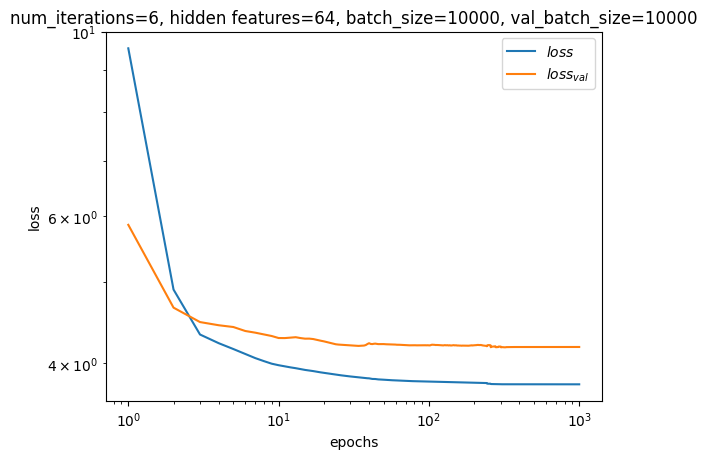

In [14]:
figloss=plt.figure()
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.title('num_iterations={}, hidden features={}, batch_size={}, val_batch_size={}'.format(6,64,batch_size,val_batch_size))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison_AllQuantile.png',dpi=190)

In [ ]:
num_iterations = 6
hidden_features = 64
initial_lr=0.001
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)
flow.load_state_dict(torch.load('modelli/epoch=999modello-AllQuantile-N_iter6-N_features64-N_BS10000-epochs1000-lr0.001.pth'))
flow.eval()

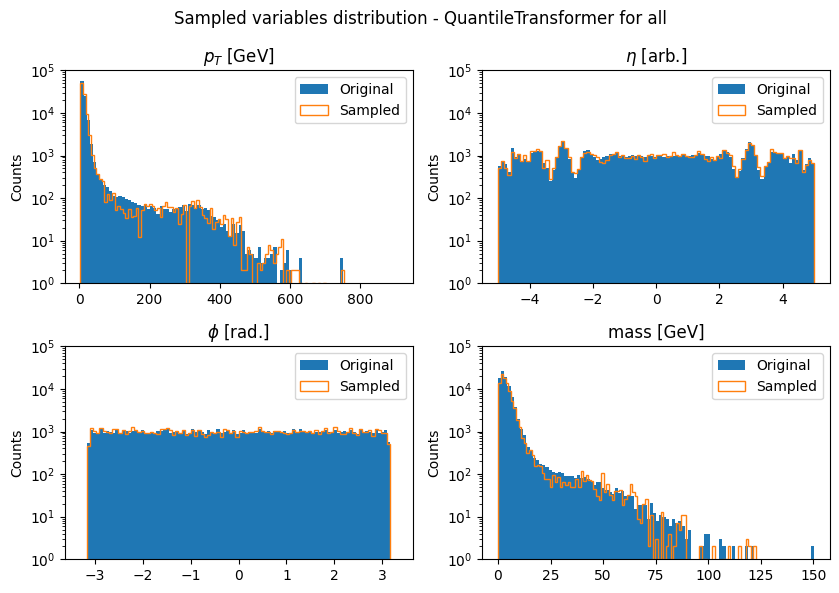

In [ ]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution - QuantileTransformer for all")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample_allquantile.pdf',dpi=190)

In [ ]:
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed, gaus, unif = x_compressor.compress(xt)
x_decompressed, gaus_post = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio with QuantileTransformer for all =',size_input/size_compressed)

Size of input file = 5.159041404724121 MB
Size of output file = 3.6342334747314453 MB
Size of compressed file = 1.7468891143798828 MB
Compression ratio with no QuantileTransformer = 2.9532735433842903
